## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Compute the camera calibration using chessboard images, find the calibration matrix and distortion coefficients and perform undistortion on raw images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import copy
import pickle
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    fname1 = fname.split('/')[-1]
    cv2.imwrite('../output_images/distorted_images/distorted_image_'+str(fname1),img)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        fname2 = fname.split('/')[-1]
        cv2.imwrite('../output_images/undistorted_images/undistorted_image_'+str(fname2),undist)


images = glob.glob('../test_images/*.jpg')        
for fname in images:
    img = cv2.imread(fname)
    fname3 = fname.split('/')[-1]
    cv2.imwrite('../output_images/distorted_images_raw/distorted_image_'+str(fname3),img)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite('../output_images/undistorted_images_raw/undistorted_image_'+str(fname3),undist)

## Compute thresholded binary image using a combination of color threshold and gradients for S channel in HLS color space and Sobel X gradient derivative

../output_images/threshold_binary/threshold_binary_undistorted_image_test6.jpg


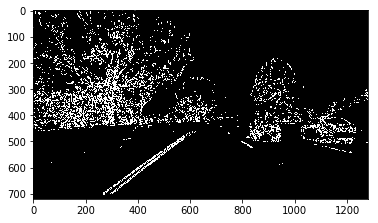

../output_images/threshold_binary/threshold_binary_undistorted_image_test3.jpg


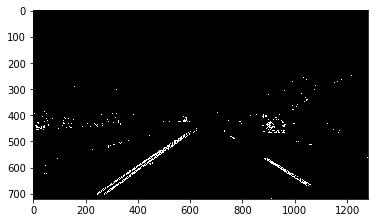

../output_images/threshold_binary/threshold_binary_undistorted_image_straight_lines1.jpg


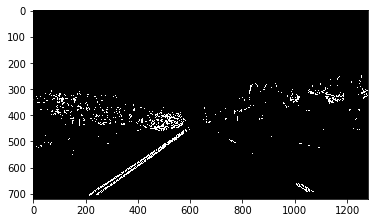

../output_images/threshold_binary/threshold_binary_undistorted_image_test5.jpg


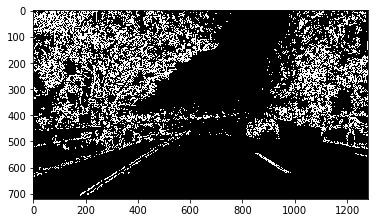

../output_images/threshold_binary/threshold_binary_undistorted_image_test4.jpg


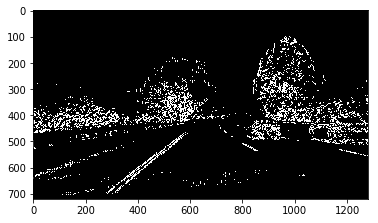

../output_images/threshold_binary/threshold_binary_undistorted_image_test1.jpg


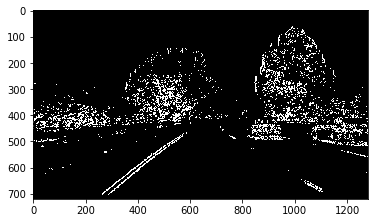

../output_images/threshold_binary/threshold_binary_undistorted_image_test2.jpg


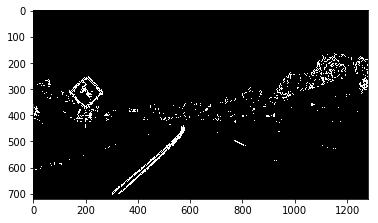

../output_images/threshold_binary/threshold_binary_undistorted_image_straight_lines2.jpg


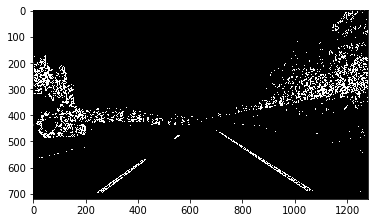

In [2]:
# Convert to HLS color space and separate the S channel
# Note: img is the undistorted image

images = glob.glob('../output_images/undistorted_images_raw/*.jpg')        
for fname in images:
    img = cv2.imread(fname)
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    s_channel = hls[:,:,2]
    s_thresh=(150, 255)
    sx_thresh=(20, 160)
    sy_thresh=(20, 160)
    
    # Sobel x
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= sx_thresh[0]) & (scaled_sobelx <= sx_thresh[1])] = 1
    
    
    # Sobel y
    sobely = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobely = np.absolute(sobely) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    # Threshold y gradient
    sybinary = np.zeros_like(scaled_sobely)
    sybinary[(scaled_sobely >= sy_thresh[0]) & (scaled_sobely <= sy_thresh[1])] = 1
    
    
    # Stack each channel
    color_binary = np.zeros_like(sxbinary)
    color_binary[(sxbinary == 1) & (sybinary == 1)] = 1
    
    
    fname4 = fname.split('/')[-1]
    cv2.imwrite('../output_images/threshold_binary/threshold_binary_'+str(fname4), color_binary*255)
    print('../output_images/threshold_binary/threshold_binary_'+str(fname4))
    plt.imshow(color_binary,cmap='gray')
    plt.show()
    

## Apply perspective transform to binary image by first calculating the perspective transform matrix on the raw undistorted image

In [3]:
# image = '../output_images/undistorted_images_raw/undistorted_image_straight_lines1.jpg'
images1 = glob.glob('../output_images/undistorted_images_raw/*.jpg')        
for fname in images1:

    # fig, axes = plt.subplots(ncols=2, figsize=(20,10))
    img = cv2.imread(fname)
    img_raw = img.copy()
    img_raw = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
    bottomY = 720
    topY = 450

    left1_x, left1_y = (200, bottomY)
    left2_x, left2_y = (585, topY)
    right1_x, right1_y = (700, topY)
    right2_x, right2_y = (1100, bottomY)

    cv2.line(img_raw, (left1_x, left1_y), (left2_x, left2_y), [255, 0, 0], 2)
    cv2.line(img_raw, (left2_x, left2_y), (right1_x, right1_y), [255, 0, 0], 2)
    cv2.line(img_raw, (right1_x, right1_y), (right2_x, right2_y), [255, 0, 0], 2)
    cv2.line(img_raw, (right2_x, right2_y), (left1_x, left1_y), [255, 0, 0], 2)
    # fig, ax = plt.subplots(figsize=(40, 20))
    # axes[0].imshow(img_raw)
    gray = cv2.cvtColor(img_raw, cv2.COLOR_RGB2GRAY)
    src = np.float32([[left2_x, left2_y], [right1_x, right1_y], [right2_x, right2_y], [left1_x, left1_y]])
    nX = gray.shape[1]
    nY = gray.shape[0]
    img_size = (nX, nY)
    offset = 200
    dst = np.float32([[offset, 0], [img_size[0]-offset, 0], [img_size[0]-offset, img_size[1]], [offset, img_size[1]]])
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    print(M)
    MInverse = cv2.getPerspectiveTransform(dst, src)
    print(MInverse)
    # warped = cv2.warpPerspective(img_raw, M, img_size)
    # axes[1].imshow(warped)
    pickle.dump({'M': M, 'MInverse': MInverse}, open('../output_images/perspective_transform.p', 'wb'))
    

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
[[ -7.37430168e-01  -1

../output_images/threshold_binary/threshold_binary_undistorted_image_straight_lines1.jpg


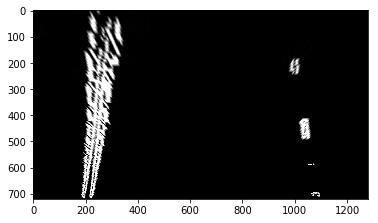

../output_images/threshold_binary/threshold_binary_undistorted_image_straight_lines2.jpg


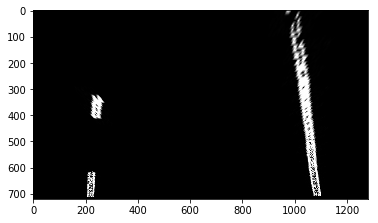

../output_images/threshold_binary/threshold_binary_undistorted_image_test1.jpg


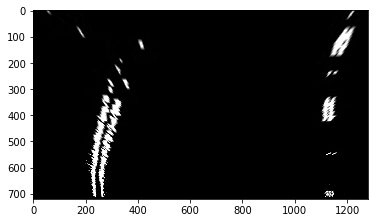

../output_images/threshold_binary/threshold_binary_undistorted_image_test2.jpg


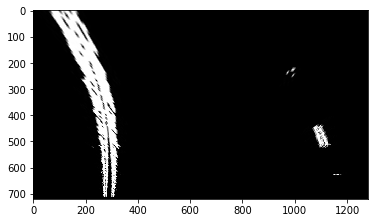

../output_images/threshold_binary/threshold_binary_undistorted_image_test3.jpg


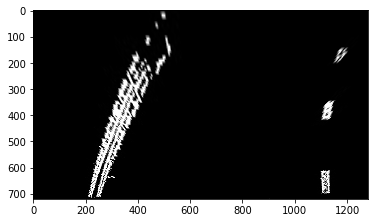

../output_images/threshold_binary/threshold_binary_undistorted_image_test4.jpg


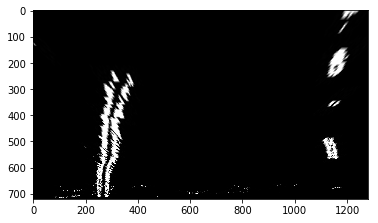

../output_images/threshold_binary/threshold_binary_undistorted_image_test5.jpg


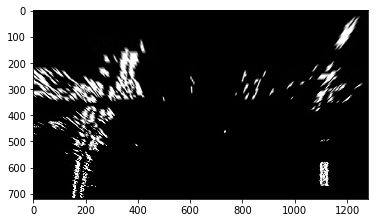

../output_images/threshold_binary/threshold_binary_undistorted_image_test6.jpg


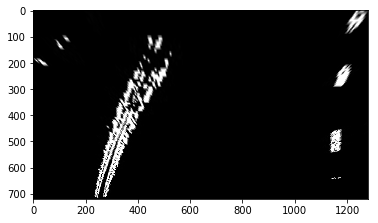

In [4]:
M_MInverse_Matrix = pickle.load( open('../output_images/perspective_transform.p', 'rb' ) )
M_, MInverse = map(M_MInverse_Matrix.get, ('M','MInverse'))
images2 = sorted(glob.glob('../output_images/threshold_binary/*.jpg'))

for index, fname in enumerate(images2):
    print(fname)
    img = cv2.imread(fname)
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M_, img_size)
    plt.imshow(warped)
    plt.show()
    fname5 = fname.split('/')[-1]
    cv2.imwrite('../output_images/warped_binary/warped_binary_'+str(fname5), warped)

## Fit lane lines using sliding window and determine lane curvature

../output_images/warped_binary/warped_binary_threshold_binary_undistorted_image_straight_lines1.jpg
(720, 1280, 3)
2920.7923604 m 433.88700685 m
2.9207923604 km 0.43388700685 km


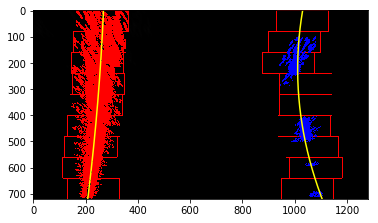

../output_images/warped_binary/warped_binary_threshold_binary_undistorted_image_straight_lines2.jpg
(720, 1280, 3)
117.138769794 m 10261.3644081 m
0.117138769794 km 10.2613644081 km


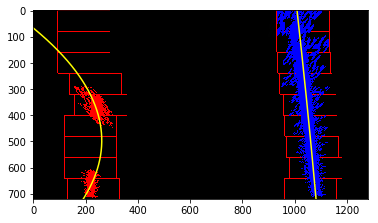

../output_images/warped_binary/warped_binary_threshold_binary_undistorted_image_test1.jpg
(720, 1280, 3)
1733.52840125 m 403.327499843 m
1.73352840125 km 0.403327499843 km


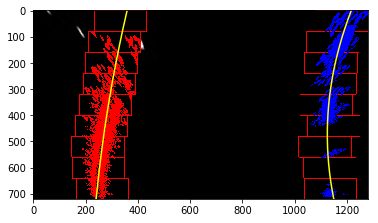

../output_images/warped_binary/warped_binary_threshold_binary_undistorted_image_test2.jpg
(720, 1280, 3)
354.993675256 m 994.840894102 m
0.354993675256 km 0.994840894102 km


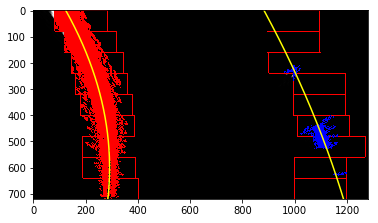

../output_images/warped_binary/warped_binary_threshold_binary_undistorted_image_test3.jpg
(720, 1280, 3)
2646.78342253 m 392.743063009 m
2.64678342253 km 0.392743063009 km


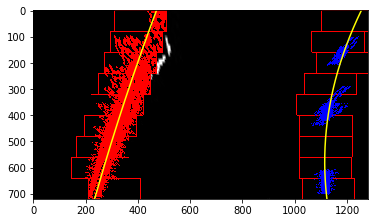

../output_images/warped_binary/warped_binary_threshold_binary_undistorted_image_test4.jpg
(720, 1280, 3)
1480.5961459 m 489.599626162 m
1.4805961459 km 0.489599626162 km


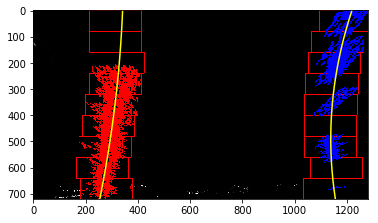

../output_images/warped_binary/warped_binary_threshold_binary_undistorted_image_test5.jpg
(720, 1280, 3)
525.353539169 m 238.119072323 m
0.525353539169 km 0.238119072323 km


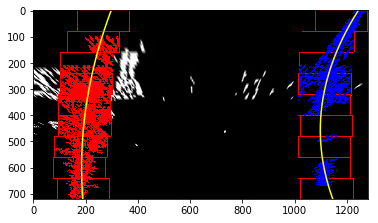

../output_images/warped_binary/warped_binary_threshold_binary_undistorted_image_test6.jpg
(720, 1280, 3)
3902.28194642 m 490.603226933 m
3.90228194642 km 0.490603226933 km


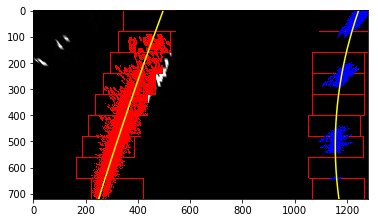

In [5]:
def find_lane_pixels(binary_warped):
    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
   
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
     # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(255,0,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(255,0,0), 2)
        
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
   
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    

    return leftx, lefty, rightx, righty, out_img, nonzerox, nonzeroy, left_lane_inds, right_lane_inds

def fit_polynomial(binary_warped):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img, nonzerox, nonzeroy, left_lane_inds, right_lane_inds = find_lane_pixels(binary_warped)
    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    print(out_img.shape)
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit_cr, right_fit_cr, left_fit, right_fit

def measure_curvature_real(left_fit_cr, right_fit_cr):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

images3 = sorted(glob.glob('../output_images/warped_binary/*.jpg'))
left_fit_arr, right_fit_arr, left_curverad_arr, right_curverad_arr, left_fitcr_arr, right_fitcr_arr = [], [], [], [], [], []
for index, fname in enumerate(images3):
    print(fname)
    binary_warped = cv2.imread(fname)
    binary_warped = cv2.cvtColor(binary_warped, cv2.COLOR_BGR2GRAY)
    out_img, left_fit_cr, right_fit_cr, left_fit, right_fit = fit_polynomial(binary_warped)
    left_fit_arr.append(left_fit)
    right_fit_arr.append(right_fit)
    left_fitcr_arr.append(left_fit_cr)
    right_fitcr_arr.append(right_fit_cr)
    left_curverad, right_curverad = measure_curvature_real(left_fit_cr, right_fit_cr)
    print(left_curverad, 'm', right_curverad, 'm')
    print(left_curverad/1000, 'km', right_curverad/1000, 'km')
    left_curverad_arr.append(left_curverad)
    right_curverad_arr.append(right_curverad)
    fname6 = fname.split('/')[-1]
    cv2.imwrite('../output_images/fit_lane_lines/fit_lane_line_'+str(fname6), out_img)
    plt.imshow(out_img)
    plt.show()
    
    

## Merge final curve to the original image

../output_images/undistorted_images_raw/undistorted_image_straight_lines1.jpg


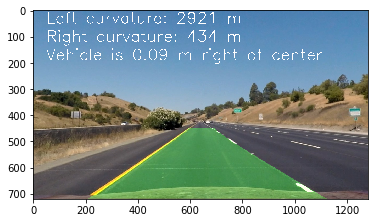

../output_images/undistorted_images_raw/undistorted_image_straight_lines2.jpg


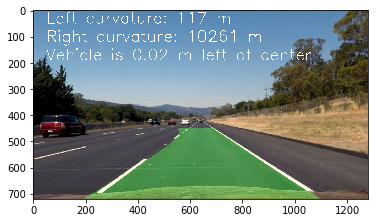

../output_images/undistorted_images_raw/undistorted_image_test1.jpg


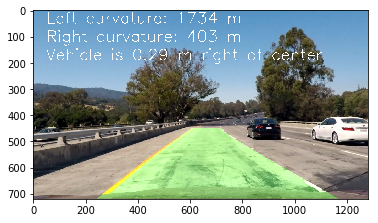

../output_images/undistorted_images_raw/undistorted_image_test2.jpg


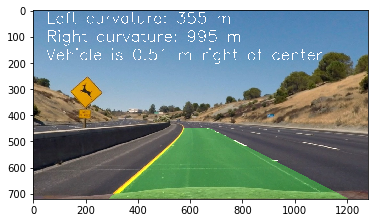

../output_images/undistorted_images_raw/undistorted_image_test3.jpg


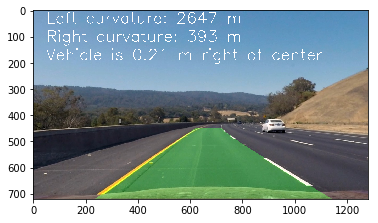

../output_images/undistorted_images_raw/undistorted_image_test4.jpg


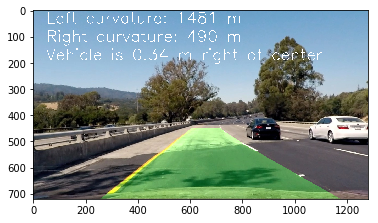

../output_images/undistorted_images_raw/undistorted_image_test5.jpg


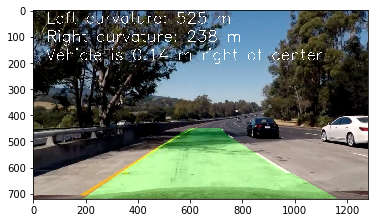

../output_images/undistorted_images_raw/undistorted_image_test6.jpg


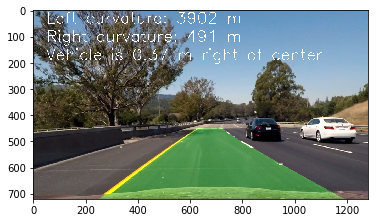

In [6]:
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
images6 = sorted(glob.glob('../output_images/undistorted_images_raw/*.jpg'))
M_MInverse_Matrix = pickle.load( open('../output_images/perspective_transform.p', 'rb' ) )
M_, MInverse = map(M_MInverse_Matrix.get, ('M','MInverse'))
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
for index, fname in enumerate(images6):
    print(fname)
    undist_raw = cv2.imread(fname)
    undist_raw = cv2.cvtColor(undist_raw, cv2.COLOR_BGR2RGB)
    color_warp = np.zeros_like(undist_raw).astype(np.uint8)
    
    left_fitx = left_fit_arr[index][0]*ploty**2 + left_fit_arr[index][1]*ploty + left_fit_arr[index][2]
    right_fitx = right_fit_arr[index][0]*ploty**2 + right_fit_arr[index][1]*ploty + right_fit_arr[index][2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, MInverse, (undist_raw.shape[1], undist_raw.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist_raw, 1, newwarp, 0.3, 0)
    
    
    cv2.putText(result, 'Left curvature: {:.0f} m'.format(left_curverad_arr[index]), (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)
    cv2.putText(result, 'Right curvature: {:.0f} m'.format(right_curverad_arr[index]), (50, 120), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)
    
    # Calculate vehicle center and deviation from center 
    # Calculate vehicle center
    xMax = undist_raw.shape[1]*xm_per_pix
    yMax = undist_raw.shape[0]*ym_per_pix
    vehicleCenter = xMax / 2
    leftLane = left_fitcr_arr[index][0]*yMax**2 + left_fitcr_arr[index][1]*yMax + left_fitcr_arr[index][2]
    rightLane = right_fitcr_arr[index][0]*yMax**2 + right_fitcr_arr[index][1]*yMax + right_fitcr_arr[index][2]
    middleLane = leftLane + (rightLane - leftLane)/2
    diffFromVehicle = middleLane - vehicleCenter
    if diffFromVehicle > 0:
        message = '{:.2f} m right'.format(diffFromVehicle)
    else:
        message = '{:.2f} m left'.format(-diffFromVehicle)
        
    cv2.putText(result, 'Vehicle is {} of center'.format(message), (50, 190), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)
    
    fname7 = fname.split('/')[-1]
    plt.imshow(result)
    plt.show()
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    cv2.imwrite('../output_images/final_outputs/final_output_'+str(fname7), result)
    


## Run test on video

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
300.401388703 m 334.893177765 m
0.300401388703 km 0.334893177765 km
[MoviePy] >>>> Building video ../project_video_output.mp4
[MoviePy] Writing video ../project_video_output.mp4


  0%|          | 1/1261 [00:00<03:22,  6.23it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
300.401388703 m 334.893177765 m
0.300401388703 km 0.334893177765 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


  0%|          | 2/1261 [00:00<03:23,  6.19it/s]

(720, 1280, 3)
309.835868671 m 367.391888492 m
0.309835868671 km 0.367391888492 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
313.712288344 m 583.725456803 m
0.313712288344 km 0.583725456803 km


  0%|          | 4/1261 [00:00<03:10,  6.61it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
313.95807397 m 285.835115081 m
0.31395807397 km 0.285835115081 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
319.024222341 m 296.13990632 m
0.319024222341 km 0.29613990632 km


  0%|          | 6/1261 [00:00<03:01,  6.92it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
329.784654737 m 350.420103245 m
0.329784654737 km 0.350420103245 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
354.377160562 m 265.272813315 m
0.354377160562 km 0.265272813315 km


  1%|          | 8/1261 [00:01<02:57,  7.06it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
356.952337987 m 1780.15456024 m
0.356952337987 km 1.78015456024 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
376.677245899 m 1760.00105251 m
0.376677245899 km 1.76000105251 km


  1%|          | 10/1261 [00:01<02:59,  6.98it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
365.512995336 m 641.758648518 m
0.365512995336 km 0.641758648518 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
367.155619669 m 486.806356233 m
0.367155619669 km 0.486806356233 km


  1%|          | 12/1261 [00:01<02:54,  7.15it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
418.698908499 m 786.029794495 m
0.418698908499 km 0.786029794495 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
395.238332782 m 507.235135181 m
0.395238332782 km 0.507235135181 km


  1%|          | 14/1261 [00:01<02:52,  7.23it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
418.856089498 m 321.247257612 m
0.418856089498 km 0.321247257612 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
386.793231852 m 373.091713111 m
0.386793231852 km 0.373091713111 km


  1%|▏         | 16/1261 [00:02<02:51,  7.26it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
369.975118792 m 466.515381187 m
0.369975118792 km 0.466515381187 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
364.859207481 m 1209.0830988 m
0.364859207481 km 1.2090830988 km


  1%|▏         | 18/1261 [00:02<02:48,  7.37it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
348.124832121 m 85.7415793409 m
0.348124832121 km 0.0857415793409 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
372.290833801 m 17916.1869992 m
0.372290833801 km 17.9161869992 km


  2%|▏         | 20/1261 [00:02<02:47,  7.40it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
352.234557774 m 748.070056626 m
0.352234557774 km 0.748070056626 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
358.367346391 m 348.252141617 m
0.358367346391 km 0.348252141617 km


  2%|▏         | 22/1261 [00:03<02:46,  7.43it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
375.064088315 m 277.458164249 m
0.375064088315 km 0.277458164249 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
381.690052406 m 340.084490827 m
0.381690052406 km 0.340084490827 km


  2%|▏         | 24/1261 [00:03<02:48,  7.34it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
348.020207765 m 877.484512432 m
0.348020207765 km 0.877484512432 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
335.065454768 m 334.902006741 m
0.335065454768 km 0.334902006741 km


  2%|▏         | 26/1261 [00:03<02:45,  7.46it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
348.273214279 m 445.972430025 m
0.348273214279 km 0.445972430025 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
342.230279046 m 318.208483904 m
0.342230279046 km 0.318208483904 km


  2%|▏         | 28/1261 [00:03<02:46,  7.41it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
359.706691203 m 359.655149019 m
0.359706691203 km 0.359655149019 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
345.869205595 m 709.661668043 m
0.345869205595 km 0.709661668043 km


  2%|▏         | 31/1261 [00:04<02:46,  7.39it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
293.045500309 m 247.724774457 m
0.293045500309 km 0.247724774457 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
280.092276267 m 376.906860074 m
0.280092276267 km 0.376906860074 km


  3%|▎         | 33/1261 [00:04<02:47,  7.32it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
262.040574641 m 5114.17540987 m
0.262040574641 km 5.11417540987 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
269.746000267 m 480.889464043 m
0.269746000267 km 0.480889464043 km


  3%|▎         | 35/1261 [00:04<02:45,  7.41it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
258.828554669 m 2029.31739277 m
0.258828554669 km 2.02931739277 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
251.867434653 m 532.485251211 m
0.251867434653 km 0.532485251211 km


  3%|▎         | 37/1261 [00:05<02:43,  7.49it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
255.746613522 m 387.524781456 m
0.255746613522 km 0.387524781456 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
248.339976284 m 873.005163384 m
0.248339976284 km 0.873005163384 km


  3%|▎         | 39/1261 [00:05<02:43,  7.49it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
244.643320935 m 731.036337375 m
0.244643320935 km 0.731036337375 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
239.481161897 m 578.263662085 m
0.239481161897 km 0.578263662085 km


  3%|▎         | 41/1261 [00:05<02:41,  7.55it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
251.518710502 m 682.506692639 m
0.251518710502 km 0.682506692639 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
259.272403308 m 629.543574425 m
0.259272403308 km 0.629543574425 km


  3%|▎         | 42/1261 [00:05<02:41,  7.54it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
258.885530506 m 367.185650534 m
0.258885530506 km 0.367185650534 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
270.453273427 m 401.505127261 m
0.270453273427 km 0.401505127261 km


  3%|▎         | 44/1261 [00:06<04:16,  4.75it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
279.80637227 m 529.200169119 m
0.27980637227 km 0.529200169119 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]

  4%|▎         | 45/1261 [00:06<04:37,  4.39it/s]


[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
297.349678444 m 342.953027075 m
0.297349678444 km 0.342953027075 km


  4%|▎         | 46/1261 [00:06<04:39,  4.34it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
306.376800956 m 1346.89219284 m
0.306376800956 km 1.34689219284 km


  4%|▎         | 47/1261 [00:07<04:24,  4.60it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
319.052979652 m 939.493330793 m
0.319052979652 km 0.939493330793 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


  4%|▍         | 48/1261 [00:07<04:27,  4.53it/s]

(720, 1280, 3)
328.441841023 m 717.693358159 m
0.328441841023 km 0.717693358159 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


  4%|▍         | 49/1261 [00:07<04:19,  4.66it/s]

360.341758942 m 536.029904631 m
0.360341758942 km 0.536029904631 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


  4%|▍         | 50/1261 [00:07<04:27,  4.53it/s]

(720, 1280, 3)
369.118147541 m 10127.8014942 m
0.369118147541 km 10.1278014942 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
388.699864277 m 499.308084127 m
0.388699864277 km 0.499308084127 km


  4%|▍         | 52/1261 [00:08<04:21,  4.63it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
383.074979566 m 311.603757139 m
0.383074979566 km 0.311603757139 km


  4%|▍         | 53/1261 [00:08<04:10,  4.81it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
379.967656306 m 587.471686833 m
0.379967656306 km 0.587471686833 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


  4%|▍         | 54/1261 [00:08<04:20,  4.63it/s]

(720, 1280, 3)
380.226683206 m 407.783526756 m
0.380226683206 km 0.407783526756 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
378.250898808 m 206.565922953 m
0.378250898808 km 0.206565922953 km


  4%|▍         | 56/1261 [00:09<04:20,  4.63it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
384.707649675 m 212.845679934 m
0.384707649675 km 0.212845679934 km


  5%|▍         | 57/1261 [00:09<04:11,  4.79it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
402.40076384 m 912.952393933 m
0.40240076384 km 0.912952393933 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


  5%|▍         | 58/1261 [00:09<04:21,  4.61it/s]

(720, 1280, 3)
402.439597183 m 345.795658736 m
0.402439597183 km 0.345795658736 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


  5%|▍         | 59/1261 [00:09<04:11,  4.77it/s]

380.442907415 m 30666.4870189 m
0.380442907415 km 30.6664870189 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


  5%|▍         | 60/1261 [00:09<04:22,  4.57it/s]

(720, 1280, 3)
358.211336483 m 137550.222264 m
0.358211336483 km 137.550222264 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


  5%|▍         | 61/1261 [00:10<04:12,  4.75it/s]

365.147346308 m 24523.7842424 m
0.365147346308 km 24.5237842424 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


  5%|▍         | 62/1261 [00:10<04:18,  4.63it/s]

(720, 1280, 3)
331.997112213 m 1661.66035915 m
0.331997112213 km 1.66166035915 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


  5%|▍         | 63/1261 [00:10<04:38,  4.30it/s]

(720, 1280, 3)
338.445697898 m 751.337720073 m
0.338445697898 km 0.751337720073 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


  5%|▌         | 64/1261 [00:10<04:26,  4.49it/s]

(720, 1280, 3)
315.227318399 m 349.254436355 m
0.315227318399 km 0.349254436355 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


  5%|▌         | 65/1261 [00:10<04:29,  4.44it/s]

(720, 1280, 3)
342.551934001 m 764.949376281 m
0.342551934001 km 0.764949376281 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
334.831129677 m 366.753398394 m
0.334831129677 km 0.366753398394 km


  5%|▌         | 67/1261 [00:11<04:57,  4.01it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
345.468102663 m 363.929138397 m
0.345468102663 km 0.363929138397 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
341.071223241 m 2421.60023133 m
0.341071223241 km 2.42160023133 km


  5%|▌         | 69/1261 [00:12<05:21,  3.71it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
319.325817688 m 93.0999488246 m
0.319325817688 km 0.0930999488246 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


  6%|▌         | 70/1261 [00:12<05:09,  3.85it/s]

(720, 1280, 3)
352.556007799 m 712.009249142 m
0.352556007799 km 0.712009249142 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
354.633699424 

  6%|▌         | 71/1261 [00:12<04:43,  4.20it/s]

m 406.15181677 m
0.354633699424 km 0.40615181677 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


  6%|▌         | 72/1261 [00:12<04:46,  4.15it/s]

(720, 1280, 3)
357.360151676 m 1029.81130858 m
0.357360151676 km 1.02981130858 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


  6%|▌         | 73/1261 [00:12<04:30,  4.39it/s]

(720, 1280, 3)
379.339377995 m 3355.51393082 m
0.379339377995 km 3.35551393082 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


  6%|▌         | 74/1261 [00:13<04:33,  4.35it/s]

(720, 1280, 3)
386.252964305 m 3033.67569009 m
0.386252964305 km 3.03367569009 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


  6%|▌         | 75/1261 [00:13<04:23,  4.49it/s]

(720, 1280, 3)
410.057036312 m 625.47544923 m
0.410057036312 km 0.62547544923 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


  6%|▌         | 76/1261 [00:13<04:28,  4.42it/s]

(720, 1280, 3)
424.81835822 m 385.023415454 m
0.42481835822 km 0.385023415454 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


  6%|▌         | 77/1261 [00:13<04:15,  4.63it/s]

472.700480149 m 375.87621384 m
0.472700480149 km 0.37587621384 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


  6%|▌         | 78/1261 [00:14<04:25,  4.46it/s]

(720, 1280, 3)
486.475402938 m 975.106320259 m
0.486475402938 km 0.975106320259 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


  6%|▋         | 79/1261 [00:14<04:12,  4.68it/s]

491.803100219 m 4193.82632516 m
0.491803100219 km 4.19382632516 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


  6%|▋         | 80/1261 [00:14<04:21,  4.52it/s]

(720, 1280, 3)
494.026975541 m 347.737891784 m
0.494026975541 km 0.347737891784 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
445.141635615 m 467.849714564 m
0.445141635615 km 0.467849714564 km


  7%|▋         | 82/1261 [00:14<04:16,  4.60it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
432.692454637 m 846.161736608 m
0.432692454637 km 0.846161736608 km


  7%|▋         | 83/1261 [00:15<04:06,  4.77it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
416.734190858 m 853.446825926 m
0.416734190858 km 0.853446825926 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


  7%|▋         | 84/1261 [00:15<04:16,  4.60it/s]

(720, 1280, 3)
435.346450912 m 724.615268457 m
0.435346450912 km 0.724615268457 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
419.521493823 m 629.362614341 m
0.419521493823 km 0.629362614341 km


  7%|▋         | 86/1261 [00:15<04:18,  4.55it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
397.438111104 m 459.708770761 m
0.397438111104 km 0.459708770761 km


  7%|▋         | 87/1261 [00:16<04:11,  4.67it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
343.310359745 m 798.421032092 m
0.343310359745 km 0.798421032092 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]


  7%|▋         | 88/1261 [00:16<04:21,  4.49it/s]

[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
310.279110007 m 301.999339822 m
0.310279110007 km 0.301999339822 km


  7%|▋         | 89/1261 [00:16<04:18,  4.53it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
303.445512907 m 356.561132639 m
0.303445512907 km 0.356561132639 km


  7%|▋         | 90/1261 [00:16<04:28,  4.37it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
270.040708857 m 441.573086686 m
0.270040708857 km 0.441573086686 km


  7%|▋         | 91/1261 [00:16<04:18,  4.53it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
283.143154107 m 608.946262142 m
0.283143154107 km 0.608946262142 km


  7%|▋         | 92/1261 [00:17<04:28,  4.35it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
287.716455265 m 532.3567348 m
0.287716455265 km 0.5323567348 km


  7%|▋         | 93/1261 [00:17<04:17,  4.53it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
270.635242563 m 431.988555496 m
0.270635242563 km 0.431988555496 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


  7%|▋         | 94/1261 [00:17<04:20,  4.49it/s]

(720, 1280, 3)
277.547090369 m 5405.10108754 m
0.277547090369 km 5.40510108754 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


  8%|▊         | 95/1261 [00:17<04:18,  4.50it/s]

(720, 1280, 3)
277.258212855 m 613.659064859 m
0.277258212855 km 0.613659064859 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


  8%|▊         | 96/1261 [00:18<04:20,  4.47it/s]

(720, 1280, 3)
301.923655532 m 340.975014467 m
0.301923655532 km 0.340975014467 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


  8%|▊         | 97/1261 [00:18<04:12,  4.62it/s]

310.028794758 m 543.062823988 m
0.310028794758 km 0.543062823988 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


  8%|▊         | 98/1261 [00:18<04:20,  4.47it/s]

(720, 1280, 3)
319.191634433 m 378.548225596 m
0.319191634433 km 0.378548225596 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


  8%|▊         | 99/1261 [00:18<04:11,  4.62it/s]

306.349767173 m 777.805098902 m
0.306349767173 km 0.777805098902 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


  8%|▊         | 100/1261 [00:18<04:18,  4.50it/s]

(720, 1280, 3)
313.954438686 m 394.083259223 m
0.313954438686 km 0.394083259223 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


  8%|▊         | 101/1261 [00:19<04:10,  4.63it/s]

311.444343585 m 313.765580389 m
0.311444343585 km 0.313765580389 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


  8%|▊         | 102/1261 [00:19<04:25,  4.37it/s]

(720, 1280, 3)
291.327293172 m 362.308485652 m
0.291327293172 km 0.362308485652 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


  8%|▊         | 103/1261 [00:19<04:17,  4.49it/s]

(720, 1280, 3)
283.937406217 m 481.241447818 m
0.283937406217 km 0.481241447818 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


  8%|▊         | 104/1261 [00:19<04:18,  4.48it/s]

(720, 1280, 3)
283.50507202 m 353.773632966 m
0.28350507202 km 0.353773632966 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


  8%|▊         | 105/1261 [00:20<05:01,  3.83it/s]

(720, 1280, 3)
294.921510314 m 264.929479155 m
0.294921510314 km 0.264929479155 km


  8%|▊         | 106/1261 [00:20<04:39,  4.13it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
310.712423948 m 327.310115458 m
0.310712423948 km 0.327310115458 km


  8%|▊         | 107/1261 [00:20<04:48,  4.00it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
307.559890518 m 458.662891162 m
0.307559890518 km 0.458662891162 km


  9%|▊         | 108/1261 [00:20<04:29,  4.28it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
287.730488618 m 356.479906223 m
0.287730488618 km 0.356479906223 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]

  9%|▊         | 109/1261 [00:21<04:31,  4.24it/s]


[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
283.147566499 m 1058.4638095 m
0.283147566499 km 1.0584638095 km


  9%|▊         | 110/1261 [00:21<04:13,  4.54it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
283.186155309 m 840.558696222 m
0.283186155309 km 0.840558696222 km


  9%|▉         | 111/1261 [00:21<04:22,  4.38it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
277.049829364 m 536.655263033 m
0.277049829364 km 0.536655263033 km


  9%|▉         | 112/1261 [00:21<04:11,  4.57it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
303.201469902 m 1239.51920878 m
0.303201469902 km 1.23951920878 km


  9%|▉         | 113/1261 [00:21<04:20,  4.40it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
284.97984557 m 981.128373512 m
0.28497984557 km 0.981128373512 km


  9%|▉         | 114/1261 [00:22<04:08,  4.61it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
271.193019462 m 612.4548257 m
0.271193019462 km 0.6124548257 km


  9%|▉         | 115/1261 [00:22<04:23,  4.35it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
258.13917379 m 819.27721902 m
0.25813917379 km 0.81927721902 km


  9%|▉         | 116/1261 [00:22<04:10,  4.58it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
255.956959987 m 3314.42611833 m
0.255956959987 km 3.31442611833 km


  9%|▉         | 117/1261 [00:22<04:20,  4.40it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
262.052831652 m 830.574345813 m
0.262052831652 km 0.830574345813 km


  9%|▉         | 118/1261 [00:23<04:08,  4.59it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
265.033927636 m 331.065885755 m
0.265033927636 km 0.331065885755 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]

  9%|▉         | 119/1261 [00:23<04:19,  4.41it/s]


(720, 1280, 3)
268.773667927 m 471.360861006 m
0.268773667927 km 0.471360861006 km


 10%|▉         | 120/1261 [00:23<04:09,  4.57it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
257.241636001 m 1015.9708066 m
0.257241636001 km 1.0159708066 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 10%|▉         | 121/1261 [00:23<04:19,  4.39it/s]

(720, 1280, 3)
263.581286367 m 393.835731199 m
0.263581286367 km 0.393835731199 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 10%|▉         | 122/1261 [00:23<04:08,  4.58it/s]

265.448353023 m 676.0112277 m
0.265448353023 km 0.6760112277 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 10%|▉         | 123/1261 [00:24<04:17,  4.43it/s]

(720, 1280, 3)
261.153573894 m 434.903511081 m
0.261153573894 km 0.434903511081 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
264.368157907 m 978.170818895 m
0.264368157907 km 0.978170818895 km


 10%|▉         | 125/1261 [00:24<04:13,  4.48it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
269.726877838 m 512.288432543 m
0.269726877838 km 0.512288432543 km


 10%|▉         | 126/1261 [00:24<04:03,  4.65it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
288.301488481 m 318.610819383 m
0.288301488481 km 0.318610819383 km


 10%|█         | 127/1261 [00:25<04:14,  4.45it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
285.65887053 m 259.328858684 m
0.28565887053 km 0.259328858684 km


 10%|█         | 128/1261 [00:25<04:03,  4.65it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
325.080240286 m 292.817170789 m
0.325080240286 km 0.292817170789 km


 10%|█         | 129/1261 [00:25<04:15,  4.42it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
296.999281222 m 274.230431487 m
0.296999281222 km 0.274230431487 km


 10%|█         | 130/1261 [00:25<04:41,  4.02it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
293.752966914 m 252.035959359 m
0.293752966914 km 0.252035959359 km


 10%|█         | 131/1261 [00:25<04:26,  4.24it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
299.767017861 m 469.79054445 m
0.299767017861 km 0.46979054445 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]

 10%|█         | 132/1261 [00:26<04:30,  4.17it/s]


[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
292.846732409 m 967.393212148 m
0.292846732409 km 0.967393212148 km


 11%|█         | 133/1261 [00:26<04:18,  4.37it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
321.540763251 m 329.23524736 m
0.321540763251 km 0.32923524736 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]

 11%|█         | 134/1261 [00:26<04:17,  4.37it/s]


(720, 1280, 3)
307.336259928 m 1992.17972588 m
0.307336259928 km 1.99217972588 km


 11%|█         | 135/1261 [00:26<04:28,  4.20it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
324.884274617 m 22186.666675 m
0.324884274617 km 22.186666675 km


 11%|█         | 136/1261 [00:27<04:12,  4.46it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
334.031426371 m 2332.20842137 m
0.334031426371 km 2.33220842137 km


 11%|█         | 137/1261 [00:27<04:18,  4.34it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
345.731650336 m 1125.7701048 m
0.345731650336 km 1.1257701048 km


 11%|█         | 138/1261 [00:27<04:04,  4.60it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
364.578376103 m 1230.40248186 m
0.364578376103 km 1.23040248186 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]

 11%|█         | 139/1261 [00:27<04:11,  4.46it/s]


[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
374.150691666 m 501.025830931 m
0.374150691666 km 0.501025830931 km


 11%|█         | 140/1261 [00:27<04:01,  4.64it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
393.779594039 m 644.927331697 m
0.393779594039 km 0.644927331697 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]

 11%|█         | 141/1261 [00:28<04:12,  4.44it/s]


[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
377.340128519 m 481.260793272 m
0.377340128519 km 0.481260793272 km


 11%|█▏        | 142/1261 [00:28<04:05,  4.57it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
406.943592738 m 505.563524555 m
0.406943592738 km 0.505563524555 km


 11%|█▏        | 143/1261 [00:28<04:13,  4.41it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
379.233287237 m 248.558787507 m
0.379233287237 km 0.248558787507 km


 11%|█▏        | 144/1261 [00:28<04:01,  4.63it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
374.912952524 m 433.722055493 m
0.374912952524 km 0.433722055493 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]


 11%|█▏        | 145/1261 [00:29<04:13,  4.41it/s]

[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
386.71138443 m 4084.0822506 m
0.38671138443 km 4.0840822506 km


 12%|█▏        | 146/1261 [00:29<04:01,  4.62it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
382.127503438 m 386.896906506 m
0.382127503438 km 0.386896906506 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 12%|█▏        | 147/1261 [00:29<04:07,  4.50it/s]

(720, 1280, 3)
393.326865205 m 3749.49067331 m
0.393326865205 km 3.74949067331 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 12%|█▏        | 148/1261 [00:29<03:58,  4.66it/s]

348.358526012 m 1624.26668304 m
0.348358526012 km 1.62426668304 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 12%|█▏        | 149/1261 [00:29<04:08,  4.48it/s]

(720, 1280, 3)
341.041224216 m 471.369482483 m
0.341041224216 km 0.471369482483 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 12%|█▏        | 150/1261 [00:30<04:02,  4.57it/s]

(720, 1280, 3)
362.61763843 m 10466.2972427 m
0.36261763843 km 10.4662972427 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 12%|█▏        | 151/1261 [00:30<04:11,  4.42it/s]

(720, 1280, 3)
346.159962171 m 2431.96795148 m
0.346159962171 km 2.43196795148 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
333.558985991

 12%|█▏        | 152/1261 [00:30<04:02,  4.58it/s]

 m 968.247834741 m
0.333558985991 km 0.968247834741 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 12%|█▏        | 153/1261 [00:30<04:07,  4.47it/s]

(720, 1280, 3)
320.389348471 m 7248.73251202 m
0.320389348471 km 7.24873251202 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 12%|█▏        | 154/1261 [00:31<03:58,  4.64it/s]

353.198515126 m 8481.69907326 m
0.353198515126 km 8.48169907326 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 12%|█▏        | 155/1261 [00:31<04:06,  4.49it/s]

(720, 1280, 3)
357.789558068 m 771.832766432 m
0.357789558068 km 0.771832766432 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 12%|█▏        | 156/1261 [00:31<03:59,  4.61it/s]

(720, 1280, 3)
354.683525533 m 336.726795032 m
0.354683525533 km 0.336726795032 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 12%|█▏        | 157/1261 [00:31<04:07,  4.46it/s]

(720, 1280, 3)
337.018593803 m 749.140737285 m
0.337018593803 km 0.749140737285 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
305.766870557 m 329.655122276 m
0.305766870557 km 

 13%|█▎        | 158/1261 [00:31<03:56,  4.66it/s]

0.329655122276 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 13%|█▎        | 159/1261 [00:32<04:27,  4.12it/s]

(720, 1280, 3)
340.75276872 m 216.059776582 m
0.34075276872 km 0.216059776582 km


 13%|█▎        | 160/1261 [00:32<04:10,  4.40it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
312.286145566 m 1365.96039374 m
0.312286145566 km 1.36596039374 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 13%|█▎        | 161/1261 [00:32<04:12,  4.35it/s]

(720, 1280, 3)
333.212706485 m 3252.41582376 m
0.333212706485 km 3.25241582376 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
325.651494277 m 1214.08476163 m
0.325651494277 km 1.21408476163 km

 13%|█▎        | 162/1261 [00:32<04:01,  4.55it/s]


[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 13%|█▎        | 163/1261 [00:33<04:06,  4.45it/s]

(720, 1280, 3)
322.999803236 m 875.74167059 m
0.322999803236 km 0.87574167059 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 13%|█▎        | 164/1261 [00:33<04:31,  4.04it/s]

(720, 1280, 3)
328.374693242 m 405.397169158 m
0.328374693242 km 0.405397169158 km


 13%|█▎        | 165/1261 [00:33<04:29,  4.06it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
321.205883813 m 293.707502396 m
0.321205883813 km 0.293707502396 km


 13%|█▎        | 166/1261 [00:33<04:11,  4.35it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
311.956225927 m 842.310046745 m
0.311956225927 km 0.842310046745 km


 13%|█▎        | 167/1261 [00:34<04:14,  4.29it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
301.754249416 m 464.987831186 m
0.301754249416 km 0.464987831186 km


 13%|█▎        | 168/1261 [00:34<04:02,  4.51it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
336.990546418 m 356.130007712 m
0.336990546418 km 0.356130007712 km


 13%|█▎        | 169/1261 [00:34<04:12,  4.33it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
308.266398778 m 2712.39369638 m
0.308266398778 km 2.71239369638 km


 13%|█▎        | 170/1261 [00:34<03:59,  4.56it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
341.230185632 m 807.774258749 m
0.341230185632 km 0.807774258749 km


 14%|█▎        | 171/1261 [00:34<04:05,  4.44it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
354.839476262 m 2357.30293738 m
0.354839476262 km 2.35730293738 km


 14%|█▎        | 172/1261 [00:35<03:55,  4.62it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
357.91165421 m 1238.55902007 m
0.35791165421 km 1.23855902007 km


 14%|█▎        | 173/1261 [00:35<04:03,  4.47it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
352.092119 m 365.443883732 m
0.352092119 km 0.365443883732 km


 14%|█▍        | 174/1261 [00:35<03:52,  4.67it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
301.311195315 m 367.646216567 m
0.301311195315 km 0.367646216567 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 14%|█▍        | 175/1261 [00:35<04:02,  4.48it/s]

(720, 1280, 3)
286.50062622 m 523.283400178 m
0.28650062622 km 0.523283400178 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 14%|█▍        | 176/1261 [00:36<03:54,  4.64it/s]

280.639651678 m 497.772264506 m
0.280639651678 km 0.497772264506 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 14%|█▍        | 177/1261 [00:36<04:03,  4.45it/s]

(720, 1280, 3)
296.533980665 m 427.54768115 m
0.296533980665 km 0.42754768115 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 14%|█▍        | 178/1261 [00:36<03:55,  4.60it/s]

291.566130933 m 561.11271998 m
0.291566130933 km 0.56111271998 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 14%|█▍        | 179/1261 [00:36<04:01,  4.49it/s]

(720, 1280, 3)
286.502701427 m 290.287667306 m
0.286502701427 km 0.290287667306 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 14%|█▍        | 180/1261 [00:36<03:54,  4.60it/s]

281.506201589 m 193.269250103 m
0.281506201589 km 0.193269250103 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 14%|█▍        | 181/1261 [00:37<04:01,  4.46it/s]

(720, 1280, 3)
270.930148654 m 236.598671995 m
0.270930148654 km 0.236598671995 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)

 14%|█▍        | 182/1261 [00:37<03:56,  4.56it/s]


279.069211587 m 365.662613887 m
0.279069211587 km 0.365662613887 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 15%|█▍        | 183/1261 [00:37<04:04,  4.41it/s]

(720, 1280, 3)
266.142255986 m 216.026978102 m
0.266142255986 km 0.216026978102 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
245.369914829 m 784.687906216 

 15%|█▍        | 184/1261 [00:37<03:52,  4.62it/s]

m
0.245369914829 km 0.784687906216 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 15%|█▍        | 185/1261 [00:38<04:01,  4.45it/s]

(720, 1280, 3)
234.547547932 m 577.552786089 m
0.234547547932 km 0.577552786089 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 15%|█▍        | 186/1261 [00:38<03:50,  4.66it/s]

211.4511773 m 762.374189031 m
0.2114511773 km 0.762374189031 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 15%|█▍        | 187/1261 [00:38<04:00,  4.47it/s]

(720, 1280, 3)
215.999868982 m 754.374698804 m
0.215999868982 km 0.754374698804 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
213.135885768

 15%|█▍        | 188/1261 [00:38<03:49,  4.67it/s]

 m 252.401738208 m
0.213135885768 km 0.252401738208 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 15%|█▍        | 189/1261 [00:38<03:57,  4.51it/s]

(720, 1280, 3)
219.83395588 m 326.429259453 m
0.21983395588 km 0.326429259453 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
221.288090841 m 312.726451835

 15%|█▌        | 190/1261 [00:39<03:50,  4.64it/s]

 m
0.221288090841 km 0.312726451835 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 15%|█▌        | 191/1261 [00:39<03:58,  4.49it/s]

(720, 1280, 3)
222.605980018 m 454.371419685 m
0.222605980018 km 0.454371419685 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
236.513827643 m 228.57955283 m
0.236513827643 km 0.22857955283 km


 15%|█▌        | 193/1261 [00:39<03:57,  4.50it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
230.382044932 m 442.862614949 m
0.230382044932 km 0.442862614949 km


 15%|█▌        | 194/1261 [00:40<04:28,  3.98it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
240.236394985 m 239.775787154 m
0.240236394985 km 0.239775787154 km


 15%|█▌        | 195/1261 [00:40<04:13,  4.21it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
234.589099159 m 4717.97578043 m
0.234589099159 km 4.71797578043 km


 16%|█▌        | 196/1261 [00:40<04:21,  4.08it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
272.496346764 m 453.63479053 m
0.272496346764 km 0.45363479053 km


 16%|█▌        | 197/1261 [00:40<04:06,  4.32it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
308.621970875 m 4407.82756244 m
0.308621970875 km 4.40782756244 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]


 16%|█▌        | 198/1261 [00:41<04:11,  4.23it/s]

[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
352.396137335 m 1504.68074103 m
0.352396137335 km 1.50468074103 km


 16%|█▌        | 199/1261 [00:41<03:58,  4.45it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
405.938688704 m 1519.11165554 m
0.405938688704 km 1.51911165554 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 16%|█▌        | 200/1261 [00:41<04:05,  4.32it/s]

(720, 1280, 3)
395.079319678 m 24002.735843 m
0.395079319678 km 24.002735843 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 16%|█▌        | 201/1261 [00:41<03:54,  4.53it/s]

(720, 1280, 3)
415.665308829 m 337.672661573 m
0.415665308829 km 0.337672661573 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 16%|█▌        | 202/1261 [00:41<03:59,  4.41it/s]

(720, 1280, 3)
390.143315882 m 873.000517462 m
0.390143315882 km 0.873000517462 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 16%|█▌        | 203/1261 [00:42<03:55,  4.50it/s]

(720, 1280, 3)
345.857064462 m 798.897675753 m
0.345857064462 km 0.798897675753 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 16%|█▌        | 204/1261 [00:42<04:00,  4.39it/s]

(720, 1280, 3)
330.132037352 m 1260.54562825 m
0.330132037352 km 1.26054562825 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
309.513824479 m 389.447115293 m


 16%|█▋        | 205/1261 [00:42<03:49,  4.61it/s]

0.309513824479 km 0.389447115293 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 16%|█▋        | 206/1261 [00:42<03:58,  4.42it/s]

(720, 1280, 3)
290.934242698 m 318.343517548 m
0.290934242698 km 0.318343517548 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
267.295815343 m 412.667283455 m
0.267295815343 km 0.412667283455 km


 16%|█▋        | 208/1261 [00:43<03:54,  4.50it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
257.531497138 m 295.785531863 m
0.257531497138 km 0.295785531863 km


 17%|█▋        | 209/1261 [00:43<03:50,  4.56it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
270.106236849 m 807.535052335 m
0.270106236849 km 0.807535052335 km


 17%|█▋        | 210/1261 [00:43<04:00,  4.37it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
284.753498495 m 666.823777349 m
0.284753498495 km 0.666823777349 km


 17%|█▋        | 211/1261 [00:43<03:50,  4.56it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
317.044279168 m 2327.76022001 m
0.317044279168 km 2.32776022001 km


 17%|█▋        | 212/1261 [00:44<03:57,  4.41it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
299.186078294 m 10183.5033575 m
0.299186078294 km 10.1835033575 km


 17%|█▋        | 213/1261 [00:44<03:49,  4.57it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
306.958377086 m 1109.61570465 m
0.306958377086 km 1.10961570465 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 17%|█▋        | 214/1261 [00:44<03:55,  4.45it/s]

(720, 1280, 3)
289.920449622 m 283.657531418 m
0.289920449622 km 0.283657531418 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
299.776932763 m 462.141903264 m
0.299776932763 km 0.462141903264 km


 17%|█▋        | 216/1261 [00:45<03:52,  4.49it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
300.073963695 m 316.455391612 m
0.300073963695 km 0.316455391612 km


 17%|█▋        | 217/1261 [00:45<03:42,  4.69it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
300.028090643 m 270.236121554 m
0.300028090643 km 0.270236121554 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]


 17%|█▋        | 218/1261 [00:45<03:50,  4.52it/s]

[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
311.511738966 m 221.92396386 m
0.311511738966 km 0.22192396386 km


 17%|█▋        | 219/1261 [00:45<03:42,  4.68it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
306.395486689 m 2576.06111933 m
0.306395486689 km 2.57606111933 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 17%|█▋        | 220/1261 [00:45<03:49,  4.54it/s]

(720, 1280, 3)
333.432569531 m 228.695419468 m
0.333432569531 km 0.228695419468 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
343.016542348 

 18%|█▊        | 221/1261 [00:46<03:41,  4.70it/s]

m 329.730289675 m
0.343016542348 km 0.329730289675 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 18%|█▊        | 222/1261 [00:46<03:55,  4.42it/s]

(720, 1280, 3)
349.075170983 m 357.558122335 m
0.349075170983 km 0.357558122335 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 18%|█▊        | 223/1261 [00:46<03:50,  4.51it/s]

(720, 1280, 3)
355.569924471 m 448.822053792 m
0.355569924471 km 0.448822053792 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 18%|█▊        | 224/1261 [00:46<03:55,  4.40it/s]

(720, 1280, 3)
349.309096102 m 447.183226502 m
0.349309096102 km 0.447183226502 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 18%|█▊        | 225/1261 [00:46<03:44,  4.61it/s]

357.447846252 m 1087.77210937 m
0.357447846252 km 1.08777210937 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 18%|█▊        | 226/1261 [00:47<03:56,  4.38it/s]

(720, 1280, 3)
348.677263571 m 663.97965765 m
0.348677263571 km 0.66397965765 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 18%|█▊        | 227/1261 [00:47<03:48,  4.52it/s]

(720, 1280, 3)
366.123607176 m 2177.39378896 m
0.366123607176 km 2.17739378896 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 18%|█▊        | 228/1261 [00:47<03:56,  4.36it/s]

(720, 1280, 3)
384.195304115 m 1188.46963787 m
0.384195304115 km 1.18846963787 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
369.081667758 m 548.450227544 m
0.369081667758 km 0.548450227544

 18%|█▊        | 229/1261 [00:47<03:46,  4.56it/s]

 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 18%|█▊        | 230/1261 [00:48<03:51,  4.46it/s]

(720, 1280, 3)
402.767223624 m 429.76385811 m
0.402767223624 km 0.42976385811 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 18%|█▊        | 231/1261 [00:48<03:42,  4.63it/s]

404.256786854 m 381.458772869 m
0.404256786854 km 0.381458772869 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 18%|█▊        | 232/1261 [00:48<03:51,  4.44it/s]

(720, 1280, 3)
436.073771951 m 361.918700965 m
0.436073771951 km 0.361918700965 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 18%|█▊        | 233/1261 [00:48<03:42,  4.62it/s]

429.007990725 m 1908.59656015 m
0.429007990725 km 1.90859656015 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 19%|█▊        | 234/1261 [00:48<03:49,  4.47it/s]

(720, 1280, 3)
437.648288827 m 1058.01844436 m
0.437648288827 km 1.05801844436 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 19%|█▊        | 235/1261 [00:49<03:40,  4.64it/s]

420.952587776 m 725.492737924 m
0.420952587776 km 0.725492737924 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 19%|█▊        | 236/1261 [00:49<03:51,  4.42it/s]

(720, 1280, 3)
373.597137451 m 1304.56908961 m
0.373597137451 km 1.30456908961 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 19%|█▉        | 237/1261 [00:49<03:43,  4.58it/s]

350.525569321 m 406.931133777 m
0.350525569321 km 0.406931133777 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 19%|█▉        | 238/1261 [00:49<03:51,  4.43it/s]

(720, 1280, 3)
301.593557327 m 319.514974689 m
0.301593557327 km 0.319514974689 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 19%|█▉        | 239/1261 [00:50<03:43,  4.58it/s]

309.195199046 m 543.54817386 m
0.309195199046 km 0.54354817386 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 19%|█▉        | 240/1261 [00:50<03:54,  4.36it/s]

(720, 1280, 3)
307.548076118 m 391.496990199 m
0.307548076118 km 0.391496990199 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 19%|█▉        | 241/1261 [00:50<03:48,  4.46it/s]

(720, 1280, 3)
313.78606839 m 345.60619193 m
0.31378606839 km 0.34560619193 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 19%|█▉        | 242/1261 [00:50<03:57,  4.30it/s]

(720, 1280, 3)
306.906733491 m 296.954521527 m
0.306906733491 km 0.296954521527 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
279.283840416 m 650.577376663 m
0.279283840416 km 0.650577376663 km


 19%|█▉        | 244/1261 [00:51<03:51,  4.40it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
304.860802988 m 293.999639082 m
0.304860802988 km 0.293999639082 km


 19%|█▉        | 245/1261 [00:51<03:40,  4.62it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
285.45170818 m 524.994572385 m
0.28545170818 km 0.524994572385 km


 20%|█▉        | 246/1261 [00:51<04:08,  4.08it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
290.798542261 m 2284.24697198 m
0.290798542261 km 2.28424697198 km


 20%|█▉        | 247/1261 [00:52<04:35,  3.69it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
294.763144577 m 2640.06004815 m
0.294763144577 km 2.64006004815 km


 20%|█▉        | 248/1261 [00:52<05:02,  3.34it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
281.386758443 m 38160.0619683 m
0.281386758443 km 38.1600619683 km


 20%|█▉        | 249/1261 [00:52<05:09,  3.27it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
292.799409505 m 121.666540861 m
0.292799409505 km 0.121666540861 km


 20%|█▉        | 250/1261 [00:53<05:09,  3.27it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
280.379519257 m 405.03237642 m
0.280379519257 km 0.40503237642 km


 20%|█▉        | 251/1261 [00:53<04:37,  3.65it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
286.711499766 m 505.276945094 m
0.286711499766 km 0.505276945094 km


 20%|█▉        | 252/1261 [00:53<04:31,  3.72it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
316.536498327 m 584.109195894 m
0.316536498327 km 0.584109195894 km


 20%|██        | 253/1261 [00:53<04:10,  4.03it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
319.003360103 m 382.852916698 m
0.319003360103 km 0.382852916698 km


 20%|██        | 254/1261 [00:53<04:07,  4.07it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
334.122032707 m 198.765781153 m
0.334122032707 km 0.198765781153 km


 20%|██        | 255/1261 [00:54<03:52,  4.33it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
318.299168674 m 504.244832371 m
0.318299168674 km 0.504244832371 km


 20%|██        | 256/1261 [00:54<03:54,  4.28it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
358.483702947 m 4936.0924314 m
0.358483702947 km 4.9360924314 km


 20%|██        | 257/1261 [00:54<03:43,  4.50it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
336.051800466 m 4884.02508223 m
0.336051800466 km 4.88402508223 km


 20%|██        | 258/1261 [00:54<03:50,  4.35it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
349.957241068 m 11212.4295139 m
0.349957241068 km 11.2124295139 km


 21%|██        | 259/1261 [00:55<03:40,  4.55it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
352.602961768 m 1202.78399504 m
0.352602961768 km 1.20278399504 km


 21%|██        | 260/1261 [00:55<03:46,  4.43it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
336.422117643 m 571.156436387 m
0.336422117643 km 0.571156436387 km


 21%|██        | 261/1261 [00:55<03:41,  4.51it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
344.914806889 m 490.334305781 m
0.344914806889 km 0.490334305781 km


 21%|██        | 262/1261 [00:55<03:50,  4.33it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
352.85104067 m 367.154741447 m
0.35285104067 km 0.367154741447 km


 21%|██        | 263/1261 [00:55<03:41,  4.51it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
354.758623035 m 892.7177177 m
0.354758623035 km 0.8927177177 km


 21%|██        | 264/1261 [00:56<03:49,  4.33it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
355.786196226 m 1981.29310036 m
0.355786196226 km 1.98129310036 km


 21%|██        | 265/1261 [00:56<03:39,  4.54it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
351.261445172 m 516.340040957 m
0.351261445172 km 0.516340040957 km


 21%|██        | 266/1261 [00:56<03:47,  4.37it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
358.949199764 m 278.846192872 m
0.358949199764 km 0.278846192872 km


 21%|██        | 267/1261 [00:56<03:37,  4.57it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
332.678689525 m 333.217096063 m
0.332678689525 km 0.333217096063 km


 21%|██▏       | 268/1261 [00:57<03:45,  4.40it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
347.355980132 m 743.118559144 m
0.347355980132 km 0.743118559144 km


 21%|██▏       | 269/1261 [00:57<03:36,  4.58it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
384.010277292 m 406.722314023 m
0.384010277292 km 0.406722314023 km


 21%|██▏       | 270/1261 [00:57<03:45,  4.40it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
392.661141191 m 461.352693639 m
0.392661141191 km 0.461352693639 km


 21%|██▏       | 271/1261 [00:57<03:35,  4.59it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
420.299134535 m 636.166241193 m
0.420299134535 km 0.636166241193 km


 22%|██▏       | 272/1261 [00:57<03:44,  4.41it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
395.851774581 m 373.664954997 m
0.395851774581 km 0.373664954997 km


 22%|██▏       | 273/1261 [00:58<03:34,  4.60it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
418.086305855 m 372.392573928 m
0.418086305855 km 0.372392573928 km


 22%|██▏       | 274/1261 [00:58<03:50,  4.28it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
407.560605663 m 1025.72778877 m
0.407560605663 km 1.02572778877 km


 22%|██▏       | 275/1261 [00:58<03:39,  4.49it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
407.880547601 m 3226.64043713 m
0.407880547601 km 3.22664043713 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]

 22%|██▏       | 276/1261 [00:58<03:44,  4.39it/s]


[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
453.01612191 m 5902.83031735 m
0.45301612191 km 5.90283031735 km


 22%|██▏       | 277/1261 [00:59<03:34,  4.58it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
441.8534397 m 542.886098134 m
0.4418534397 km 0.542886098134 km


 22%|██▏       | 278/1261 [00:59<03:39,  4.47it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
501.385837402 m 476.343422078 m
0.501385837402 km 0.476343422078 km


 22%|██▏       | 279/1261 [00:59<03:31,  4.64it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
528.713160475 m 1545.46357232 m
0.528713160475 km 1.54546357232 km


 22%|██▏       | 280/1261 [00:59<03:40,  4.44it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
518.19073918 m 423.149746945 m
0.51819073918 km 0.423149746945 km


 22%|██▏       | 281/1261 [00:59<03:30,  4.65it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
536.672011674 m 404.071394654 m
0.536672011674 km 0.404071394654 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]

 22%|██▏       | 282/1261 [01:00<03:40,  4.44it/s]


[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
525.028463044 m 578.569188636 m
0.525028463044 km 0.578569188636 km


 22%|██▏       | 283/1261 [01:00<03:35,  4.55it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
574.966618067 m 753.393422824 m
0.574966618067 km 0.753393422824 km


 23%|██▎       | 284/1261 [01:00<03:44,  4.36it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
558.965478337 m 611.500815668 m
0.558965478337 km 0.611500815668 km


 23%|██▎       | 285/1261 [01:00<03:35,  4.53it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
608.707037531 m 764.833472827 m
0.608707037531 km 0.764833472827 km


 23%|██▎       | 286/1261 [01:01<03:40,  4.42it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
664.150354018 m 721.184174972 m
0.664150354018 km 0.721184174972 km


 23%|██▎       | 287/1261 [01:01<03:30,  4.63it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
740.242231261 m 8178.85251568 m
0.740242231261 km 8.17885251568 km


 23%|██▎       | 288/1261 [01:01<03:44,  4.34it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
751.516673788 m 9769.05960334 m
0.751516673788 km 9.76905960334 km


 23%|██▎       | 289/1261 [01:01<03:33,  4.54it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
723.080623909 m 773.283572006 m
0.723080623909 km 0.773283572006 km


 23%|██▎       | 290/1261 [01:01<03:39,  4.42it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
790.602445998 m 675.058815139 m
0.790602445998 km 0.675058815139 km


 23%|██▎       | 291/1261 [01:02<03:31,  4.58it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
634.812464263 m 624.150165924 m
0.634812464263 km 0.624150165924 km


 23%|██▎       | 292/1261 [01:02<03:30,  4.60it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
710.716593153 m 745.658450872 m
0.710716593153 km 0.745658450872 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 23%|██▎       | 293/1261 [01:02<03:24,  4.74it/s]

(720, 1280, 3)
755.253481204 m 790.646309543 m
0.755253481204 km 0.790646309543 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 23%|██▎       | 294/1261 [01:02<03:23,  4.76it/s]

(720, 1280, 3)
719.869616177 m 598.392351781 m
0.719869616177 km 0.598392351781 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
713.328418794 m 652.144832148 m
0.713328418794 km 0.652144832148 km


 23%|██▎       | 296/1261 [01:03<03:22,  4.76it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
658.442942669 m 532.963589414 m
0.658442942669 km 0.532963589414 km


 24%|██▎       | 297/1261 [01:03<03:19,  4.83it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
690.348900908 m 511.108241051 m
0.690348900908 km 0.511108241051 km


 24%|██▎       | 298/1261 [01:03<03:30,  4.58it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
771.975009805 m 567.67006817 m
0.771975009805 km 0.56767006817 km


 24%|██▎       | 299/1261 [01:03<03:23,  4.73it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
773.847339655 m 1367.25836244 m
0.773847339655 km 1.36725836244 km


 24%|██▍       | 300/1261 [01:04<03:34,  4.48it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
808.143551022 m 1527.70743926 m
0.808143551022 km 1.52770743926 km


 24%|██▍       | 301/1261 [01:04<03:27,  4.62it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1023.77030883 m 615.489531943 m
1.02377030883 km 0.615489531943 km


 24%|██▍       | 302/1261 [01:04<03:41,  4.33it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
844.380995655 m 887.97667237 m
0.844380995655 km 0.88797667237 km


 24%|██▍       | 303/1261 [01:04<03:31,  4.54it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
996.485492399 m 1038.33107024 m
0.996485492399 km 1.03833107024 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]


 24%|██▍       | 304/1261 [01:05<03:37,  4.40it/s]

[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
972.863565733 m 801.047378438 m
0.972863565733 km 0.801047378438 km


 24%|██▍       | 305/1261 [01:05<03:28,  4.59it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
897.148615544 m 1023.22894425 m
0.897148615544 km 1.02322894425 km


 24%|██▍       | 306/1261 [01:05<03:35,  4.43it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
843.936348305 m 592.471668155 m
0.843936348305 km 0.592471668155 km


 24%|██▍       | 307/1261 [01:05<03:28,  4.59it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
879.036321255 m 1112.95205998 m
0.879036321255 km 1.11295205998 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]

 24%|██▍       | 308/1261 [01:05<03:35,  4.43it/s]


[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
804.591252488 m 1010.33716022 m
0.804591252488 km 1.01033716022 km


 25%|██▍       | 309/1261 [01:06<03:26,  4.61it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1186.80159537 m 2988.42166739 m
1.18680159537 km 2.98842166739 km


 25%|██▍       | 310/1261 [01:06<03:35,  4.42it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
2380.7871467 m 1125.71392999 m
2.3807871467 km 1.12571392999 km


 25%|██▍       | 311/1261 [01:06<03:26,  4.60it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
14722.3541884 m 1690.85257285 m
14.7223541884 km 1.69085257285 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 25%|██▍       | 312/1261 [01:06<03:34,  4.42it/s]

(720, 1280, 3)
3458.57744004 m 5356.65648058 m
3.45857744004 km 5.35665648058 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 25%|██▍       | 313/1261 [01:06<03:25,  4.60it/s]

2579.36684732 m 6967.248721 m
2.57936684732 km 6.967248721 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 25%|██▍       | 314/1261 [01:07<03:33,  4.44it/s]

(720, 1280, 3)
3393.90387404 m 682.612952317 m
3.39390387404 km 0.682612952317 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 25%|██▍       | 315/1261 [01:07<03:31,  4.47it/s]

(720, 1280, 3)
1978.21025225 m 1919.95838609 m
1.97821025225 km 1.91995838609 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 25%|██▌       | 316/1261 [01:07<03:34,  4.40it/s]

(720, 1280, 3)
2498.76432559 m 2276.60121382 m
2.49876432559 km 2.27660121382 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 25%|██▌       | 317/1261 [01:07<03:25,  4.59it/s]

2963.11949024 m 569.638006892 m
2.96311949024 km 0.569638006892 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 25%|██▌       | 318/1261 [01:08<03:32,  4.44it/s]

(720, 1280, 3)
2332.81409751 m 3440.65078211 m
2.33281409751 km 3.44065078211 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1387.87312655 m

 25%|██▌       | 319/1261 [01:08<03:24,  4.61it/s]

 192422.732791 m
1.38787312655 km 192.422732791 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 25%|██▌       | 320/1261 [01:08<03:31,  4.44it/s]

(720, 1280, 3)
1495.9093294 m 55461.2760105 m
1.4959093294 km 55.4612760105 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 25%|██▌       | 321/1261 [01:08<03:23,  4.62it/s]

1863.96124755 m 14878.5340039 m
1.86396124755 km 14.8785340039 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 26%|██▌       | 322/1261 [01:08<03:28,  4.50it/s]

(720, 1280, 3)
1424.93849991 m 1819.21708108 m
1.42493849991 km 1.81921708108 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
2787.5347464 m 2483.91035253 m
2.7875347464 km 2.48391035253 km


 26%|██▌       | 324/1261 [01:09<03:25,  4.56it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
2083.61865178 m 1541.57706267 m
2.08361865178 km 1.54157706267 km


 26%|██▌       | 325/1261 [01:09<03:18,  4.71it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1379.00860521 m 949.488153004 m
1.37900860521 km 0.949488153004 km


 26%|██▌       | 326/1261 [01:09<03:26,  4.53it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1348.81821772 m 8282.26309248 m
1.34881821772 km 8.28226309248 km


 26%|██▌       | 327/1261 [01:10<03:17,  4.72it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1940.75125394 m 121443.491633 m
1.94075125394 km 121.443491633 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]

 26%|██▌       | 328/1261 [01:10<03:24,  4.56it/s]


[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1793.7389317 m 788.393281243 m
1.7937389317 km 0.788393281243 km


 26%|██▌       | 329/1261 [01:10<03:32,  4.39it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1622.14062721 m 721.012331817 m
1.62214062721 km 0.721012331817 km


 26%|██▌       | 330/1261 [01:10<03:37,  4.28it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1555.57758339 m 1038.54454836 m
1.55557758339 km 1.03854454836 km


 26%|██▌       | 331/1261 [01:11<03:40,  4.22it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
3613.79598241 m 3032.54833361 m
3.61379598241 km 3.03254833361 km


 26%|██▋       | 332/1261 [01:11<03:29,  4.43it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
7485.51536542 m 3310.98257299 m
7.48551536542 km 3.31098257299 km


 26%|██▋       | 333/1261 [01:11<03:34,  4.32it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
4631.60498688 m 2790.68772465 m
4.63160498688 km 2.79068772465 km


 26%|██▋       | 334/1261 [01:11<03:25,  4.51it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
2978.36972071 m 1982.03723964 m
2.97836972071 km 1.98203723964 km


 27%|██▋       | 335/1261 [01:11<03:31,  4.38it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
4837.79644268 m 1997.18345257 m
4.83779644268 km 1.99718345257 km


 27%|██▋       | 336/1261 [01:12<03:23,  4.55it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
3372.57042874 m 3766.74075782 m
3.37257042874 km 3.76674075782 km


 27%|██▋       | 337/1261 [01:12<03:29,  4.41it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
4905.41511025 m 6988.02576568 m
4.90541511025 km 6.98802576568 km


 27%|██▋       | 338/1261 [01:12<03:21,  4.59it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
6903.04754964 m 10903.6737503 m
6.90304754964 km 10.9036737503 km


 27%|██▋       | 339/1261 [01:12<03:29,  4.41it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
3613.76414033 m 7732.04419735 m
3.61376414033 km 7.73204419735 km


 27%|██▋       | 340/1261 [01:13<03:22,  4.56it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
22597.2583461 m 5046.55339185 m
22.5972583461 km 5.04655339185 km


 27%|██▋       | 341/1261 [01:13<03:30,  4.37it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
9578.72852247 m 15060.469802 m
9.57872852247 km 15.060469802 km


 27%|██▋       | 342/1261 [01:13<03:33,  4.31it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
3249.68389717 m 3176.80805078 m
3.24968389717 km 3.17680805078 km


 27%|██▋       | 343/1261 [01:13<03:42,  4.12it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
65686.0237186 m 2584.05964183 m
65.6860237186 km 2.58405964183 km


 27%|██▋       | 344/1261 [01:13<03:35,  4.26it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
2696.0694814 m 1979.46142321 m
2.6960694814 km 1.97946142321 km


 27%|██▋       | 345/1261 [01:14<03:40,  4.15it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
3322.42205437 m 2325.28804386 m
3.32242205437 km 2.32528804386 km


 27%|██▋       | 346/1261 [01:14<03:31,  4.33it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
3465.23610495 m 631.695122466 m
3.46523610495 km 0.631695122466 km


 28%|██▊       | 347/1261 [01:14<03:35,  4.23it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1193.92332774 m 843.518651637 m
1.19392332774 km 0.843518651637 km


 28%|██▊       | 348/1261 [01:14<03:27,  4.39it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
963.378698614 m 1133.42732846 m
0.963378698614 km 1.13342732846 km


 28%|██▊       | 349/1261 [01:15<03:33,  4.28it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1402.45610857 m 1405.22612481 m
1.40245610857 km 1.40522612481 km


 28%|██▊       | 350/1261 [01:15<03:24,  4.47it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
744.118557876 m 5085.80186495 m
0.744118557876 km 5.08580186495 km


 28%|██▊       | 351/1261 [01:15<03:31,  4.31it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1068.32691851 m 7441.52913015 m
1.06832691851 km 7.44152913015 km


 28%|██▊       | 352/1261 [01:15<03:24,  4.45it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
665.307081302 m 7063.22696983 m
0.665307081302 km 7.06322696983 km


 28%|██▊       | 353/1261 [01:16<03:30,  4.31it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
563.432797523 m 2142.74216406 m
0.563432797523 km 2.14274216406 km


 28%|██▊       | 354/1261 [01:16<03:21,  4.50it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
480.631044432 m 27521.6345842 m
0.480631044432 km 27.5216345842 km


 28%|██▊       | 355/1261 [01:16<03:33,  4.25it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
569.586955455 m 2047.40345502 m
0.569586955455 km 2.04740345502 km


 28%|██▊       | 356/1261 [01:16<03:22,  4.46it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
883.771367701 m 1223.96707113 m
0.883771367701 km 1.22396707113 km


 28%|██▊       | 357/1261 [01:16<03:26,  4.37it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
739.573874292 m 2716.96419163 m
0.739573874292 km 2.71696419163 km


 28%|██▊       | 358/1261 [01:17<03:16,  4.59it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1065.49421227 m 1666.74627376 m
1.06549421227 km 1.66674627376 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]

 28%|██▊       | 359/1261 [01:17<03:24,  4.41it/s]


(720, 1280, 3)
975.1501746 m 12736.0490282 m
0.9751501746 km 12.7360490282 km


 29%|██▊       | 360/1261 [01:17<03:19,  4.52it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
7845.19868242 m 2782.26224741 m
7.84519868242 km 2.78226224741 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]

 29%|██▊       | 361/1261 [01:17<03:27,  4.34it/s]


[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1397.09489587 m 3748.49760306 m
1.39709489587 km 3.74849760306 km


 29%|██▊       | 362/1261 [01:18<03:17,  4.54it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1685.25403332 m 9669.34290238 m
1.68525403332 km 9.66934290238 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]

 29%|██▉       | 363/1261 [01:18<03:25,  4.38it/s]


[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
2226.14881435 m 1414.64407402 m
2.22614881435 km 1.41464407402 km


 29%|██▉       | 364/1261 [01:18<03:16,  4.57it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
9832.21862938 m 3893.6414657 m
9.83221862938 km 3.8936414657 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 29%|██▉       | 365/1261 [01:18<03:24,  4.37it/s]

(720, 1280, 3)
3668.04893763 m 304.040525912 m
3.66804893763 km 0.304040525912 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 29%|██▉       | 366/1261 [01:18<03:17,  4.54it/s]

(720, 1280, 3)
1783.90609076 m 1194.99686385 m
1.78390609076 km 1.19499686385 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 29%|██▉       | 367/1261 [01:19<03:25,  4.36it/s]

(720, 1280, 3)
2022.39976389 m 1398.81407289 m
2.02239976389 km 1.39881407289 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 29%|██▉       | 368/1261 [01:19<03:19,  4.48it/s]

(720, 1280, 3)
1407.69520516 m 5741.11374023 m
1.40769520516 km 5.74111374023 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 29%|██▉       | 369/1261 [01:19<03:24,  4.36it/s]

(720, 1280, 3)
6518.61686956 m 3089.83081526 m
6.51861686956 km 3.08983081526 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 29%|██▉       | 370/1261 [01:19<03:15,  4.56it/s]

1555.21878121 m 1388.02133047 m
1.55521878121 km 1.38802133047 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 29%|██▉       | 371/1261 [01:20<03:22,  4.39it/s]

(720, 1280, 3)
1636.20721451 m 2820.23903956 m
1.63620721451 km 2.82023903956 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 30%|██▉       | 372/1261 [01:20<03:15,  4.55it/s]

2399.16076437 m 97304.6421901 m
2.39916076437 km 97.3046421901 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 30%|██▉       | 373/1261 [01:20<03:26,  4.29it/s]

(720, 1280, 3)
9699.71057795 m 3581.04804567 m
9.69971057795 km 3.58104804567 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 30%|██▉       | 374/1261 [01:20<03:19,  4.44it/s]

(720, 1280, 3)
5723.6770473 m 3100.47631385 m
5.7236770473 km 3.10047631385 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 30%|██▉       | 375/1261 [01:21<03:26,  4.28it/s]

(720, 1280, 3)
5411.00628167 m 3216.50679294 m
5.41100628167 km 3.21650679294 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 30%|██▉       | 376/1261 [01:21<03:17,  4.48it/s]

(720, 1280, 3)
2226.04795276 m 17015.7023566 m
2.22604795276 km 17.0157023566 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 30%|██▉       | 377/1261 [01:21<03:25,  4.31it/s]

(720, 1280, 3)
3312.28522773 m 925.107694556 m
3.31228522773 km 0.925107694556 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 30%|██▉       | 378/1261 [01:21<03:16,  4.50it/s]

(720, 1280, 3)
1141.58014935 m 1325.38729968 m
1.14158014935 km 1.32538729968 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 30%|███       | 379/1261 [01:21<03:23,  4.32it/s]

(720, 1280, 3)
1433.75752756 m 1107.60530668 m
1.43375752756 km 1.10760530668 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 30%|███       | 380/1261 [01:22<03:15,  4.51it/s]

(720, 1280, 3)
1111.47628118 m 2119.37457787 m
1.11147628118 km 2.11937457787 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 30%|███       | 381/1261 [01:22<03:27,  4.24it/s]

(720, 1280, 3)
1733.98655562 m 1195.60640737 m
1.73398655562 km 1.19560640737 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 30%|███       | 382/1261 [01:22<03:17,  4.44it/s]

(720, 1280, 3)
2135.63312002 m 1765.52267738 m
2.13563312002 km 1.76552267738 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 30%|███       | 383/1261 [01:22<03:24,  4.29it/s]

(720, 1280, 3)
1163.89208796 m 1477451.53918 m
1.16389208796 km 1477.45153918 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)

 30%|███       | 384/1261 [01:23<03:15,  4.48it/s]


1457.0243489 m 5921.55303244 m
1.4570243489 km 5.92155303244 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 31%|███       | 385/1261 [01:23<03:24,  4.29it/s]

(720, 1280, 3)
1209.72397287 m 8199.80976634 m
1.20972397287 km 8.19980976634 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 31%|███       | 386/1261 [01:23<03:17,  4.43it/s]

(720, 1280, 3)
1144.40029177 m 11195.0385403 m
1.14440029177 km 11.1950385403 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 31%|███       | 387/1261 [01:23<03:22,  4.31it/s]

(720, 1280, 3)
1295.46808977 m 18521.6751138 m
1.29546808977 km 18.5216751138 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 31%|███       | 388/1261 [01:23<03:15,  4.47it/s]

(720, 1280, 3)
1086.17251035 m 6554.66487594 m
1.08617251035 km 6.55466487594 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 31%|███       | 389/1261 [01:24<03:21,  4.33it/s]

(720, 1280, 3)
942.603136457 m 21301.8690813 m
0.942603136457 km 21.3018690813 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 31%|███       | 390/1261 [01:24<03:15,  4.46it/s]

(720, 1280, 3)
2919.56552953 m 5761.60281042 m
2.91956552953 km 5.76160281042 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 31%|███       | 391/1261 [01:24<03:22,  4.30it/s]

(720, 1280, 3)
33207.478093 m 4838.9608501 m
33.207478093 km 4.8389608501 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 31%|███       | 392/1261 [01:24<03:15,  4.44it/s]

(720, 1280, 3)
7573.48375651 m 21079.4343316 m
7.57348375651 km 21.0794343316 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 31%|███       | 393/1261 [01:25<03:20,  4.34it/s]

(720, 1280, 3)
2451.61614813 m 2588.52784481 m
2.45161614813 km 2.58852784481 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 31%|███       | 394/1261 [01:25<03:12,  4.51it/s]

2573.96096276 m 5428.80844107 m
2.57396096276 km 5.42880844107 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 31%|███▏      | 395/1261 [01:25<03:20,  4.31it/s]

(720, 1280, 3)
2789.41132385 m 3217.81211045 m
2.78941132385 km 3.21781211045 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 31%|███▏      | 396/1261 [01:25<03:12,  4.49it/s]

1870.72133259 m 3025.49250172 m
1.87072133259 km 3.02549250172 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 31%|███▏      | 397/1261 [01:26<03:18,  4.35it/s]

(720, 1280, 3)
1517.76767814 m 2465.49472575 m
1.51776767814 km 2.46549472575 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 32%|███▏      | 398/1261 [01:26<03:12,  4.48it/s]

1969.84146089 m 2667.23326845 m
1.96984146089 km 2.66723326845 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 32%|███▏      | 399/1261 [01:26<03:16,  4.38it/s]

(720, 1280, 3)
1416.04958591 m 2457.88321746 m
1.41604958591 km 2.45788321746 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 32%|███▏      | 400/1261 [01:26<03:09,  4.54it/s]

1361.37813773 m 2978.36994033 m
1.36137813773 km 2.97836994033 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 32%|███▏      | 401/1261 [01:26<03:16,  4.38it/s]

(720, 1280, 3)
3283.16572161 m 1767.00662556 m
3.28316572161 km 1.76700662556 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 32%|███▏      | 402/1261 [01:27<03:10,  4.50it/s]

(720, 1280, 3)
3633.55947567 m 2660.95880449 m
3.63355947567 km 2.66095880449 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 32%|███▏      | 403/1261 [01:27<03:20,  4.28it/s]

(720, 1280, 3)
4158.69666415 m 9272.92442618 m
4.15869666415 km 9.27292442618 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 32%|███▏      | 404/1261 [01:27<03:13,  4.43it/s]

(720, 1280, 3)
4067.44230633 m 10396.796561 m
4.06744230633 km 10.396796561 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 32%|███▏      | 405/1261 [01:27<03:22,  4.24it/s]

(720, 1280, 3)
3407.90232631 m 5532.31760382 m
3.40790232631 km 5.53231760382 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 32%|███▏      | 406/1261 [01:28<03:14,  4.39it/s]

(720, 1280, 3)
15853.7371099 m 14652.5463846 m
15.8537371099 km 14.6525463846 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 32%|███▏      | 407/1261 [01:28<03:21,  4.23it/s]

(720, 1280, 3)
3476.00037482 m 19955.4239547 m
3.47600037482 km 19.9554239547 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 32%|███▏      | 408/1261 [01:28<03:16,  4.35it/s]

(720, 1280, 3)
2709.12735873 m 6543.54975794 m
2.70912735873 km 6.54354975794 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 32%|███▏      | 409/1261 [01:28<03:21,  4.23it/s]

(720, 1280, 3)
4626.55226859 m 80670.2404383 m
4.62655226859 km 80.6702404383 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 33%|███▎      | 410/1261 [01:28<03:12,  4.43it/s]

4083.48667715 m 3843.77335773 m
4.08348667715 km 3.84377335773 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 33%|███▎      | 411/1261 [01:29<03:17,  4.30it/s]

(720, 1280, 3)
4210.08081668 m 4782.8040213 m
4.21008081668 km 4.7828040213 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 33%|███▎      | 412/1261 [01:29<03:09,  4.49it/s]

3171.11342597 m 5597.22638878 m
3.17111342597 km 5.59722638878 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 33%|███▎      | 413/1261 [01:29<03:16,  4.32it/s]

(720, 1280, 3)
2980.35747152 m 3736.81078523 m
2.98035747152 km 3.73681078523 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 33%|███▎      | 414/1261 [01:29<03:09,  4.48it/s]

(720, 1280, 3)
3073.59963853 m 1288.55569948 m
3.07359963853 km 1.28855569948 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 33%|███▎      | 415/1261 [01:30<03:18,  4.27it/s]

(720, 1280, 3)
1832.21234637 m 1596.97966329 m
1.83221234637 km 1.59697966329 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 33%|███▎      | 416/1261 [01:30<03:09,  4.46it/s]

(720, 1280, 3)
1742.00602818 m 2471.13653779 m
1.74200602818 km 2.47113653779 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 33%|███▎      | 417/1261 [01:30<03:21,  4.20it/s]

(720, 1280, 3)
1115.99280057 m 1462.57167867 m
1.11599280057 km 1.46257167867 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 33%|███▎      | 418/1261 [01:30<03:13,  4.36it/s]

(720, 1280, 3)
2643.33958663 m 1693.2790677 m
2.64333958663 km 1.6932790677 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 33%|███▎      | 419/1261 [01:31<03:17,  4.26it/s]

(720, 1280, 3)
3419.70045942 m 2279.30101701 m
3.41970045942 km 2.27930101701 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 33%|███▎      | 420/1261 [01:31<03:09,  4.43it/s]

(720, 1280, 3)
3548.5530609 m 2924.40780932 m
3.5485530609 km 2.92440780932 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 33%|███▎      | 421/1261 [01:31<03:26,  4.06it/s]

(720, 1280, 3)
2059.36190872 m 5581.65378703 m
2.05936190872 km 5.58165378703 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 33%|███▎      | 422/1261 [01:31<03:16,  4.27it/s]

(720, 1280, 3)
2624.63799509 m 12006.6021725 m
2.62463799509 km 12.0066021725 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 34%|███▎      | 423/1261 [01:32<03:20,  4.18it/s]

(720, 1280, 3)
1667.28332683 m 2904.73203737 m
1.66728332683 km 2.90473203737 km


 34%|███▎      | 424/1261 [01:32<03:45,  3.71it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1686.32470015 m 6136.07034366 m
1.68632470015 km 6.13607034366 km


 34%|███▎      | 425/1261 [01:32<04:11,  3.33it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1725.07337555 m 16332.5089131 m
1.72507337555 km 16.3325089131 km


 34%|███▍      | 426/1261 [01:33<04:14,  3.28it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
2523.26566501 m 1433.76130078 m
2.52326566501 km 1.43376130078 km


 34%|███▍      | 427/1261 [01:33<04:28,  3.11it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1509.14698726 m 2729.69883121 m
1.50914698726 km 2.72969883121 km


 34%|███▍      | 428/1261 [01:33<04:26,  3.13it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
3079.71047202 m 1709.84656017 m
3.07971047202 km 1.70984656017 km


 34%|███▍      | 429/1261 [01:34<04:39,  2.98it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1583.39095678 m 1925.37095988 m
1.58339095678 km 1.92537095988 km


 34%|███▍      | 430/1261 [01:34<04:11,  3.31it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1107.91016349 m 2022.16161862 m
1.10791016349 km 2.02216161862 km


 34%|███▍      | 431/1261 [01:34<04:00,  3.46it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
882.909077719 m 14791.8780325 m
0.882909077719 km 14.7918780325 km


 34%|███▍      | 432/1261 [01:34<03:36,  3.83it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1491.1662698 m 1298.27896506 m
1.4911662698 km 1.29827896506 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 34%|███▍      | 433/1261 [01:35<03:37,  3.81it/s]

(720, 1280, 3)
1398.67160706 m 1318.56817072 m
1.39867160706 km 1.31856817072 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 34%|███▍      | 434/1261 [01:35<03:21,  4.11it/s]

(720, 1280, 3)
1624.35592462 m 977.73224716 m
1.62435592462 km 0.97773224716 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 34%|███▍      | 435/1261 [01:35<03:23,  4.06it/s]

(720, 1280, 3)
1608.31872247 m 1112.73298208 m
1.60831872247 km 1.11273298208 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 35%|███▍      | 436/1261 [01:35<03:12,  4.28it/s]

(720, 1280, 3)
18336.0878192 m 2346.16216804 m
18.3360878192 km 2.34616216804 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 35%|███▍      | 437/1261 [01:35<03:13,  4.25it/s]

(720, 1280, 3)
8487.4695208 m 815.113564469 m
8.4874695208 km 0.815113564469 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 35%|███▍      | 438/1261 [01:36<03:03,  4.50it/s]

3668.04238098 m 23506.1997478 m
3.66804238098 km 23.5061997478 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 35%|███▍      | 439/1261 [01:36<03:06,  4.40it/s]

(720, 1280, 3)
114275.614795 m 3460.99324993 m
114.275614795 km 3.46099324993 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 35%|███▍      | 440/1261 [01:36<02:56,  4.64it/s]

4664.78057656 m 28505.8779912 m
4.66478057656 km 28.5058779912 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 35%|███▍      | 441/1261 [01:36<03:03,  4.48it/s]

(720, 1280, 3)
9185.95480759 m 2345.41127888 m
9.18595480759 km 2.34541127888 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 35%|███▌      | 442/1261 [01:37<02:55,  4.67it/s]

10954.1014352 m 2061.52131727 m
10.9541014352 km 2.06152131727 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 35%|███▌      | 443/1261 [01:37<03:02,  4.49it/s]

(720, 1280, 3)
10222.5792448 m 1198.58753818 m
10.2225792448 km 1.19858753818 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 35%|███▌      | 444/1261 [01:37<03:00,  4.53it/s]

(720, 1280, 3)
1716.51076209 m 9182.93062517 m
1.71651076209 km 9.18293062517 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 35%|███▌      | 445/1261 [01:37<03:03,  4.44it/s]

(720, 1280, 3)
1243.67870688 m 3009.10382179 m
1.24367870688 km 3.00910382179 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 35%|███▌      | 446/1261 [01:37<02:55,  4.64it/s]

1004.67046861 m 4423.91423142 m
1.00467046861 km 4.42391423142 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 35%|███▌      | 447/1261 [01:38<03:01,  4.48it/s]

(720, 1280, 3)
1565.40632913 m 2819.16159566 m
1.56540632913 km 2.81916159566 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)

 36%|███▌      | 448/1261 [01:38<02:53,  4.69it/s]


3224.55253317 m 2482.94019828 m
3.22455253317 km 2.48294019828 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 36%|███▌      | 449/1261 [01:38<02:58,  4.54it/s]

(720, 1280, 3)
2736.98024664 m 2273.30365896 m
2.73698024664 km 2.27330365896 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 36%|███▌      | 450/1261 [01:38<02:52,  4.70it/s]

(720, 1280, 3)
23195.312335 m 17128.5416391 m
23.195312335 km 17.1285416391 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 36%|███▌      | 451/1261 [01:39<03:01,  4.45it/s]

(720, 1280, 3)
4523.94337328 m 1372.20235049 m
4.52394337328 km 1.37220235049 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 36%|███▌      | 452/1261 [01:39<02:53,  4.65it/s]

7021.91854235 m 2689.51148581 m
7.02191854235 km 2.68951148581 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 36%|███▌      | 453/1261 [01:39<02:59,  4.50it/s]

(720, 1280, 3)
6276.99491992 m 1911.76368444 m
6.27699491992 km 1.91176368444 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 36%|███▌      | 454/1261 [01:39<02:52,  4.69it/s]

5080.99378831 m 963.299178297 m
5.08099378831 km 0.963299178297 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 36%|███▌      | 455/1261 [01:39<02:58,  4.52it/s]

(720, 1280, 3)
1962.24309183 m 13932.6238306 m
1.96224309183 km 13.9326238306 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 36%|███▌      | 456/1261 [01:40<02:51,  4.71it/s]

2108.14899121 m 3657.34196253 m
2.10814899121 km 3.65734196253 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 36%|███▌      | 457/1261 [01:40<03:01,  4.43it/s]

(720, 1280, 3)
2015.99614383 m 3524.09707091 m
2.01599614383 km 3.52409707091 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]

 36%|███▋      | 458/1261 [01:40<03:00,  4.44it/s]


[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1950.34043894 m 4631.80819366 m
1.95034043894 km 4.63180819366 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]

 36%|███▋      | 459/1261 [01:40<03:06,  4.31it/s]


[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
2031.72034487 m 6755.27875254 m
2.03172034487 km 6.75527875254 km


 36%|███▋      | 460/1261 [01:40<02:57,  4.52it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
2481.48998692 m 5573.28293936 m
2.48148998692 km 5.57328293936 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 37%|███▋      | 461/1261 [01:41<03:01,  4.41it/s]

(720, 1280, 3)
1808.773057 m 13001.8281642 m
1.808773057 km 13.0018281642 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 37%|███▋      | 462/1261 [01:41<02:54,  4.57it/s]

2170.35053475 m 1866.95038012 m
2.17035053475 km 1.86695038012 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 37%|███▋      | 463/1261 [01:41<03:04,  4.33it/s]

(720, 1280, 3)
2370.28629723 m 1115.57008244 m
2.37028629723 km 1.11557008244 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 37%|███▋      | 464/1261 [01:41<02:56,  4.51it/s]

(720, 1280, 3)
2324.42921026 m 1057.71744907 m
2.32442921026 km 1.05771744907 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 37%|███▋      | 465/1261 [01:42<03:02,  4.35it/s]

(720, 1280, 3)
12617.3435459 m 1507.11863496 m
12.6173435459 km 1.50711863496 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 37%|███▋      | 466/1261 [01:42<02:54,  4.55it/s]

(720, 1280, 3)
2234.27353438 m 1452.21458688 m
2.23427353438 km 1.45221458688 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 37%|███▋      | 467/1261 [01:42<03:00,  4.41it/s]

(720, 1280, 3)
3049.58237085 m 793.311531011 m
3.04958237085 km 0.793311531011 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 37%|███▋      | 468/1261 [01:42<02:53,  4.57it/s]

4599.25969392 m 1133.58296164 m
4.59925969392 km 1.13358296164 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 37%|███▋      | 469/1261 [01:43<03:03,  4.33it/s]

(720, 1280, 3)
3458.48906957 m 1259.49680195 m
3.45848906957 km 1.25949680195 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 37%|███▋      | 470/1261 [01:43<02:55,  4.51it/s]

(720, 1280, 3)
2545.78434845 m 1286.62930402 m
2.54578434845 km 1.28662930402 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 37%|███▋      | 471/1261 [01:43<03:04,  4.29it/s]

(720, 1280, 3)
5325.43597209 m 1557.71359719 m
5.32543597209 km 1.55771359719 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 37%|███▋      | 472/1261 [01:43<02:55,  4.50it/s]

23944.9332971 m 1311.35185034 m
23.9449332971 km 1.31135185034 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 38%|███▊      | 473/1261 [01:43<03:01,  4.35it/s]

(720, 1280, 3)
3038.90959696 m 1130.53478574 m
3.03890959696 km 1.13053478574 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 38%|███▊      | 474/1261 [01:44<02:52,  4.55it/s]

(720, 1280, 3)
3064.01212794 m 948.365872331 m
3.06401212794 km 0.948365872331 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 38%|███▊      | 475/1261 [01:44<02:58,  4.41it/s]

(720, 1280, 3)
3121.35453305 m 3531.11555714 m
3.12135453305 km 3.53111555714 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 38%|███▊      | 476/1261 [01:44<02:50,  4.59it/s]

(720, 1280, 3)
3702.57487808 m 1327.86955979 m
3.70257487808 km 1.32786955979 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 38%|███▊      | 477/1261 [01:44<02:59,  4.36it/s]

(720, 1280, 3)
5123.00239052 m 1298.26268943 m
5.12300239052 km 1.29826268943 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 38%|███▊      | 478/1261 [01:45<02:50,  4.59it/s]

8372.86835175 m 3779.32228925 m
8.37286835175 km 3.77932228925 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 38%|███▊      | 479/1261 [01:45<02:56,  4.43it/s]

(720, 1280, 3)
61886.7445272 m 1749.94398677 m
61.8867445272 km 1.74994398677 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 38%|███▊      | 480/1261 [01:45<02:52,  4.54it/s]

(720, 1280, 3)
2513.15844157 m 904620.041855 m
2.51315844157 km 904.620041855 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 38%|███▊      | 481/1261 [01:45<02:56,  4.43it/s]

(720, 1280, 3)
3208.00158013 m 14067.2363589 m
3.20800158013 km 14.0672363589 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 38%|███▊      | 482/1261 [01:45<02:49,  4.60it/s]

2577.22743133 m 4777.38161524 m
2.57722743133 km 4.77738161524 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 38%|███▊      | 483/1261 [01:46<02:56,  4.41it/s]

(720, 1280, 3)
2453.54056257 m 6456.26933972 m
2.45354056257 km 6.45626933972 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)

 38%|███▊      | 484/1261 [01:46<02:49,  4.57it/s]


2421.86745911 m 8321.82189157 m
2.42186745911 km 8.32182189157 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 38%|███▊      | 485/1261 [01:46<02:59,  4.33it/s]

(720, 1280, 3)
14247.9954431 m 31587.1684408 m
14.2479954431 km 31.5871684408 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)

 39%|███▊      | 486/1261 [01:46<02:49,  4.56it/s]


1832.74505391 m 8253.17905763 m
1.83274505391 km 8.25317905763 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 39%|███▊      | 487/1261 [01:47<02:54,  4.43it/s]

(720, 1280, 3)
2990.28109396 m 1540.84712557 m
2.99028109396 km 1.54084712557 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
3563.02896242 m 3680.55082822

 39%|███▊      | 488/1261 [01:47<02:45,  4.67it/s]

 m
3.56302896242 km 3.68055082822 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 39%|███▉      | 489/1261 [01:47<02:50,  4.53it/s]

(720, 1280, 3)
22383.3139594 m 3049.39253864 m
22.3833139594 km 3.04939253864 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
4826.64823938 m 3451.00740076 m
4.82664823938 km 3.45100740076 km


 39%|███▉      | 491/1261 [01:47<02:48,  4.56it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
4620.19926588 m 2404.22667716 m
4.62019926588 km 2.40422667716 km


 39%|███▉      | 492/1261 [01:48<02:41,  4.76it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
22503.0750355 m 4527.04801006 m
22.5030750355 km 4.52704801006 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 39%|███▉      | 493/1261 [01:48<02:52,  4.45it/s]

(720, 1280, 3)
5807.94606941 m 7383.61968772 m
5.80794606941 km 7.38361968772 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 39%|███▉      | 494/1261 [01:48<02:44,  4.65it/s]

(720, 1280, 3)
8172.3359753 m 2919.82707735 m
8.1723359753 km 2.91982707735 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 39%|███▉      | 495/1261 [01:48<02:52,  4.45it/s]

(720, 1280, 3)
5431.97442221 m 2875.27525162 m
5.43197442221 km 2.87527525162 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
2358.97892268

 39%|███▉      | 496/1261 [01:48<02:44,  4.65it/s]

 m 2381.74784742 m
2.35897892268 km 2.38174784742 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 39%|███▉      | 497/1261 [01:49<02:49,  4.52it/s]

(720, 1280, 3)
2315.2630984 m 2568.87924046 m
2.3152630984 km 2.56887924046 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 39%|███▉      | 498/1261 [01:49<02:49,  4.50it/s]

(720, 1280, 3)
1604.09311564 m 11336.3919339 m
1.60409311564 km 11.3363919339 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 40%|███▉      | 499/1261 [01:49<02:52,  4.42it/s]

(720, 1280, 3)
2699.65354061 m 43322.6296176 m
2.69965354061 km 43.3226296176 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
3108.255923

 40%|███▉      | 500/1261 [01:49<02:46,  4.58it/s]

 m 11498.7563015 m
3.108255923 km 11.4987563015 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 40%|███▉      | 501/1261 [01:50<02:50,  4.45it/s]

(720, 1280, 3)
6306.17395309 m 120504.613923 m
6.30617395309 km 120.504613923 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 40%|███▉      | 502/1261 [01:50<02:44,  4.63it/s]

12503.8964872 m 9681.09956136 m
12.5038964872 km 9.68109956136 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 40%|███▉      | 503/1261 [01:50<02:52,  4.41it/s]

(720, 1280, 3)
8369.76521636 m 8473.33763313 m
8.36976521636 km 8.47333763313 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 40%|███▉      | 504/1261 [01:50<02:43,  4.62it/s]

4581.56166733 m 6644.08727047 m
4.58156166733 km 6.64408727047 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 40%|████      | 505/1261 [01:51<02:50,  4.43it/s]

(720, 1280, 3)
2803.15515173 m 8320.91079053 m
2.80315515173 km 8.32091079053 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 40%|████      | 506/1261 [01:51<02:42,  4.64it/s]

3247.90890281 m 4983.74520347 m
3.24790890281 km 4.98374520347 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 40%|████      | 507/1261 [01:51<02:47,  4.51it/s]

(720, 1280, 3)
2448.71103334 m 11644.7925459 m
2.44871103334 km 11.6447925459 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1003.1796899 m 4308.4744728 m
1.0031796899 km 4.3084744728 km


 40%|████      | 509/1261 [01:51<02:45,  4.54it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
814.0293513 m 867.569149237 m
0.8140293513 km 0.867569149237 km


 40%|████      | 510/1261 [01:52<02:40,  4.67it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
922.231000319 m 1928.78132522 m
0.922231000319 km 1.92878132522 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 41%|████      | 511/1261 [01:52<02:45,  4.53it/s]

(720, 1280, 3)
3422.17441403 m 2315.2370283 m
3.42217441403 km 2.3152370283 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 41%|████      | 512/1261 [01:52<02:42,  4.61it/s]

(720, 1280, 3)
1434.9181976 m 855.916218781 m
1.4349181976 km 0.855916218781 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 41%|████      | 513/1261 [01:52<02:49,  4.42it/s]

(720, 1280, 3)
33409.5660364 m 1342.05373187 m
33.4095660364 km 1.34205373187 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 41%|████      | 514/1261 [01:52<02:43,  4.58it/s]

(720, 1280, 3)
8762.95085325 m 3415.90898195 m
8.76295085325 km 3.41590898195 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 41%|████      | 515/1261 [01:53<02:48,  4.42it/s]

(720, 1280, 3)
2241.91190174 m 2057.08473657 m
2.24191190174 km 2.05708473657 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 41%|████      | 516/1261 [01:53<02:40,  4.63it/s]

3990.35452904 m 4197.11697153 m
3.99035452904 km 4.19711697153 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 41%|████      | 517/1261 [01:53<02:45,  4.48it/s]

(720, 1280, 3)
1674.086536 m 1936.61050312 m
1.674086536 km 1.93661050312 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 41%|████      | 518/1261 [01:53<02:39,  4.65it/s]

31970.4808212 m 3932.62471984 m
31.9704808212 km 3.93262471984 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 41%|████      | 519/1261 [01:54<02:45,  4.50it/s]

(720, 1280, 3)
1939.31209484 m 3364.50604849 m
1.93931209484 km 3.36450604849 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 41%|████      | 520/1261 [01:54<02:38,  4.69it/s]

1283.62030515 m 3318.65172323 m
1.28362030515 km 3.31865172323 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 41%|████▏     | 521/1261 [01:54<02:44,  4.49it/s]

(720, 1280, 3)
1072.91567412 m 4900.04627224 m
1.07291567412 km 4.90004627224 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 41%|████▏     | 522/1261 [01:54<02:37,  4.69it/s]

(720, 1280, 3)
1196.54161765 m 5291.65224395 m
1.19654161765 km 5.29165224395 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 41%|████▏     | 523/1261 [01:54<02:46,  4.45it/s]

(720, 1280, 3)
1915.14795431 m 7870.77806827 m
1.91514795431 km 7.87077806827 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 42%|████▏     | 524/1261 [01:55<02:40,  4.60it/s]

(720, 1280, 3)
1498.51251705 m 2977.78859686 m
1.49851251705 km 2.97778859686 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 42%|████▏     | 525/1261 [01:55<02:46,  4.41it/s]

(720, 1280, 3)
1502.60859602 m 3809.62736328 m
1.50260859602 km 3.80962736328 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 42%|████▏     | 526/1261 [01:55<02:38,  4.62it/s]

(720, 1280, 3)
2988.6949675 m 28495.8133892 m
2.9886949675 km 28.4958133892 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 42%|████▏     | 527/1261 [01:55<02:46,  4.41it/s]

(720, 1280, 3)
909.686055726 m 2900.3551751 m
0.909686055726 km 2.9003551751 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 42%|████▏     | 528/1261 [01:56<02:40,  4.57it/s]

(720, 1280, 3)
1060.72243662 m 4203.4040284 m
1.06072243662 km 4.2034040284 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 42%|████▏     | 529/1261 [01:56<02:46,  4.39it/s]

(720, 1280, 3)
2245.21254499 m 2556.96775619 m
2.24521254499 km 2.55696775619 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)

 42%|████▏     | 530/1261 [01:56<02:38,  4.61it/s]


1988.7528891 m 30622.5452239 m
1.9887528891 km 30.6225452239 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 42%|████▏     | 531/1261 [01:56<02:44,  4.44it/s]

(720, 1280, 3)
1013.36015068 m 3248.1793779 m
1.01336015068 km 3.2481793779 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 42%|████▏     | 532/1261 [01:56<02:37,  4.62it/s]

(720, 1280, 3)
856.903146179 m 2179.26862122 m
0.856903146179 km 2.17926862122 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 42%|████▏     | 533/1261 [01:57<02:43,  4.45it/s]

(720, 1280, 3)
3078.81945852 m 690.742673641 m
3.07881945852 km 0.690742673641 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 42%|████▏     | 534/1261 [01:57<02:36,  4.64it/s]

(720, 1280, 3)
2206.36664739 m 727.576850949 m
2.20636664739 km 0.727576850949 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 42%|████▏     | 535/1261 [01:57<02:43,  4.45it/s]

(720, 1280, 3)
993.774061721 m 901.27017039 m
0.993774061721 km 0.90127017039 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 43%|████▎     | 536/1261 [01:57<02:35,  4.66it/s]

(720, 1280, 3)
553.755289964 m 913.524475244 m
0.553755289964 km 0.913524475244 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 43%|████▎     | 537/1261 [01:58<02:41,  4.47it/s]

(720, 1280, 3)
463.546929468 m 885.872389204 m
0.463546929468 km 0.885872389204 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 43%|████▎     | 538/1261 [01:58<02:35,  4.64it/s]

(720, 1280, 3)
379.953886626 m 959.830971817 m
0.379953886626 km 0.959830971817 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 43%|████▎     | 539/1261 [01:58<02:46,  4.33it/s]

(720, 1280, 3)
696.285746176 m 933.849924155 m
0.696285746176 km 0.933849924155 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 43%|████▎     | 540/1261 [01:58<02:39,  4.51it/s]

(720, 1280, 3)
676.846430143 m 3276.72549844 m
0.676846430143 km 3.27672549844 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 43%|████▎     | 541/1261 [01:58<02:45,  4.35it/s]

(720, 1280, 3)
7959.24454489 m 18843.9587234 m
7.95924454489 km 18.8439587234 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 43%|████▎     | 542/1261 [01:59<02:37,  4.55it/s]

(720, 1280, 3)
12637.7340495 m 3835.74163606 m
12.6377340495 km 3.83574163606 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 43%|████▎     | 543/1261 [01:59<03:01,  3.95it/s]

(720, 1280, 3)
2606.97059069 m 4052.07742901 m
2.60697059069 km 4.05207742901 km


 43%|████▎     | 544/1261 [01:59<02:51,  4.17it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
133651.619989 m 2538.81028484 m
133.651619989 km 2.53881028484 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 43%|████▎     | 545/1261 [01:59<02:41,  4.44it/s]

(720, 1280, 3)
2410.49643541 m 3021.14789736 m
2.41049643541 km 3.02114789736 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 43%|████▎     | 546/1261 [02:00<02:48,  4.24it/s]

(720, 1280, 3)
2545.53069746 m 2590.17774087 m
2.54553069746 km 2.59017774087 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 43%|████▎     | 547/1261 [02:00<02:40,  4.44it/s]

(720, 1280, 3)
897.570692216 m 1939.88725224 m
0.897570692216 km 1.93988725224 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 43%|████▎     | 548/1261 [02:00<02:48,  4.22it/s]

(720, 1280, 3)
2292.90309813 m 2152.07811721 m
2.29290309813 km 2.15207811721 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 44%|████▎     | 549/1261 [02:00<02:44,  4.34it/s]

(720, 1280, 3)
778.846812822 m 3540.03187181 m
0.778846812822 km 3.54003187181 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 44%|████▎     | 550/1261 [02:01<02:48,  4.22it/s]

(720, 1280, 3)
1769.70140802 m 3547.01477565 m
1.76970140802 km 3.54701477565 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 44%|████▎     | 551/1261 [02:01<02:42,  4.38it/s]

(720, 1280, 3)
795.205321451 m 3079.03535406 m
0.795205321451 km 3.07903535406 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 44%|████▍     | 552/1261 [02:01<02:52,  4.11it/s]

(720, 1280, 3)
648.069676769 m 2449.47879513 m
0.648069676769 km 2.44947879513 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]

 44%|████▍     | 553/1261 [02:01<02:45,  4.27it/s]


[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
533.13189346 m 3183.12055442 m
0.53313189346 km 3.18312055442 km


 44%|████▍     | 554/1261 [02:02<02:51,  4.13it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
579.158431086 m 2061.29322083 m
0.579158431086 km 2.06129322083 km


 44%|████▍     | 555/1261 [02:02<02:45,  4.27it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
511.17271406 m 16191.7003878 m
0.51117271406 km 16.1917003878 km


 44%|████▍     | 556/1261 [02:02<02:51,  4.12it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
623.910670575 m 5601.58911602 m
0.623910670575 km 5.60158911602 km


 44%|████▍     | 557/1261 [02:02<02:44,  4.28it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
527.90486897 m 6876.31648732 m
0.52790486897 km 6.87631648732 km


 44%|████▍     | 558/1261 [02:02<02:52,  4.07it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
834.467757004 m 2837.5552382 m
0.834467757004 km 2.8375552382 km


 44%|████▍     | 559/1261 [02:03<02:46,  4.23it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
588.846301981 m 7228.45426891 m
0.588846301981 km 7.22845426891 km


 44%|████▍     | 560/1261 [02:03<02:52,  4.07it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
658.539027213 m 789.867200367 m
0.658539027213 km 0.789867200367 km


 44%|████▍     | 561/1261 [02:03<02:46,  4.20it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1046.09796735 m 922.052010773 m
1.04609796735 km 0.922052010773 km


 45%|████▍     | 562/1261 [02:03<02:51,  4.07it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1072.1605399 m 956.292966296 m
1.0721605399 km 0.956292966296 km


 45%|████▍     | 563/1261 [02:04<02:44,  4.24it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
778.58178796 m 3580.1962086 m
0.77858178796 km 3.5801962086 km


 45%|████▍     | 564/1261 [02:04<02:50,  4.08it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1195.00675973 m 2091.95804347 m
1.19500675973 km 2.09195804347 km


 45%|████▍     | 565/1261 [02:04<02:43,  4.26it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
475.687486822 m 519.520366846 m
0.475687486822 km 0.519520366846 km


 45%|████▍     | 566/1261 [02:04<02:47,  4.15it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
4575.25097128 m 772.22550422 m
4.57525097128 km 0.77222550422 km


 45%|████▍     | 567/1261 [02:05<02:41,  4.31it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
476.978602419 m 636.081882841 m
0.476978602419 km 0.636081882841 km


 45%|████▌     | 568/1261 [02:05<02:45,  4.19it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
564.405274519 m 782.955952357 m
0.564405274519 km 0.782955952357 km


 45%|████▌     | 569/1261 [02:05<02:40,  4.32it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
538.214266576 m 676.538793397 m
0.538214266576 km 0.676538793397 km


 45%|████▌     | 570/1261 [02:05<02:46,  4.16it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
640.699238657 m 807.768138973 m
0.640699238657 km 0.807768138973 km


 45%|████▌     | 571/1261 [02:06<02:40,  4.30it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
972.000911198 m 1106.54059735 m
0.972000911198 km 1.10654059735 km


 45%|████▌     | 572/1261 [02:06<02:45,  4.16it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
679.377637799 m 978.557550421 m
0.679377637799 km 0.978557550421 km


 45%|████▌     | 573/1261 [02:06<02:39,  4.30it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1347.00546128 m 1236.68465973 m
1.34700546128 km 1.23668465973 km


 46%|████▌     | 574/1261 [02:06<02:44,  4.17it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
604.757757466 m 1063.49025989 m
0.604757757466 km 1.06349025989 km


 46%|████▌     | 575/1261 [02:07<02:40,  4.28it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
492.25419705 m 1056.51675828 m
0.49225419705 km 1.05651675828 km


 46%|████▌     | 576/1261 [02:07<02:44,  4.17it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1424.10355196 m 1049.3109463 m
1.42410355196 km 1.0493109463 km


 46%|████▌     | 577/1261 [02:07<02:41,  4.23it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
515.478493974 m 1394.97988192 m
0.515478493974 km 1.39497988192 km


 46%|████▌     | 578/1261 [02:07<02:46,  4.10it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
516.231778903 m 3059.46873435 m
0.516231778903 km 3.05946873435 km


 46%|████▌     | 579/1261 [02:07<02:40,  4.25it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
510.150539554 m 1393.94053855 m
0.510150539554 km 1.39394053855 km


 46%|████▌     | 580/1261 [02:08<02:44,  4.15it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
497.183417457 m 6861.80569401 m
0.497183417457 km 6.86180569401 km


 46%|████▌     | 581/1261 [02:08<02:38,  4.30it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1912.2076865 m 812.050106464 m
1.9122076865 km 0.812050106464 km


 46%|████▌     | 582/1261 [02:08<02:40,  4.24it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
764.383276563 m 1645.81444156 m
0.764383276563 km 1.64581444156 km


 46%|████▌     | 583/1261 [02:08<02:49,  3.99it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
982.665445447 m 994.512831767 m
0.982665445447 km 0.994512831767 km


 46%|████▋     | 584/1261 [02:09<02:49,  4.00it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
531.628610488 m 11163.9833432 m
0.531628610488 km 11.1639833432 km


 46%|████▋     | 585/1261 [02:09<02:40,  4.22it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
581.58745054 m 1248.05823132 m
0.58158745054 km 1.24805823132 km


 46%|████▋     | 586/1261 [02:09<02:42,  4.15it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
521.450629526 m 1315.1215161 m
0.521450629526 km 1.3151215161 km


 47%|████▋     | 587/1261 [02:09<02:35,  4.34it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
573.713537276 m 1401.91792099 m
0.573713537276 km 1.40191792099 km


 47%|████▋     | 588/1261 [02:10<02:38,  4.25it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
641.319860423 m 680.543867893 m
0.641319860423 km 0.680543867893 km


 47%|████▋     | 589/1261 [02:10<02:32,  4.42it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
592.169374923 m 381.032109807 m
0.592169374923 km 0.381032109807 km


 47%|████▋     | 590/1261 [02:10<02:41,  4.16it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
713.775268054 m 441.454182082 m
0.713775268054 km 0.441454182082 km


 47%|████▋     | 591/1261 [02:10<02:35,  4.32it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
555.617672629 m 2437.68927599 m
0.555617672629 km 2.43768927599 km


 47%|████▋     | 592/1261 [02:11<02:39,  4.20it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
404.29894018 m 944.787629552 m
0.40429894018 km 0.944787629552 km


 47%|████▋     | 593/1261 [02:11<02:56,  3.78it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
11502.2464613 m 1336.07875502 m
11.5022464613 km 1.33607875502 km


 47%|████▋     | 594/1261 [02:11<03:20,  3.32it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
926.341821401 m 1408.84069375 m
0.926341821401 km 1.40884069375 km


 47%|████▋     | 595/1261 [02:12<03:25,  3.24it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
746.340536819 m 832.291379935 m
0.746340536819 km 0.832291379935 km


 47%|████▋     | 596/1261 [02:12<03:33,  3.11it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
831.915660618 m 904.678823375 m
0.831915660618 km 0.904678823375 km


 47%|████▋     | 597/1261 [02:12<03:45,  2.94it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
565.111565448 m 894.057428053 m
0.565111565448 km 0.894057428053 km


 47%|████▋     | 598/1261 [02:13<03:48,  2.90it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
722.30872254 m 861.497536078 m
0.72230872254 km 0.861497536078 km


 48%|████▊     | 599/1261 [02:13<03:57,  2.78it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1051.51975399 m 854.445432401 m
1.05151975399 km 0.854445432401 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
643.518746032 m 1751.18654296 m
0.643518746032 km 1.75118654296 km


 48%|████▊     | 601/1261 [02:14<03:48,  2.89it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
2161.12775005 m 1451.99768225 m
2.16112775005 km 1.45199768225 km


 48%|████▊     | 602/1261 [02:14<03:29,  3.14it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
3343.4033989 m 1103.76928331 m
3.3434033989 km 1.10376928331 km


 48%|████▊     | 603/1261 [02:14<03:08,  3.49it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
624.741214715 m 1114.68566988 m
0.624741214715 km 1.11468566988 km


 48%|████▊     | 604/1261 [02:14<02:58,  3.67it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
525.117434845 m 1051.10853936 m
0.525117434845 km 1.05110853936 km


 48%|████▊     | 605/1261 [02:15<02:53,  3.79it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
288.30220219 m 113.252211931 m
0.28830220219 km 0.113252211931 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
439.542242406 m 811.156389241 m
0.439542242406 km 0.811156389241 km


 48%|████▊     | 607/1261 [02:15<03:03,  3.57it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
364.533612075 m 112.630609083 m
0.364533612075 km 0.112630609083 km


 48%|████▊     | 608/1261 [02:16<03:00,  3.61it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1176.95172108 m 300.953010178 m
1.17695172108 km 0.300953010178 km


 48%|████▊     | 609/1261 [02:16<02:49,  3.85it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
332.160642784 m 2174.39804277 m
0.332160642784 km 2.17439804277 km


 48%|████▊     | 610/1261 [02:16<02:53,  3.76it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
255.145162988 m 277.491843341 m
0.255145162988 km 0.277491843341 km


 48%|████▊     | 611/1261 [02:16<02:42,  4.00it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
259.011769098 m 10.4467398717 m
0.259011769098 km 0.0104467398717 km


 49%|████▊     | 612/1261 [02:17<02:41,  4.01it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
223.94999205 m 441.37211796 m
0.22394999205 km 0.44137211796 km


 49%|████▊     | 613/1261 [02:17<02:48,  3.85it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
384.3413632 m 71.1663301974 m
0.3843413632 km 0.0711663301974 km


 49%|████▊     | 614/1261 [02:17<02:38,  4.08it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
227.529491539 m 37.4181405318 m
0.227529491539 km 0.0374181405318 km


 49%|████▉     | 615/1261 [02:17<02:43,  3.94it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
246.267664247 m 334.147301235 m
0.246267664247 km 0.334147301235 km


 49%|████▉     | 616/1261 [02:18<02:34,  4.17it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
298.044238302 m 85.7653973566 m
0.298044238302 km 0.0857653973566 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]


 49%|████▉     | 617/1261 [02:18<02:40,  4.00it/s]

[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1692.12417445 m 75.4228642277 m
1.69212417445 km 0.0754228642277 km


 49%|████▉     | 618/1261 [02:18<02:32,  4.22it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
231.606644481 m 1182.84819854 m
0.231606644481 km 1.18284819854 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]

 49%|████▉     | 619/1261 [02:18<02:35,  4.14it/s]


(720, 1280, 3)
180.555865063 m 465.973302731 m
0.180555865063 km 0.465973302731 km


 49%|████▉     | 620/1261 [02:19<02:29,  4.30it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
192.669930479 m 266.601371559 m
0.192669930479 km 0.266601371559 km


 49%|████▉     | 621/1261 [02:19<02:36,  4.08it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1704.6220122 m 300.229133531 m
1.7046220122 km 0.300229133531 km


 49%|████▉     | 622/1261 [02:19<02:34,  4.14it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
323.775081591 m 161.684406003 m
0.323775081591 km 0.161684406003 km


 49%|████▉     | 623/1261 [02:19<02:41,  3.96it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
281.070230068 m 146.775631446 m
0.281070230068 km 0.146775631446 km


 49%|████▉     | 624/1261 [02:20<02:33,  4.15it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
195.008028777 m 161.151682102 m
0.195008028777 km 0.161151682102 km


 50%|████▉     | 625/1261 [02:20<02:39,  3.98it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
281.510118579 m 133.775097285 m
0.281510118579 km 0.133775097285 km


 50%|████▉     | 626/1261 [02:20<02:33,  4.15it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
180.082857355 m 172.014171436 m
0.180082857355 km 0.172014171436 km


 50%|████▉     | 627/1261 [02:20<02:39,  3.98it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
184.414571275 m 58.3139732757 m
0.184414571275 km 0.0583139732757 km


 50%|████▉     | 628/1261 [02:20<02:30,  4.19it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
223.08532676 m 4178.49399864 m
0.22308532676 km 4.17849399864 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 50%|████▉     | 629/1261 [02:21<02:32,  4.14it/s]

(720, 1280, 3)
174.078994252 m 199.198004024 m
0.174078994252 km 0.199198004024 km


 50%|████▉     | 630/1261 [02:21<02:26,  4.31it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
339.233684546 m 1366.99710219 m
0.339233684546 km 1.36699710219 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 50%|█████     | 631/1261 [02:21<02:29,  4.21it/s]

(720, 1280, 3)
2051.55025382 m 892.160854655 m
2.05155025382 km 0.892160854655 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 50%|█████     | 632/1261 [02:21<02:23,  4.40it/s]

(720, 1280, 3)
11893.8469122 m 727.526810797 m
11.8938469122 km 0.727526810797 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 50%|█████     | 633/1261 [02:22<02:27,  4.25it/s]

(720, 1280, 3)
505.843377147 m 777.013283228 m
0.505843377147 km 0.777013283228 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]

 50%|█████     | 634/1261 [02:22<02:24,  4.34it/s]


[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
712.118616703 m 416.924771409 m
0.712118616703 km 0.416924771409 km


 50%|█████     | 635/1261 [02:22<02:29,  4.20it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
759.521597627 m 512.303035779 m
0.759521597627 km 0.512303035779 km


 50%|█████     | 636/1261 [02:22<02:23,  4.37it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1309.39577284 m 420.128343386 m
1.30939577284 km 0.420128343386 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 51%|█████     | 637/1261 [02:23<02:27,  4.24it/s]

(720, 1280, 3)
512.391193834 m 373.518300965 m
0.512391193834 km 0.373518300965 km


 51%|█████     | 638/1261 [02:23<02:22,  4.37it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1400.17542486 m 360.671280252 m
1.40017542486 km 0.360671280252 km


 51%|█████     | 639/1261 [02:23<02:27,  4.22it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
601.61992806 m 348.718257716 m
0.60161992806 km 0.348718257716 km


 51%|█████     | 640/1261 [02:23<02:20,  4.43it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
863.319884191 m 411.66186485 m
0.863319884191 km 0.41166186485 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 51%|█████     | 641/1261 [02:24<02:25,  4.26it/s]

(720, 1280, 3)
6936.38959415 m 420.405495986 m
6.93638959415 km 0.420405495986 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 51%|█████     | 642/1261 [02:24<02:19,  4.43it/s]

(720, 1280, 3)
3380.25105933 m 387.141688564 m
3.38025105933 km 0.387141688564 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 51%|█████     | 643/1261 [02:24<02:25,  4.24it/s]

(720, 1280, 3)
3719.40111475 m 394.195963975 m
3.71940111475 km 0.394195963975 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 51%|█████     | 644/1261 [02:24<02:20,  4.39it/s]

(720, 1280, 3)
1573.80914036 m 327.205554127 m
1.57380914036 km 0.327205554127 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 51%|█████     | 645/1261 [02:24<02:26,  4.21it/s]

(720, 1280, 3)
999.936632998 m 366.075768041 m
0.999936632998 km 0.366075768041 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 51%|█████     | 646/1261 [02:25<02:19,  4.41it/s]

(720, 1280, 3)
2220.99984848 m 339.939758099 m
2.22099984848 km 0.339939758099 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 51%|█████▏    | 647/1261 [02:25<02:26,  4.18it/s]

(720, 1280, 3)
1896.16905353 m 344.57185029 m
1.89616905353 km 0.34457185029 km


 51%|█████▏    | 648/1261 [02:25<02:21,  4.34it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
10921.5755424 m 393.310137204 m
10.9215755424 km 0.393310137204 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 51%|█████▏    | 649/1261 [02:25<02:25,  4.20it/s]

(720, 1280, 3)
44367.894715 m 329.787772134 m
44.367894715 km 0.329787772134 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 52%|█████▏    | 650/1261 [02:26<02:19,  4.37it/s]

(720, 1280, 3)
1510.50672391 m 402.753021162 m
1.51050672391 km 0.402753021162 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 52%|█████▏    | 651/1261 [02:26<02:24,  4.22it/s]

(720, 1280, 3)
857.881257914 m 380.668318338 m
0.857881257914 km 0.380668318338 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 52%|█████▏    | 652/1261 [02:26<02:17,  4.42it/s]

(720, 1280, 3)
1329.65863567 m 389.132275529 m
1.32965863567 km 0.389132275529 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 52%|█████▏    | 653/1261 [02:26<02:22,  4.28it/s]

(720, 1280, 3)
1315.20888159 m 390.478306254 m
1.31520888159 km 0.390478306254 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 52%|█████▏    | 654/1261 [02:27<02:18,  4.38it/s]

(720, 1280, 3)
1050.5036554 m 400.724194219 m
1.0505036554 km 0.400724194219 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 52%|█████▏    | 655/1261 [02:27<02:24,  4.18it/s]

(720, 1280, 3)
1132.29056264 m 441.936069867 m
1.13229056264 km 0.441936069867 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 52%|█████▏    | 656/1261 [02:27<02:17,  4.39it/s]

(720, 1280, 3)
734.890200259 m 378.524579459 m
0.734890200259 km 0.378524579459 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 52%|█████▏    | 657/1261 [02:27<02:23,  4.22it/s]

(720, 1280, 3)
460.741900705 m 422.967602633 m
0.460741900705 km 0.422967602633 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 52%|█████▏    | 658/1261 [02:27<02:17,  4.38it/s]

(720, 1280, 3)
509.204660271 m 392.704648517 m
0.509204660271 km 0.392704648517 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 52%|█████▏    | 659/1261 [02:28<02:21,  4.26it/s]

(720, 1280, 3)
683.135049252 m 430.88824054 m
0.683135049252 km 0.43088824054 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 52%|█████▏    | 660/1261 [02:28<02:20,  4.28it/s]

(720, 1280, 3)
556.829544381 m 540.962220474 m
0.556829544381 km 0.540962220474 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 52%|█████▏    | 661/1261 [02:28<02:23,  4.18it/s]

(720, 1280, 3)
483.442948034 m 568.384737743 m
0.483442948034 km 0.568384737743 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 52%|█████▏    | 662/1261 [02:28<02:22,  4.20it/s]

(720, 1280, 3)
441.714851744 m 530.200992183 m
0.441714851744 km 0.530200992183 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 53%|█████▎    | 663/1261 [02:29<02:24,  4.14it/s]

(720, 1280, 3)
412.286313488 m 564.319073057 m
0.412286313488 km 0.564319073057 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 53%|█████▎    | 664/1261 [02:29<02:20,  4.26it/s]

(720, 1280, 3)
414.088323161 m 504.955761716 m
0.414088323161 km 0.504955761716 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 53%|█████▎    | 665/1261 [02:29<02:23,  4.16it/s]

(720, 1280, 3)
354.082195793 m 525.06955703 m
0.354082195793 km 0.52506955703 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 53%|█████▎    | 666/1261 [02:29<02:17,  4.32it/s]

(720, 1280, 3)
483.5878596 m 479.186122636 m
0.4835878596 km 0.479186122636 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 53%|█████▎    | 667/1261 [02:30<02:18,  4.28it/s]

(720, 1280, 3)
474.173771572 m 353.42217027 m
0.474173771572 km 0.35342217027 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 53%|█████▎    | 668/1261 [02:30<02:38,  3.74it/s]

(720, 1280, 3)
610.076811609 m 413.685820403 m
0.610076811609 km 0.413685820403 km


 53%|█████▎    | 669/1261 [02:30<02:35,  3.81it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1023.91558191 m 366.135831685 m
1.02391558191 km 0.366135831685 km


 53%|█████▎    | 670/1261 [02:30<02:33,  3.86it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1195.94305681 m 400.839343467 m
1.19594305681 km 0.400839343467 km


 53%|█████▎    | 671/1261 [02:31<02:32,  3.88it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1144.67341149 m 422.207916884 m
1.14467341149 km 0.422207916884 km


 53%|█████▎    | 672/1261 [02:31<02:26,  4.01it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1436.93367942 m 383.395942232 m
1.43693367942 km 0.383395942232 km


 53%|█████▎    | 673/1261 [02:31<02:30,  3.92it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1603.32783223 m 460.709946434 m
1.60332783223 km 0.460709946434 km


 53%|█████▎    | 674/1261 [02:31<02:23,  4.09it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1173.76293033 m 462.777784263 m
1.17376293033 km 0.462777784263 km


 54%|█████▎    | 675/1261 [02:32<02:25,  4.03it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
867.742850979 m 440.678476184 m
0.867742850979 km 0.440678476184 km


 54%|█████▎    | 676/1261 [02:32<02:20,  4.18it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
880.520307401 m 423.8622757 m
0.880520307401 km 0.4238622757 km


 54%|█████▎    | 677/1261 [02:32<02:23,  4.07it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1586.09832381 m 485.103378103 m
1.58609832381 km 0.485103378103 km


 54%|█████▍    | 678/1261 [02:32<02:17,  4.23it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
2198.10387694 m 453.940194561 m
2.19810387694 km 0.453940194561 km


 54%|█████▍    | 679/1261 [02:33<02:19,  4.17it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1088.38878602 m 352.92067484 m
1.08838878602 km 0.35292067484 km


 54%|█████▍    | 680/1261 [02:33<02:14,  4.32it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
360.467814963 m 390.540839509 m
0.360467814963 km 0.390540839509 km


 54%|█████▍    | 681/1261 [02:33<02:16,  4.25it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
497.960867395 m 385.66507961 m
0.497960867395 km 0.38566507961 km


 54%|█████▍    | 682/1261 [02:33<02:22,  4.08it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
597.266779507 m 357.7812701 m
0.597266779507 km 0.3577812701 km


 54%|█████▍    | 683/1261 [02:34<02:23,  4.04it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
528.162979476 m 378.034202109 m
0.528162979476 km 0.378034202109 km


 54%|█████▍    | 684/1261 [02:34<02:15,  4.25it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
602.10413734 m 399.295353463 m
0.60210413734 km 0.399295353463 km


 54%|█████▍    | 685/1261 [02:34<02:22,  4.04it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
498.134517816 m 432.642674845 m
0.498134517816 km 0.432642674845 km


 54%|█████▍    | 686/1261 [02:34<02:14,  4.29it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
620.191595255 m 398.109812199 m
0.620191595255 km 0.398109812199 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 54%|█████▍    | 687/1261 [02:34<02:14,  4.27it/s]

(720, 1280, 3)
464.343134236 m 441.082947001 m
0.464343134236 km 0.441082947001 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 55%|█████▍    | 688/1261 [02:35<02:17,  4.18it/s]

(720, 1280, 3)
391.107652208 m 458.829269357 m
0.391107652208 km 0.458829269357 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 55%|█████▍    | 689/1261 [02:35<02:09,  4.41it/s]

(720, 1280, 3)
519.886723672 m 487.176684844 m
0.519886723672 km 0.487176684844 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 55%|█████▍    | 690/1261 [02:35<02:13,  4.29it/s]

(720, 1280, 3)
592.592147255 m 488.743114813 m
0.592592147255 km 0.488743114813 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)

 55%|█████▍    | 691/1261 [02:35<02:05,  4.56it/s]


656.532585795 m 517.155243519 m
0.656532585795 km 0.517155243519 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 55%|█████▍    | 692/1261 [02:36<02:09,  4.41it/s]

(720, 1280, 3)
756.490487731 m 519.367031356 m
0.756490487731 km 0.519367031356 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 55%|█████▍    | 693/1261 [02:36<02:02,  4.62it/s]

667.652552363 m 490.591712854 m
0.667652552363 km 0.490591712854 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 55%|█████▌    | 694/1261 [02:36<02:06,  4.47it/s]

(720, 1280, 3)
570.765950655 m 480.216424215 m
0.570765950655 km 0.480216424215 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
430.701674967

 55%|█████▌    | 695/1261 [02:36<01:59,  4.73it/s]

 m 497.589942615 m
0.430701674967 km 0.497589942615 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 55%|█████▌    | 696/1261 [02:36<02:03,  4.57it/s]

(720, 1280, 3)
388.043484835 m 456.119612213 m
0.388043484835 km 0.456119612213 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
451.610968491 m 459.056741748 m
0.451610968491 km 0.459056741748 km


 55%|█████▌    | 698/1261 [02:37<02:05,  4.50it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
367.371454161 m 433.416688759 m
0.367371454161 km 0.433416688759 km


 55%|█████▌    | 699/1261 [02:37<01:59,  4.69it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
706.771397387 m 483.897017586 m
0.706771397387 km 0.483897017586 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 56%|█████▌    | 700/1261 [02:37<02:03,  4.54it/s]

(720, 1280, 3)
531.498986388 m 424.606075093 m
0.531498986388 km 0.424606075093 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
433.019807823

 56%|█████▌    | 701/1261 [02:38<01:58,  4.72it/s]

 m 417.94677977 m
0.433019807823 km 0.41794677977 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 56%|█████▌    | 702/1261 [02:38<02:04,  4.49it/s]

(720, 1280, 3)
446.526295698 m 488.642565187 m
0.446526295698 km 0.488642565187 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 56%|█████▌    | 703/1261 [02:38<02:00,  4.63it/s]

(720, 1280, 3)
467.95441418 m 416.541672286 m
0.46795441418 km 0.416541672286 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 56%|█████▌    | 704/1261 [02:38<02:04,  4.48it/s]

(720, 1280, 3)
637.466694714 m 321.643482551 m
0.637466694714 km 0.321643482551 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
622.881343835 m 333.69127319 m
0.622881343835 km 0.33369127319 km


 56%|█████▌    | 706/1261 [02:39<02:01,  4.58it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
530.03782869 m 304.066952402 m
0.53003782869 km 0.304066952402 km


 56%|█████▌    | 707/1261 [02:39<01:55,  4.81it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
553.955510825 m 323.20962101 m
0.553955510825 km 0.32320962101 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 56%|█████▌    | 708/1261 [02:39<02:00,  4.59it/s]

(720, 1280, 3)
646.752334814 m 342.992297951 m
0.646752334814 km 0.342992297951 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 56%|█████▌    | 709/1261 [02:39<01:55,  4.76it/s]

618.021504017 m 324.548777153 m
0.618021504017 km 0.324548777153 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 56%|█████▋    | 710/1261 [02:39<01:59,  4.62it/s]

(720, 1280, 3)
729.538890774 m 338.945089204 m
0.729538890774 km 0.338945089204 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
847.069064203 m 368.570696295 m
0.847069064203 km 0.368570696295 km


 56%|█████▋    | 712/1261 [02:40<02:01,  4.51it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
593.119007676 m 368.274918731 m
0.593119007676 km 0.368274918731 km


 57%|█████▋    | 713/1261 [02:40<01:56,  4.70it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
563.327675798 m 403.106655703 m
0.563327675798 km 0.403106655703 km


 57%|█████▋    | 714/1261 [02:40<02:00,  4.55it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
583.520805611 m 382.790469704 m
0.583520805611 km 0.382790469704 km


 57%|█████▋    | 715/1261 [02:41<01:53,  4.81it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
695.212782602 m 392.048042067 m
0.695212782602 km 0.392048042067 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 57%|█████▋    | 716/1261 [02:41<01:57,  4.62it/s]

(720, 1280, 3)
570.972696391 m 390.382908431 m
0.570972696391 km 0.390382908431 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
802.756949765 m 345.52264213 m
0.802756949765 km 0.34552264213 km


 57%|█████▋    | 718/1261 [02:41<01:55,  4.69it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
788.781854622 m 364.800846151 m
0.788781854622 km 0.364800846151 km


 57%|█████▋    | 719/1261 [02:41<01:50,  4.92it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
2275.16528483 m 369.407870549 m
2.27516528483 km 0.369407870549 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 57%|█████▋    | 720/1261 [02:42<01:56,  4.64it/s]

(720, 1280, 3)
5490.06317261 m 396.535098473 m
5.49006317261 km 0.396535098473 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 57%|█████▋    | 721/1261 [02:42<01:52,  4.80it/s]

773.945998048 m 392.99330109 m
0.773945998048 km 0.39299330109 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 57%|█████▋    | 722/1261 [02:42<01:56,  4.62it/s]

(720, 1280, 3)
887.39841296 m 396.48676585 m
0.88739841296 km 0.39648676585 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
711.09839482 m 409.583510811 m
0.71109839482 km 0.409583510811 km


 57%|█████▋    | 724/1261 [02:42<01:55,  4.67it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
645.221629044 m 415.408602833 m
0.645221629044 km 0.415408602833 km


 57%|█████▋    | 725/1261 [02:43<01:50,  4.87it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
559.536138388 m 448.988652288 m
0.559536138388 km 0.448988652288 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]

 58%|█████▊    | 726/1261 [02:43<01:59,  4.46it/s]


(720, 1280, 3)
750.80987845 m 465.49007823 m
0.75080987845 km 0.46549007823 km


 58%|█████▊    | 727/1261 [02:43<01:55,  4.61it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
583.778631947 m 476.04292951 m
0.583778631947 km 0.47604292951 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 58%|█████▊    | 728/1261 [02:43<01:52,  4.75it/s]

(720, 1280, 3)
772.262752052 m 323.445271129 m
0.772262752052 km 0.323445271129 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 58%|█████▊    | 729/1261 [02:44<01:58,  4.48it/s]

(720, 1280, 3)
654.775575594 m 370.985417109 m
0.654775575594 km 0.370985417109 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 58%|█████▊    | 730/1261 [02:44<01:54,  4.62it/s]

(720, 1280, 3)
975.860993455 m 365.370888709 m
0.975860993455 km 0.365370888709 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 58%|█████▊    | 731/1261 [02:44<01:51,  4.74it/s]

473.678372066 m 377.869040465 m
0.473678372066 km 0.377869040465 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 58%|█████▊    | 732/1261 [02:44<01:58,  4.45it/s]

(720, 1280, 3)
455.48962391 m 359.351255901 m
0.45548962391 km 0.359351255901 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 58%|█████▊    | 733/1261 [02:44<01:54,  4.63it/s]

(720, 1280, 3)
382.888882714 m 372.816296942 m
0.382888882714 km 0.372816296942 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 58%|█████▊    | 734/1261 [02:45<01:56,  4.53it/s]

(720, 1280, 3)
593.082871745 m 367.107496516 m
0.593082871745 km 0.367107496516 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
630.522614811 m 389.926431345 m
0.630522614811 km 0.389926431345 km


 58%|█████▊    | 736/1261 [02:45<01:54,  4.58it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
466.448768167 m 392.537401393 m
0.466448768167 km 0.392537401393 km


 58%|█████▊    | 737/1261 [02:45<01:50,  4.72it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
662.088144193 m 376.845937598 m
0.662088144193 km 0.376845937598 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 59%|█████▊    | 738/1261 [02:45<01:48,  4.83it/s]

(720, 1280, 3)
912.895005546 m 373.082424238 m
0.912895005546 km 0.373082424238 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 59%|█████▊    | 739/1261 [02:46<01:55,  4.51it/s]

(720, 1280, 3)
825.171821939 m 387.277567958 m
0.825171821939 km 0.387277567958 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 59%|█████▊    | 740/1261 [02:46<01:53,  4.57it/s]

(720, 1280, 3)
683.754709116 m 275.023833872 m
0.683754709116 km 0.275023833872 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 59%|█████▉    | 741/1261 [02:46<01:50,  4.72it/s]

958.274204458 m 269.704478749 m
0.958274204458 km 0.269704478749 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 59%|█████▉    | 742/1261 [02:46<01:56,  4.46it/s]

(720, 1280, 3)
570.853844229 m 265.055407893 m
0.570853844229 km 0.265055407893 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 59%|█████▉    | 743/1261 [02:47<01:51,  4.66it/s]

634.226999478 m 287.810824172 m
0.634226999478 km 0.287810824172 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 59%|█████▉    | 744/1261 [02:47<01:53,  4.55it/s]

(720, 1280, 3)
499.901409085 m 295.784336413 m
0.499901409085 km 0.295784336413 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
869.160178601 m 300.795486997 m
0.869160178601 km 0.300795486997 km


 59%|█████▉    | 746/1261 [02:47<01:52,  4.56it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
750.511845833 m 305.6723703 m
0.750511845833 km 0.3056723703 km


 59%|█████▉    | 747/1261 [02:47<01:49,  4.71it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
707.24003186 m 327.883860159 m
0.70724003186 km 0.327883860159 km


 59%|█████▉    | 748/1261 [02:48<01:54,  4.49it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
882.500704306 m 346.277882419 m
0.882500704306 km 0.346277882419 km


 59%|█████▉    | 749/1261 [02:48<01:49,  4.65it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1147.0931395 m 368.10879543 m
1.1470931395 km 0.36810879543 km


 59%|█████▉    | 750/1261 [02:48<01:54,  4.47it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
962.156374056 m 362.76261384 m
0.962156374056 km 0.36276261384 km


 60%|█████▉    | 751/1261 [02:48<01:50,  4.62it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
852.360061095 m 388.795025976 m
0.852360061095 km 0.388795025976 km


 60%|█████▉    | 752/1261 [02:49<01:55,  4.43it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1306.83813157 m 309.827773987 m
1.30683813157 km 0.309827773987 km


 60%|█████▉    | 753/1261 [02:49<01:49,  4.66it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1450.1141855 m 432.619934807 m
1.4501141855 km 0.432619934807 km


 60%|█████▉    | 754/1261 [02:49<01:56,  4.36it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
776.556934731 m 348.393886705 m
0.776556934731 km 0.348393886705 km


 60%|█████▉    | 755/1261 [02:49<01:50,  4.58it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
908.092654658 m 290.115493341 m
0.908092654658 km 0.290115493341 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 60%|█████▉    | 756/1261 [02:49<01:54,  4.40it/s]

(720, 1280, 3)
1201.61509117 m 313.309651213 m
1.20161509117 km 0.313309651213 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 60%|██████    | 757/1261 [02:50<01:49,  4.59it/s]

(720, 1280, 3)
683.868022918 m 287.851481252 m
0.683868022918 km 0.287851481252 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 60%|██████    | 758/1261 [02:50<01:54,  4.41it/s]

(720, 1280, 3)
974.534832958 m 320.129092453 m
0.974534832958 km 0.320129092453 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 60%|██████    | 759/1261 [02:50<01:51,  4.50it/s]

(720, 1280, 3)
1253.39531555 m 425.521510372 m
1.25339531555 km 0.425521510372 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 60%|██████    | 760/1261 [02:50<01:55,  4.35it/s]

(720, 1280, 3)
1274.5151629 m 323.241228612 m
1.2745151629 km 0.323241228612 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 60%|██████    | 761/1261 [02:51<01:49,  4.55it/s]

1217.82655284 m 524.881905054 m
1.21782655284 km 0.524881905054 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 60%|██████    | 762/1261 [02:51<01:55,  4.33it/s]

(720, 1280, 3)
1260.96840876 m 397.022879528 m
1.26096840876 km 0.397022879528 km


 61%|██████    | 763/1261 [02:51<02:08,  3.88it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1524.85080463 m 251.874247638 m
1.52485080463 km 0.251874247638 km


 61%|██████    | 764/1261 [02:51<02:24,  3.44it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1116.43057481 m 428.385165439 m
1.11643057481 km 0.428385165439 km


 61%|██████    | 765/1261 [02:52<02:27,  3.35it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1353.58937214 m 561.826397796 m
1.35358937214 km 0.561826397796 km


 61%|██████    | 766/1261 [02:52<02:40,  3.09it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
642.014718264 m 496.1548967 m
0.642014718264 km 0.4961548967 km


 61%|██████    | 767/1261 [02:52<02:37,  3.13it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
790.279032236 m 448.477077204 m
0.790279032236 km 0.448477077204 km


 61%|██████    | 768/1261 [02:53<02:46,  2.96it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
389.139483954 m 448.246297358 m
0.389139483954 km 0.448246297358 km


 61%|██████    | 769/1261 [02:53<02:42,  3.03it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
406.633521724 m 575.217871482 m
0.406633521724 km 0.575217871482 km


 61%|██████    | 770/1261 [02:54<02:48,  2.92it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
347.017029716 m 563.600789464 m
0.347017029716 km 0.563600789464 km


 61%|██████    | 771/1261 [02:54<02:45,  2.97it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
385.807407787 m 639.78030609 m
0.385807407787 km 0.63978030609 km


 61%|██████    | 772/1261 [02:54<02:42,  3.00it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
505.641560651 m 530.65831135 m
0.505641560651 km 0.53065831135 km


 61%|██████▏   | 773/1261 [02:55<02:49,  2.88it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
625.494206429 m 588.712645227 m
0.625494206429 km 0.588712645227 km


 61%|██████▏   | 774/1261 [02:55<02:29,  3.25it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
641.534105493 m 581.352667894 m
0.641534105493 km 0.581352667894 km


 61%|██████▏   | 775/1261 [02:55<02:23,  3.39it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
565.183350864 m 506.837191892 m
0.565183350864 km 0.506837191892 km


 62%|██████▏   | 776/1261 [02:55<02:08,  3.77it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
842.781957458 m 676.716921714 m
0.842781957458 km 0.676716921714 km


 62%|██████▏   | 777/1261 [02:56<02:04,  3.88it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
776.637394649 m 359.409890319 m
0.776637394649 km 0.359409890319 km


 62%|██████▏   | 778/1261 [02:56<01:54,  4.22it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
614.301346613 m 332.234509507 m
0.614301346613 km 0.332234509507 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 62%|██████▏   | 779/1261 [02:56<01:56,  4.14it/s]

(720, 1280, 3)
976.571798164 m 362.033909247 m
0.976571798164 km 0.362033909247 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 62%|██████▏   | 780/1261 [02:56<01:50,  4.36it/s]

(720, 1280, 3)
776.178998872 m 366.478215049 m
0.776178998872 km 0.366478215049 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 62%|██████▏   | 781/1261 [02:56<01:52,  4.27it/s]

(720, 1280, 3)
521.451573256 m 393.928477167 m
0.521451573256 km 0.393928477167 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 62%|██████▏   | 782/1261 [02:57<01:47,  4.46it/s]

(720, 1280, 3)
551.962723644 m 397.843106706 m
0.551962723644 km 0.397843106706 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 62%|██████▏   | 783/1261 [02:57<01:49,  4.37it/s]

(720, 1280, 3)
625.402614322 m 397.20192119 m
0.625402614322 km 0.39720192119 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 62%|██████▏   | 784/1261 [02:57<01:44,  4.57it/s]

930.273276722 m 412.258747839 m
0.930273276722 km 0.412258747839 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 62%|██████▏   | 785/1261 [02:57<01:49,  4.35it/s]

(720, 1280, 3)
612.536430011 m 441.592470677 m
0.612536430011 km 0.441592470677 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 62%|██████▏   | 786/1261 [02:57<01:45,  4.52it/s]

(720, 1280, 3)
1170.00023158 m 428.661901952 m
1.17000023158 km 0.428661901952 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 62%|██████▏   | 787/1261 [02:58<01:48,  4.38it/s]

(720, 1280, 3)
999.335804845 m 518.907061956 m
0.999335804845 km 0.518907061956 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 62%|██████▏   | 788/1261 [02:58<01:48,  4.37it/s]

(720, 1280, 3)
903.088303968 m 468.295442009 m
0.903088303968 km 0.468295442009 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 63%|██████▎   | 789/1261 [02:58<01:52,  4.20it/s]

(720, 1280, 3)
785.177717202 m 452.265372951 m
0.785177717202 km 0.452265372951 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 63%|██████▎   | 790/1261 [02:58<01:46,  4.41it/s]

(720, 1280, 3)
1063.83999305 m 520.062973949 m
1.06383999305 km 0.520062973949 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 63%|██████▎   | 791/1261 [02:59<01:49,  4.29it/s]

(720, 1280, 3)
907.571277494 m 496.065256397 m
0.907571277494 km 0.496065256397 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 63%|██████▎   | 792/1261 [02:59<01:45,  4.43it/s]

(720, 1280, 3)
954.236497644 m 505.554685103 m
0.954236497644 km 0.505554685103 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 63%|██████▎   | 793/1261 [02:59<01:51,  4.21it/s]

(720, 1280, 3)
2690.70284213 m 474.014391011 m
2.69070284213 km 0.474014391011 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 63%|██████▎   | 794/1261 [02:59<01:48,  4.31it/s]

(720, 1280, 3)
1678.03270681 m 558.829204347 m
1.67803270681 km 0.558829204347 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1264.2016694 m 621.294992854 m
1.2642016694 km 0.621294992854 km


 63%|██████▎   | 796/1261 [03:00<01:43,  4.48it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1648.74655616 m 561.380900528 m
1.64874655616 km 0.561380900528 km


 63%|██████▎   | 797/1261 [03:00<01:40,  4.62it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
2783.55153036 m 567.886607114 m
2.78355153036 km 0.567886607114 km


 63%|██████▎   | 798/1261 [03:00<01:45,  4.40it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
2729.60173739 m 660.008959347 m
2.72960173739 km 0.660008959347 km


 63%|██████▎   | 799/1261 [03:00<01:40,  4.60it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1487.00414557 m 832.539571243 m
1.48700414557 km 0.832539571243 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 63%|██████▎   | 800/1261 [03:01<01:44,  4.41it/s]

(720, 1280, 3)
1897.8507309 m 781.69791 m
1.8978507309 km 0.78169791 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 64%|██████▎   | 801/1261 [03:01<01:41,  4.52it/s]

(720, 1280, 3)
1043.2356142 m 807.178268964 m
1.0432356142 km 0.807178268964 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 64%|██████▎   | 802/1261 [03:01<01:44,  4.39it/s]

(720, 1280, 3)
941.255964323 m 710.765664791 m
0.941255964323 km 0.710765664791 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 64%|██████▎   | 803/1261 [03:01<01:40,  4.55it/s]

873.815755548 m 718.952629135 m
0.873815755548 km 0.718952629135 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 64%|██████▍   | 804/1261 [03:02<01:43,  4.43it/s]

(720, 1280, 3)
575.993330166 m 784.788978864 m
0.575993330166 km 0.784788978864 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 64%|██████▍   | 805/1261 [03:02<01:38,  4.64it/s]

664.940182138 m 797.980910432 m
0.664940182138 km 0.797980910432 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 64%|██████▍   | 806/1261 [03:02<01:41,  4.46it/s]

(720, 1280, 3)
757.751680298 m 864.400426236 m
0.757751680298 km 0.864400426236 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 64%|██████▍   | 807/1261 [03:02<01:37,  4.66it/s]

515.47398724 m 788.892935311 m
0.51547398724 km 0.788892935311 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 64%|██████▍   | 808/1261 [03:02<01:41,  4.45it/s]

(720, 1280, 3)
435.204363702 m 844.089799935 m
0.435204363702 km 0.844089799935 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 64%|██████▍   | 809/1261 [03:03<01:37,  4.63it/s]

(720, 1280, 3)
393.462282658 m 999.505918943 m
0.393462282658 km 0.999505918943 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 64%|██████▍   | 810/1261 [03:03<01:42,  4.41it/s]

(720, 1280, 3)
331.57929823 m 1143.96871625 m
0.33157929823 km 1.14396871625 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 64%|██████▍   | 811/1261 [03:03<01:37,  4.60it/s]

427.090068752 m 419.451192523 m
0.427090068752 km 0.419451192523 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 64%|██████▍   | 812/1261 [03:03<01:41,  4.41it/s]

(720, 1280, 3)
465.748027994 m 342.568937945 m
0.465748027994 km 0.342568937945 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 64%|██████▍   | 813/1261 [03:04<01:37,  4.60it/s]

451.769074398 m 324.184901507 m
0.451769074398 km 0.324184901507 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 65%|██████▍   | 814/1261 [03:04<01:41,  4.39it/s]

(720, 1280, 3)
518.197872817 m 334.817789565 m
0.518197872817 km 0.334817789565 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 65%|██████▍   | 815/1261 [03:04<01:39,  4.48it/s]

(720, 1280, 3)
498.34444462 m 349.243285274 m
0.49834444462 km 0.349243285274 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 65%|██████▍   | 816/1261 [03:04<01:44,  4.27it/s]

(720, 1280, 3)
598.267783057 m 336.061292922 m
0.598267783057 km 0.336061292922 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 65%|██████▍   | 817/1261 [03:04<01:39,  4.44it/s]

(720, 1280, 3)
561.066443402 m 311.497729807 m
0.561066443402 km 0.311497729807 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 65%|██████▍   | 818/1261 [03:05<01:36,  4.59it/s]

577.428073801 m 331.068184944 m
0.577428073801 km 0.331068184944 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 65%|██████▍   | 819/1261 [03:05<01:40,  4.39it/s]

(720, 1280, 3)
722.634555748 m 337.627933022 m
0.722634555748 km 0.337627933022 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 65%|██████▌   | 820/1261 [03:05<01:36,  4.56it/s]

(720, 1280, 3)
558.208338008 m 329.669703936 m
0.558208338008 km 0.329669703936 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 65%|██████▌   | 821/1261 [03:05<01:39,  4.41it/s]

(720, 1280, 3)
648.145855903 m 336.281592483 m
0.648145855903 km 0.336281592483 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 65%|██████▌   | 822/1261 [03:06<01:35,  4.60it/s]

817.160807704 m 359.394209875 m
0.817160807704 km 0.359394209875 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 65%|██████▌   | 823/1261 [03:06<01:40,  4.36it/s]

(720, 1280, 3)
1232.21538144 m 330.030594496 m
1.23221538144 km 0.330030594496 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 65%|██████▌   | 824/1261 [03:06<01:36,  4.54it/s]

(720, 1280, 3)
753.5802354 m 323.134392587 m
0.7535802354 km 0.323134392587 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 65%|██████▌   | 825/1261 [03:06<01:39,  4.40it/s]

(720, 1280, 3)
1152.05529411 m 315.841684504 m
1.15205529411 km 0.315841684504 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 66%|██████▌   | 826/1261 [03:06<01:34,  4.59it/s]

(720, 1280, 3)
607.029646356 m 322.018246339 m
0.607029646356 km 0.322018246339 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 66%|██████▌   | 827/1261 [03:07<01:38,  4.41it/s]

(720, 1280, 3)
622.517808254 m 322.559526508 m
0.622517808254 km 0.322559526508 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 66%|██████▌   | 828/1261 [03:07<01:37,  4.45it/s]

(720, 1280, 3)
869.584750963 m 332.28812504 m
0.869584750963 km 0.33228812504 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 66%|██████▌   | 829/1261 [03:07<01:40,  4.31it/s]

(720, 1280, 3)
820.546239545 m 327.904038836 m
0.820546239545 km 0.327904038836 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)

 66%|██████▌   | 830/1261 [03:07<01:34,  4.55it/s]


1056.27206749 m 343.137785518 m
1.05627206749 km 0.343137785518 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 66%|██████▌   | 831/1261 [03:08<01:38,  4.38it/s]

(720, 1280, 3)
673.902001856 m 346.421488213 m
0.673902001856 km 0.346421488213 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 66%|██████▌   | 832/1261 [03:08<01:34,  4.55it/s]

(720, 1280, 3)
1238.64980783 m 353.756501162 m
1.23864980783 km 0.353756501162 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 66%|██████▌   | 833/1261 [03:08<01:37,  4.38it/s]

(720, 1280, 3)
1115.11640473 m 362.000122973 m
1.11511640473 km 0.362000122973 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 66%|██████▌   | 834/1261 [03:08<01:32,  4.60it/s]

(720, 1280, 3)
497.498836048 m 387.595386207 m
0.497498836048 km 0.387595386207 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 66%|██████▌   | 835/1261 [03:08<01:36,  4.44it/s]

(720, 1280, 3)
430.528979428 m 345.081925851 m
0.430528979428 km 0.345081925851 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 66%|██████▋   | 836/1261 [03:09<01:32,  4.62it/s]

(720, 1280, 3)
368.048868974 m 371.669815323 m
0.368048868974 km 0.371669815323 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 66%|██████▋   | 837/1261 [03:09<01:35,  4.43it/s]

(720, 1280, 3)
570.702812726 m 437.2195758 m
0.570702812726 km 0.4372195758 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 66%|██████▋   | 838/1261 [03:09<01:32,  4.58it/s]

(720, 1280, 3)
411.625969232 m 393.033520581 m
0.411625969232 km 0.393033520581 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 67%|██████▋   | 839/1261 [03:09<01:34,  4.45it/s]

(720, 1280, 3)
467.156573237 m 384.157667623 m
0.467156573237 km 0.384157667623 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 67%|██████▋   | 840/1261 [03:10<01:31,  4.60it/s]

(720, 1280, 3)
370.696904988 m 380.156414032 m
0.370696904988 km 0.380156414032 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 67%|██████▋   | 841/1261 [03:10<01:36,  4.37it/s]

(720, 1280, 3)
550.185960757 m 396.040422561 m
0.550185960757 km 0.396040422561 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 67%|██████▋   | 842/1261 [03:10<01:35,  4.40it/s]

(720, 1280, 3)
376.495885571 m 404.862773026 m
0.376495885571 km 0.404862773026 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 67%|██████▋   | 843/1261 [03:10<01:37,  4.28it/s]

(720, 1280, 3)
412.023256938 m 421.310466394 m
0.412023256938 km 0.421310466394 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 67%|██████▋   | 844/1261 [03:10<01:33,  4.47it/s]

386.374552198 m 447.675509237 m
0.386374552198 km 0.447675509237 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 67%|██████▋   | 845/1261 [03:11<01:36,  4.31it/s]

(720, 1280, 3)
521.927794624 m 455.389837051 m
0.521927794624 km 0.455389837051 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 67%|██████▋   | 846/1261 [03:11<01:30,  4.57it/s]

(720, 1280, 3)
675.718877414 m 427.427813912 m
0.675718877414 km 0.427427813912 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 67%|██████▋   | 847/1261 [03:11<01:34,  4.39it/s]

(720, 1280, 3)
527.772228942 m 362.360033214 m
0.527772228942 km 0.362360033214 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 67%|██████▋   | 848/1261 [03:11<01:29,  4.61it/s]

(720, 1280, 3)
697.765599398 m 371.697607814 m
0.697765599398 km 0.371697607814 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 67%|██████▋   | 849/1261 [03:12<01:32,  4.47it/s]

(720, 1280, 3)
791.2170699 m 531.868246065 m
0.7912170699 km 0.531868246065 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 67%|██████▋   | 850/1261 [03:12<01:28,  4.64it/s]

669.650830143 m 492.494627798 m
0.669650830143 km 0.492494627798 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 67%|██████▋   | 851/1261 [03:12<01:31,  4.49it/s]

(720, 1280, 3)
996.690515187 m 485.425925471 m
0.996690515187 km 0.485425925471 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 68%|██████▊   | 852/1261 [03:12<01:27,  4.66it/s]

1170.76964885 m 502.291780656 m
1.17076964885 km 0.502291780656 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 68%|██████▊   | 853/1261 [03:13<01:32,  4.40it/s]

(720, 1280, 3)
1233.23529776 m 475.991921928 m
1.23323529776 km 0.475991921928 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 68%|██████▊   | 854/1261 [03:13<01:28,  4.59it/s]

(720, 1280, 3)
1418.60630224 m 467.944795765 m
1.41860630224 km 0.467944795765 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 68%|██████▊   | 855/1261 [03:13<01:34,  4.32it/s]

(720, 1280, 3)
2981.86325319 m 507.617994098 m
2.98186325319 km 0.507617994098 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 68%|██████▊   | 856/1261 [03:13<01:29,  4.53it/s]

1003.87534599 m 500.614228543 m
1.00387534599 km 0.500614228543 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 68%|██████▊   | 857/1261 [03:13<01:32,  4.37it/s]

(720, 1280, 3)
1333.33867119 m 505.88914168 m
1.33333867119 km 0.50588914168 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 68%|██████▊   | 858/1261 [03:14<01:28,  4.56it/s]

(720, 1280, 3)
1474.91993513 m 475.835002042 m
1.47491993513 km 0.475835002042 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 68%|██████▊   | 859/1261 [03:14<01:30,  4.44it/s]

(720, 1280, 3)
1624.36236378 m 343.795254151 m
1.62436236378 km 0.343795254151 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 68%|██████▊   | 860/1261 [03:14<01:26,  4.62it/s]

2912.34022253 m 356.278177629 m
2.91234022253 km 0.356278177629 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 68%|██████▊   | 861/1261 [03:14<01:39,  4.02it/s]

(720, 1280, 3)
1899.74579839 m 385.13839356 m
1.89974579839 km 0.38513839356 km


 68%|██████▊   | 862/1261 [03:15<01:32,  4.29it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
3092.72364713 m 372.378213581 m
3.09272364713 km 0.372378213581 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 68%|██████▊   | 863/1261 [03:15<01:33,  4.25it/s]

(720, 1280, 3)
1927.17731701 m 396.506000127 m
1.92717731701 km 0.396506000127 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 69%|██████▊   | 864/1261 [03:15<01:28,  4.48it/s]

754.542429366 m 407.746486986 m
0.754542429366 km 0.407746486986 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 69%|██████▊   | 865/1261 [03:15<01:30,  4.36it/s]

(720, 1280, 3)
486.159180399 m 412.481235809 m
0.486159180399 km 0.412481235809 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 69%|██████▊   | 866/1261 [03:15<01:26,  4.56it/s]

719.738130514 m 407.756676177 m
0.719738130514 km 0.407756676177 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 69%|██████▉   | 867/1261 [03:16<01:29,  4.41it/s]

(720, 1280, 3)
545.224351726 m 444.104214759 m
0.545224351726 km 0.444104214759 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 69%|██████▉   | 868/1261 [03:16<01:26,  4.52it/s]

(720, 1280, 3)
506.614257034 m 412.791304275 m
0.506614257034 km 0.412791304275 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 69%|██████▉   | 869/1261 [03:16<01:30,  4.34it/s]

(720, 1280, 3)
658.709444638 m 412.367210717 m
0.658709444638 km 0.412367210717 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 69%|██████▉   | 870/1261 [03:16<01:26,  4.52it/s]

(720, 1280, 3)
791.917724653 m 413.692172077 m
0.791917724653 km 0.413692172077 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 69%|██████▉   | 871/1261 [03:17<01:29,  4.36it/s]

(720, 1280, 3)
865.192567066 m 319.894645489 m
0.865192567066 km 0.319894645489 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 69%|██████▉   | 872/1261 [03:17<01:25,  4.56it/s]

775.409015946 m 346.154718754 m
0.775409015946 km 0.346154718754 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 69%|██████▉   | 873/1261 [03:17<01:27,  4.41it/s]

(720, 1280, 3)
848.136678415 m 359.485225636 m
0.848136678415 km 0.359485225636 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 69%|██████▉   | 874/1261 [03:17<01:24,  4.60it/s]

1024.11062185 m 566.595139199 m
1.02411062185 km 0.566595139199 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 69%|██████▉   | 875/1261 [03:17<01:26,  4.48it/s]

(720, 1280, 3)
746.34878163 m 778.15036076 m
0.74634878163 km 0.77815036076 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 69%|██████▉   | 876/1261 [03:18<01:25,  4.53it/s]

(720, 1280, 3)
768.807092501 m 642.712093286 m
0.768807092501 km 0.642712093286 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 70%|██████▉   | 877/1261 [03:18<01:27,  4.39it/s]

(720, 1280, 3)
748.126580312 m 632.232738838 m
0.748126580312 km 0.632232738838 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)

 70%|██████▉   | 878/1261 [03:18<01:23,  4.58it/s]


787.086489963 m 635.854062119 m
0.787086489963 km 0.635854062119 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 70%|██████▉   | 879/1261 [03:18<01:25,  4.45it/s]

(720, 1280, 3)
853.982224314 m 626.281501486 m
0.853982224314 km 0.626281501486 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 70%|██████▉   | 880/1261 [03:19<01:22,  4.63it/s]

752.797109238 m 570.712555194 m
0.752797109238 km 0.570712555194 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 70%|██████▉   | 881/1261 [03:19<01:25,  4.45it/s]

(720, 1280, 3)
1579.9088325 m 617.381939226 m
1.5799088325 km 0.617381939226 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 70%|██████▉   | 882/1261 [03:19<01:23,  4.53it/s]

(720, 1280, 3)
1055.55293029 m 497.432360702 m
1.05555293029 km 0.497432360702 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 70%|███████   | 883/1261 [03:19<01:27,  4.34it/s]

(720, 1280, 3)
1084.73189023 m 438.906740159 m
1.08473189023 km 0.438906740159 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 70%|███████   | 884/1261 [03:19<01:22,  4.55it/s]

(720, 1280, 3)
862.218907945 m 492.093561232 m
0.862218907945 km 0.492093561232 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 70%|███████   | 885/1261 [03:20<01:25,  4.40it/s]

(720, 1280, 3)
1103.432264 m 390.016260902 m
1.103432264 km 0.390016260902 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)

 70%|███████   | 886/1261 [03:20<01:22,  4.57it/s]


725.06692385 m 500.014309572 m
0.72506692385 km 0.500014309572 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 70%|███████   | 887/1261 [03:20<01:24,  4.44it/s]

(720, 1280, 3)
731.707902348 m 547.566738367 m
0.731707902348 km 0.547566738367 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 70%|███████   | 888/1261 [03:20<01:20,  4.64it/s]

730.930281207 m 496.346489121 m
0.730930281207 km 0.496346489121 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 70%|███████   | 889/1261 [03:21<01:22,  4.49it/s]

(720, 1280, 3)
927.087636173 m 511.687162488 m
0.927087636173 km 0.511687162488 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 71%|███████   | 890/1261 [03:21<01:20,  4.63it/s]

1438.52675294 m 501.390151758 m
1.43852675294 km 0.501390151758 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 71%|███████   | 891/1261 [03:21<01:22,  4.51it/s]

(720, 1280, 3)
2520.0251317 m 544.750199719 m
2.5200251317 km 0.544750199719 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1223.72339957 m

 71%|███████   | 892/1261 [03:21<01:18,  4.70it/s]

 553.620083937 m
1.22372339957 km 0.553620083937 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 71%|███████   | 893/1261 [03:21<01:21,  4.50it/s]

(720, 1280, 3)
1722.29971476 m 598.300531215 m
1.72229971476 km 0.598300531215 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 71%|███████   | 894/1261 [03:22<01:18,  4.66it/s]

1817.37278474 m 466.322973092 m
1.81737278474 km 0.466322973092 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 71%|███████   | 895/1261 [03:22<01:23,  4.41it/s]

(720, 1280, 3)
2215.01323862 m 494.828826347 m
2.21501323862 km 0.494828826347 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 71%|███████   | 896/1261 [03:22<01:19,  4.57it/s]

(720, 1280, 3)
1766.31242569 m 444.256447265 m
1.76631242569 km 0.444256447265 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 71%|███████   | 897/1261 [03:22<01:22,  4.42it/s]

(720, 1280, 3)
31963.3977757 m 455.492152249 m
31.9633977757 km 0.455492152249 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 71%|███████   | 898/1261 [03:23<01:18,  4.60it/s]

3238.95157449 m 507.34826128 m
3.23895157449 km 0.50734826128 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 71%|███████▏  | 899/1261 [03:23<01:21,  4.44it/s]

(720, 1280, 3)
3648.75158242 m 462.6633515 m
3.64875158242 km 0.4626633515 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 71%|███████▏  | 900/1261 [03:23<01:19,  4.54it/s]

(720, 1280, 3)
17011.8702985 m 427.163478597 m
17.0118702985 km 0.427163478597 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 71%|███████▏  | 901/1261 [03:23<01:22,  4.35it/s]

(720, 1280, 3)
3689.82406998 m 417.602044201 m
3.68982406998 km 0.417602044201 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 72%|███████▏  | 902/1261 [03:23<01:18,  4.55it/s]

3235.61243911 m 442.995547211 m
3.23561243911 km 0.442995547211 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 72%|███████▏  | 903/1261 [03:24<01:21,  4.42it/s]

(720, 1280, 3)
20331.4569085 m 449.159914151 m
20.3314569085 km 0.449159914151 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 72%|███████▏  | 904/1261 [03:24<01:17,  4.62it/s]

4275.57695614 m 473.352846754 m
4.27557695614 km 0.473352846754 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 72%|███████▏  | 905/1261 [03:24<01:20,  4.45it/s]

(720, 1280, 3)
9303.08915559 m 463.939882519 m
9.30308915559 km 0.463939882519 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 72%|███████▏  | 906/1261 [03:24<01:16,  4.63it/s]

2958.18267148 m 286.332297099 m
2.95818267148 km 0.286332297099 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 72%|███████▏  | 907/1261 [03:25<01:19,  4.45it/s]

(720, 1280, 3)
1805.38609505 m 338.374276882 m
1.80538609505 km 0.338374276882 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 72%|███████▏  | 908/1261 [03:25<01:16,  4.63it/s]

1465.87735863 m 321.852506692 m
1.46587735863 km 0.321852506692 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 72%|███████▏  | 909/1261 [03:25<01:20,  4.36it/s]

(720, 1280, 3)
1309.16138395 m 367.782818688 m
1.30916138395 km 0.367782818688 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 72%|███████▏  | 910/1261 [03:25<01:16,  4.59it/s]

1679.63156163 m 380.108943987 m
1.67963156163 km 0.380108943987 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 72%|███████▏  | 911/1261 [03:25<01:19,  4.40it/s]

(720, 1280, 3)
1554.73687447 m 358.143969611 m
1.55473687447 km 0.358143969611 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 72%|███████▏  | 912/1261 [03:26<01:15,  4.62it/s]

(720, 1280, 3)
1528.76793583 m 376.663563071 m
1.52876793583 km 0.376663563071 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 72%|███████▏  | 913/1261 [03:26<01:19,  4.40it/s]

(720, 1280, 3)
622.265445846 m 373.090083292 m
0.622265445846 km 0.373090083292 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 72%|███████▏  | 914/1261 [03:26<01:15,  4.59it/s]

(720, 1280, 3)
925.498828941 m 376.222756693 m
0.925498828941 km 0.376222756693 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 73%|███████▎  | 915/1261 [03:26<01:17,  4.48it/s]

(720, 1280, 3)
904.2442781 m 384.106213399 m
0.9042442781 km 0.384106213399 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 73%|███████▎  | 916/1261 [03:27<01:13,  4.68it/s]

1268.77181223 m 414.511293617 m
1.26877181223 km 0.414511293617 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 73%|███████▎  | 917/1261 [03:27<01:15,  4.53it/s]

(720, 1280, 3)
708.937965217 m 424.843961976 m
0.708937965217 km 0.424843961976 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1009.78491593 m 476.88424036 m
1.00978491593 km 0.47688424036 km


 73%|███████▎  | 919/1261 [03:27<01:14,  4.56it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
606.616743015 m 468.138679285 m
0.606616743015 km 0.468138679285 km


 73%|███████▎  | 920/1261 [03:27<01:11,  4.74it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1576.01858187 m 559.029500071 m
1.57601858187 km 0.559029500071 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 73%|███████▎  | 921/1261 [03:28<01:14,  4.58it/s]

(720, 1280, 3)
2103.62372804 m 514.186126118 m
2.10362372804 km 0.514186126118 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
758.070127565 m 496.259772208 m
0.758070127565 km 0.496259772208 km


 73%|███████▎  | 923/1261 [03:28<01:14,  4.52it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
660.408470313 m 511.676169593 m
0.660408470313 km 0.511676169593 km


 73%|███████▎  | 924/1261 [03:28<01:11,  4.71it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
623.21819373 m 553.346428358 m
0.62321819373 km 0.553346428358 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 73%|███████▎  | 925/1261 [03:28<01:14,  4.53it/s]

(720, 1280, 3)
737.992962377 m 491.514890348 m
0.737992962377 km 0.491514890348 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)

 73%|███████▎  | 926/1261 [03:29<01:11,  4.69it/s]


565.723527841 m 498.579810212 m
0.565723527841 km 0.498579810212 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 74%|███████▎  | 927/1261 [03:29<01:13,  4.52it/s]

(720, 1280, 3)
735.428958548 m 521.779430807 m
0.735428958548 km 0.521779430807 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 74%|███████▎  | 928/1261 [03:29<01:10,  4.70it/s]

(720, 1280, 3)
814.941703008 m 525.864753959 m
0.814941703008 km 0.525864753959 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 74%|███████▎  | 929/1261 [03:29<01:13,  4.53it/s]

(720, 1280, 3)
1412.27867553 m 450.588764989 m
1.41227867553 km 0.450588764989 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 74%|███████▍  | 930/1261 [03:30<01:10,  4.69it/s]

2175.05363915 m 317.177238034 m
2.17505363915 km 0.317177238034 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 74%|███████▍  | 931/1261 [03:30<01:12,  4.54it/s]

(720, 1280, 3)
3057.21243159 m 328.038481981 m
3.05721243159 km 0.328038481981 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 74%|███████▍  | 932/1261 [03:30<01:10,  4.67it/s]

3957.68576827 m 324.650456481 m
3.95768576827 km 0.324650456481 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 74%|███████▍  | 933/1261 [03:30<01:13,  4.48it/s]

(720, 1280, 3)
2480.08821861 m 316.180910366 m
2.48008821861 km 0.316180910366 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 74%|███████▍  | 934/1261 [03:30<01:10,  4.65it/s]

8327.57864161 m 317.510513269 m
8.32757864161 km 0.317510513269 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 74%|███████▍  | 935/1261 [03:31<01:11,  4.55it/s]

(720, 1280, 3)
3377.9998776 m 316.367125927 m
3.3779998776 km 0.316367125927 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 74%|███████▍  | 936/1261 [03:31<01:09,  4.70it/s]

6734.51036667 m 319.438379203 m
6.73451036667 km 0.319438379203 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 74%|███████▍  | 937/1261 [03:31<01:12,  4.48it/s]

(720, 1280, 3)
1425.4495869 m 320.989491725 m
1.4254495869 km 0.320989491725 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 74%|███████▍  | 938/1261 [03:31<01:09,  4.67it/s]

(720, 1280, 3)
782.210143689 m 329.560435181 m
0.782210143689 km 0.329560435181 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 74%|███████▍  | 939/1261 [03:32<01:11,  4.48it/s]

(720, 1280, 3)
3024.85822293 m 327.281821969 m
3.02485822293 km 0.327281821969 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 75%|███████▍  | 940/1261 [03:32<01:08,  4.71it/s]

3102.60124579 m 336.150856153 m
3.10260124579 km 0.336150856153 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 75%|███████▍  | 941/1261 [03:32<01:10,  4.53it/s]

(720, 1280, 3)
1106.37521384 m 330.691864477 m
1.10637521384 km 0.330691864477 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 75%|███████▍  | 942/1261 [03:32<01:07,  4.71it/s]

945.157246718 m 337.870874215 m
0.945157246718 km 0.337870874215 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 75%|███████▍  | 943/1261 [03:32<01:11,  4.46it/s]

(720, 1280, 3)
2124.84478716 m 401.504301881 m
2.12484478716 km 0.401504301881 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 75%|███████▍  | 944/1261 [03:33<01:08,  4.64it/s]

(720, 1280, 3)
1020.3192553 m 404.082629003 m
1.0203192553 km 0.404082629003 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 75%|███████▍  | 945/1261 [03:33<01:10,  4.46it/s]

(720, 1280, 3)
864.80706631 m 410.554892826 m
0.86480706631 km 0.410554892826 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 75%|███████▌  | 946/1261 [03:33<01:08,  4.61it/s]

(720, 1280, 3)
1786.73029733 m 424.667876624 m
1.78673029733 km 0.424667876624 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 75%|███████▌  | 947/1261 [03:33<01:10,  4.44it/s]

(720, 1280, 3)
2021.52267558 m 431.675029706 m
2.02152267558 km 0.431675029706 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 75%|███████▌  | 948/1261 [03:33<01:07,  4.65it/s]

1359.20479891 m 451.52865096 m
1.35920479891 km 0.45152865096 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 75%|███████▌  | 949/1261 [03:34<01:09,  4.52it/s]

(720, 1280, 3)
3496.27004247 m 446.95611779 m
3.49627004247 km 0.44695611779 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 75%|███████▌  | 950/1261 [03:34<01:07,  4.63it/s]

(720, 1280, 3)
1500.72819752 m 462.219386828 m
1.50072819752 km 0.462219386828 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 75%|███████▌  | 951/1261 [03:34<01:09,  4.48it/s]

(720, 1280, 3)
754.830574005 m 508.09398519 m
0.754830574005 km 0.50809398519 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
896.306997574 m 555.938516651 m
0.896306997574

 75%|███████▌  | 952/1261 [03:34<01:05,  4.70it/s]

 km 0.555938516651 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 76%|███████▌  | 953/1261 [03:35<01:08,  4.48it/s]

(720, 1280, 3)
20173.3283318 m 820.512758904 m
20.1733283318 km 0.820512758904 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 76%|███████▌  | 954/1261 [03:35<01:05,  4.67it/s]

3064.56408838 m 782.376091497 m
3.06456408838 km 0.782376091497 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 76%|███████▌  | 955/1261 [03:35<01:08,  4.46it/s]

(720, 1280, 3)
1785.81930184 m 691.912607289 m
1.78581930184 km 0.691912607289 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)

 76%|███████▌  | 956/1261 [03:35<01:05,  4.64it/s]


29485.424792 m 601.800240704 m
29.485424792 km 0.601800240704 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 76%|███████▌  | 957/1261 [03:35<01:08,  4.44it/s]

(720, 1280, 3)
93108.7933125 m 695.899316975 m
93.1087933125 km 0.695899316975 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 76%|███████▌  | 958/1261 [03:36<01:05,  4.62it/s]

12052.2048261 m 569.80340893 m
12.0522048261 km 0.56980340893 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 76%|███████▌  | 959/1261 [03:36<01:07,  4.45it/s]

(720, 1280, 3)
3402.79777759 m 641.292689041 m
3.40279777759 km 0.641292689041 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 76%|███████▌  | 960/1261 [03:36<01:05,  4.60it/s]

(720, 1280, 3)
3530.67539491 m 641.105147154 m
3.53067539491 km 0.641105147154 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 76%|███████▌  | 961/1261 [03:36<01:08,  4.39it/s]

(720, 1280, 3)
1941.5301939 m 672.107928397 m
1.9415301939 km 0.672107928397 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 76%|███████▋  | 962/1261 [03:37<01:05,  4.58it/s]

(720, 1280, 3)
5057.91379504 m 666.259600598 m
5.05791379504 km 0.666259600598 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 76%|███████▋  | 963/1261 [03:37<01:08,  4.36it/s]

(720, 1280, 3)
5117.69602743 m 721.015989857 m
5.11769602743 km 0.721015989857 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 76%|███████▋  | 964/1261 [03:37<01:05,  4.53it/s]

(720, 1280, 3)
3863.92569822 m 710.267433779 m
3.86392569822 km 0.710267433779 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 77%|███████▋  | 965/1261 [03:37<01:07,  4.39it/s]

(720, 1280, 3)
2164.23954172 m 630.601648562 m
2.16423954172 km 0.630601648562 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 77%|███████▋  | 966/1261 [03:37<01:04,  4.61it/s]

6086.08218692 m 597.214335131 m
6.08608218692 km 0.597214335131 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 77%|███████▋  | 967/1261 [03:38<01:06,  4.40it/s]

(720, 1280, 3)
23726.537595 m 555.95700019 m
23.726537595 km 0.55595700019 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 77%|███████▋  | 968/1261 [03:38<01:03,  4.61it/s]

(720, 1280, 3)
8496.23998482 m 589.133811082 m
8.49623998482 km 0.589133811082 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 77%|███████▋  | 969/1261 [03:38<01:05,  4.44it/s]

(720, 1280, 3)
6228.09208314 m 578.746732722 m
6.22809208314 km 0.578746732722 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 77%|███████▋  | 970/1261 [03:38<01:02,  4.62it/s]

(720, 1280, 3)
3404.44063783 m 632.10288665 m
3.40444063783 km 0.63210288665 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 77%|███████▋  | 971/1261 [03:39<01:04,  4.48it/s]

(720, 1280, 3)
30492.6238492 m 699.371876109 m
30.4926238492 km 0.699371876109 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 77%|███████▋  | 972/1261 [03:39<01:02,  4.65it/s]

79684.3114384 m 661.947877953 m
79.6843114384 km 0.661947877953 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 77%|███████▋  | 973/1261 [03:39<01:05,  4.40it/s]

(720, 1280, 3)
5489.3358101 m 644.445828823 m
5.4893358101 km 0.644445828823 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 77%|███████▋  | 974/1261 [03:39<01:02,  4.59it/s]

(720, 1280, 3)
12839.7188856 m 777.375217369 m
12.8397188856 km 0.777375217369 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 77%|███████▋  | 975/1261 [03:39<01:04,  4.43it/s]

(720, 1280, 3)
11109.3154849 m 824.530608289 m
11.1093154849 km 0.824530608289 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)

 77%|███████▋  | 976/1261 [03:40<01:01,  4.64it/s]


1396.08650996 m 601.551106851 m
1.39608650996 km 0.601551106851 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 77%|███████▋  | 977/1261 [03:40<01:05,  4.34it/s]

(720, 1280, 3)
1721.71317078 m 629.652043538 m
1.72171317078 km 0.629652043538 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 78%|███████▊  | 978/1261 [03:40<01:02,  4.52it/s]

(720, 1280, 3)
4444.76136831 m 366.17245628 m
4.44476136831 km 0.36617245628 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 78%|███████▊  | 979/1261 [03:40<01:05,  4.32it/s]

(720, 1280, 3)
5238.62980317 m 369.412799523 m
5.23862980317 km 0.369412799523 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 78%|███████▊  | 980/1261 [03:41<01:01,  4.58it/s]

3425.1407022 m 362.408915618 m
3.4251407022 km 0.362408915618 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 78%|███████▊  | 981/1261 [03:41<01:03,  4.40it/s]

(720, 1280, 3)
612.760668796 m 347.192502596 m
0.612760668796 km 0.347192502596 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 78%|███████▊  | 982/1261 [03:41<01:00,  4.64it/s]

(720, 1280, 3)
860.964034181 m 366.069017762 m
0.860964034181 km 0.366069017762 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 78%|███████▊  | 983/1261 [03:41<01:02,  4.46it/s]

(720, 1280, 3)
509.311723468 m 379.045389648 m
0.509311723468 km 0.379045389648 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 78%|███████▊  | 984/1261 [03:41<00:59,  4.66it/s]

(720, 1280, 3)
678.125622726 m 393.36852138 m
0.678125622726 km 0.39336852138 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 78%|███████▊  | 985/1261 [03:42<01:01,  4.48it/s]

(720, 1280, 3)
1076.33070773 m 397.141876103 m
1.07633070773 km 0.397141876103 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 78%|███████▊  | 986/1261 [03:42<00:59,  4.65it/s]

(720, 1280, 3)
14532.3610409 m 392.348050119 m
14.5323610409 km 0.392348050119 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 78%|███████▊  | 987/1261 [03:42<01:01,  4.47it/s]

(720, 1280, 3)
1979.84222595 m 377.823045237 m
1.97984222595 km 0.377823045237 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 78%|███████▊  | 988/1261 [03:42<00:58,  4.69it/s]

(720, 1280, 3)
1667.43512767 m 281.19260791 m
1.66743512767 km 0.28119260791 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 78%|███████▊  | 989/1261 [03:43<00:59,  4.57it/s]

(720, 1280, 3)
1654.7915358 m 582.311509851 m
1.6547915358 km 0.582311509851 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 79%|███████▊  | 990/1261 [03:43<01:01,  4.42it/s]

(720, 1280, 3)
1070.32714729 m 2811.35136631 m
1.07032714729 km 2.81135136631 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 79%|███████▊  | 991/1261 [03:43<01:00,  4.48it/s]

(720, 1280, 3)
9888.14776293 m 403.577199117 m
9.88814776293 km 0.403577199117 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 79%|███████▊  | 992/1261 [03:43<01:00,  4.41it/s]

(720, 1280, 3)
1317.61697884 m 486.457263944 m
1.31761697884 km 0.486457263944 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 79%|███████▊  | 993/1261 [03:43<01:00,  4.44it/s]

(720, 1280, 3)
2157.48379416 m 405.986255662 m
2.15748379416 km 0.405986255662 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 79%|███████▉  | 994/1261 [03:44<01:01,  4.33it/s]

(720, 1280, 3)
1715.12402243 m 389.320756517 m
1.71512402243 km 0.389320756517 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 79%|███████▉  | 995/1261 [03:44<00:58,  4.54it/s]

(720, 1280, 3)
660.401889723 m 355.841576608 m
0.660401889723 km 0.355841576608 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 79%|███████▉  | 996/1261 [03:44<01:00,  4.37it/s]

(720, 1280, 3)
254.666968681 m 351.043080123 m
0.254666968681 km 0.351043080123 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 79%|███████▉  | 997/1261 [03:44<00:58,  4.52it/s]

(720, 1280, 3)
272.068511766 m 378.563837549 m
0.272068511766 km 0.378563837549 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 79%|███████▉  | 998/1261 [03:45<01:00,  4.36it/s]

(720, 1280, 3)
257.414117028 m 383.654284799 m
0.257414117028 km 0.383654284799 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 79%|███████▉  | 999/1261 [03:45<00:58,  4.49it/s]

(720, 1280, 3)
348.79682364 m 429.027546598 m
0.34879682364 km 0.429027546598 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 79%|███████▉  | 1000/1261 [03:45<01:00,  4.34it/s]

(720, 1280, 3)
530.461922968 m 411.738811834 m
0.530461922968 km 0.411738811834 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 79%|███████▉  | 1001/1261 [03:45<00:57,  4.50it/s]

(720, 1280, 3)
368.807690723 m 249.149552147 m
0.368807690723 km 0.249149552147 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 79%|███████▉  | 1002/1261 [03:46<01:02,  4.12it/s]

(720, 1280, 3)
943.277902359 m 246.590308655 m
0.943277902359 km 0.246590308655 km


 80%|███████▉  | 1003/1261 [03:46<01:10,  3.67it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
12853.7949116 m 290.03537189 m
12.8537949116 km 0.29003537189 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
732.978981634 m 385.214700566 m
0.732978981634 km 0.385214700566 km


 80%|███████▉  | 1005/1261 [03:47<01:20,  3.17it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
2258.71220785 m 308.775757235 m
2.25871220785 km 0.308775757235 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
37350.163083 m 394.978855511 m
37.350163083 km 0.394978855511 km


 80%|███████▉  | 1007/1261 [03:47<01:25,  2.97it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
892.06716152 m 399.348852665 m
0.89206716152 km 0.399348852665 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
477.35377305 m 313.393684579 m
0.47735377305 km 0.313393684579 km


 80%|████████  | 1009/1261 [03:48<01:27,  2.87it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
447.334607885 m 342.727460374 m
0.447334607885 km 0.342727460374 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1072.34331689 m 352.771895684 m
1.07234331689 km 0.352771895684 km


 80%|████████  | 1011/1261 [03:49<01:30,  2.77it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
850.645606717 m 348.768746065 m
0.850645606717 km 0.348768746065 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
758.563945694 m 399.940674206 m
0.758563945694 km 0.399940674206 km


 80%|████████  | 1013/1261 [03:50<01:31,  2.72it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1679.87100836 m 405.512848257 m
1.67987100836 km 0.405512848257 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
2393.23175865 m 415.465516612 m
2.39323175865 km 0.415465516612 km


 80%|████████  | 1015/1261 [03:50<01:32,  2.67it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1216.92123018 m 409.740855805 m
1.21692123018 km 0.409740855805 km


 81%|████████  | 1016/1261 [03:51<01:25,  2.87it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
680.050162837 m 383.879105711 m
0.680050162837 km 0.383879105711 km


 81%|████████  | 1017/1261 [03:51<01:16,  3.19it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
394.488128506 m 338.892917853 m
0.394488128506 km 0.338892917853 km


 81%|████████  | 1018/1261 [03:51<01:13,  3.31it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
450.721460167 m 373.417837384 m
0.450721460167 km 0.373417837384 km


 81%|████████  | 1019/1261 [03:51<01:08,  3.56it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
5244.97116855 m 422.077496977 m
5.24497116855 km 0.422077496977 km


 81%|████████  | 1020/1261 [03:52<01:07,  3.58it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1411.86807425 m 361.605190058 m
1.41186807425 km 0.361605190058 km


 81%|████████  | 1021/1261 [03:52<01:04,  3.74it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
2010.1821341 m 1312.78678083 m
2.0101821341 km 1.31278678083 km


 81%|████████  | 1022/1261 [03:52<01:04,  3.71it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1529.26284787 m 1232.36388119 m
1.52926284787 km 1.23236388119 km


 81%|████████  | 1023/1261 [03:52<01:01,  3.90it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
3657.06105649 m 704.484014499 m
3.65706105649 km 0.704484014499 km


 81%|████████  | 1024/1261 [03:53<01:02,  3.82it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1278.51336285 m 753.138497257 m
1.27851336285 km 0.753138497257 km


 81%|████████▏ | 1025/1261 [03:53<00:59,  3.98it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
8529.37536691 m 649.452631492 m
8.52937536691 km 0.649452631492 km


 81%|████████▏ | 1026/1261 [03:53<00:59,  3.93it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
433.14098302 m 577.951039188 m
0.43314098302 km 0.577951039188 km


 81%|████████▏ | 1027/1261 [03:53<00:56,  4.11it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
4570.64480622 m 1105.95068156 m
4.57064480622 km 1.10595068156 km


 82%|████████▏ | 1028/1261 [03:54<00:58,  4.01it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
620.259761536 m 364.859510058 m
0.620259761536 km 0.364859510058 km


 82%|████████▏ | 1029/1261 [03:54<00:55,  4.17it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
2268.23366678 m 339.595669011 m
2.26823366678 km 0.339595669011 km


 82%|████████▏ | 1030/1261 [03:54<00:57,  4.03it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
431.749272017 m 234.470605056 m
0.431749272017 km 0.234470605056 km


 82%|████████▏ | 1031/1261 [03:54<00:54,  4.19it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
277.630060545 m 307.242650539 m
0.277630060545 km 0.307242650539 km


 82%|████████▏ | 1032/1261 [03:55<00:57,  4.01it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
330.298172677 m 277.1866934 m
0.330298172677 km 0.2771866934 km


 82%|████████▏ | 1033/1261 [03:55<00:56,  4.07it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
254.391463042 m 273.562217569 m
0.254391463042 km 0.273562217569 km


 82%|████████▏ | 1034/1261 [03:55<00:57,  3.94it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
206.887772516 m 266.238545493 m
0.206887772516 km 0.266238545493 km


 82%|████████▏ | 1035/1261 [03:55<00:54,  4.13it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
247.408382445 m 292.382101887 m
0.247408382445 km 0.292382101887 km


 82%|████████▏ | 1036/1261 [03:56<00:54,  4.12it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
315.688538825 m 225.840978782 m
0.315688538825 km 0.225840978782 km


 82%|████████▏ | 1037/1261 [03:56<00:54,  4.09it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
301.63053345 m 218.599741514 m
0.30163053345 km 0.218599741514 km


 82%|████████▏ | 1038/1261 [03:56<00:55,  4.02it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
216.495703132 m 192.043114887 m
0.216495703132 km 0.192043114887 km


 82%|████████▏ | 1039/1261 [03:56<00:53,  4.16it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
205.659557297 m 1090.42633505 m
0.205659557297 km 1.09042633505 km


 82%|████████▏ | 1040/1261 [03:57<00:55,  3.99it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
307.139805799 m 205.051308725 m
0.307139805799 km 0.205051308725 km


 83%|████████▎ | 1041/1261 [03:57<00:53,  4.13it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
950.546617084 m 215.05231277 m
0.950546617084 km 0.21505231277 km


 83%|████████▎ | 1042/1261 [03:57<00:53,  4.12it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
362.996258175 m 5591.10936443 m
0.362996258175 km 5.59110936443 km


 83%|████████▎ | 1043/1261 [03:57<00:50,  4.31it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
243.50967908 m 78.5248963346 m
0.24350967908 km 0.0785248963346 km


 83%|████████▎ | 1044/1261 [03:58<00:49,  4.38it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
217.678186807 m 398.888235746 m
0.217678186807 km 0.398888235746 km


 83%|████████▎ | 1045/1261 [03:58<00:47,  4.55it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
240.522258252 m 488.889020887 m
0.240522258252 km 0.488889020887 km


 83%|████████▎ | 1046/1261 [03:58<00:51,  4.16it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
253.25188687 m 326.514605597 m
0.25325188687 km 0.326514605597 km


 83%|████████▎ | 1047/1261 [03:58<00:50,  4.25it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
419.030968722 m 287.984427534 m
0.419030968722 km 0.287984427534 km


 83%|████████▎ | 1048/1261 [03:59<00:53,  3.95it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
600.25526081 m 234.804523308 m
0.60025526081 km 0.234804523308 km


 83%|████████▎ | 1049/1261 [03:59<00:51,  4.08it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
552.83111934 m 406.859964961 m
0.55283111934 km 0.406859964961 km


 83%|████████▎ | 1050/1261 [03:59<00:55,  3.83it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
852.776035621 m 312.325431221 m
0.852776035621 km 0.312325431221 km


 83%|████████▎ | 1051/1261 [03:59<00:52,  4.02it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
835.567233153 m 670.976851536 m
0.835567233153 km 0.670976851536 km


 83%|████████▎ | 1052/1261 [04:00<00:55,  3.79it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
616.345916464 m 727.041769339 m
0.616345916464 km 0.727041769339 km


 84%|████████▎ | 1053/1261 [04:00<00:52,  3.98it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
503.192480831 m 376.803277669 m
0.503192480831 km 0.376803277669 km


 84%|████████▎ | 1054/1261 [04:00<00:55,  3.72it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
2480.97447175 m 631.48297546 m
2.48097447175 km 0.63148297546 km


 84%|████████▎ | 1055/1261 [04:00<00:52,  3.89it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
3060.76137592 m 505.46178818 m
3.06076137592 km 0.50546178818 km


 84%|████████▎ | 1056/1261 [04:01<00:52,  3.89it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1731.95711822 m 510.070152616 m
1.73195711822 km 0.510070152616 km


 84%|████████▍ | 1057/1261 [04:01<00:54,  3.78it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1228.69735122 m 465.228692995 m
1.22869735122 km 0.465228692995 km


 84%|████████▍ | 1058/1261 [04:01<00:51,  3.92it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1929.91368157 m 421.87628555 m
1.92991368157 km 0.42187628555 km


 84%|████████▍ | 1059/1261 [04:01<00:53,  3.80it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
3930.01123944 m 405.181513296 m
3.93001123944 km 0.405181513296 km


 84%|████████▍ | 1060/1261 [04:02<00:50,  3.97it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
933.314474795 m 264.186102667 m
0.933314474795 km 0.264186102667 km


 84%|████████▍ | 1061/1261 [04:02<00:53,  3.71it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
975.381674022 m 253.1659557 m
0.975381674022 km 0.2531659557 km


 84%|████████▍ | 1062/1261 [04:02<00:51,  3.89it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
372.937393352 m 251.128105223 m
0.372937393352 km 0.251128105223 km


 84%|████████▍ | 1063/1261 [04:02<00:53,  3.73it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
545.574702556 m 368.0644498 m
0.545574702556 km 0.3680644498 km


 84%|████████▍ | 1064/1261 [04:03<00:51,  3.86it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
3483.52467439 m 340.544937481 m
3.48352467439 km 0.340544937481 km


 84%|████████▍ | 1065/1261 [04:03<00:52,  3.75it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
2494.85038693 m 394.198075632 m
2.49485038693 km 0.394198075632 km


 85%|████████▍ | 1066/1261 [04:03<00:50,  3.85it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
2833.98880368 m 452.955592206 m
2.83398880368 km 0.452955592206 km


 85%|████████▍ | 1067/1261 [04:03<00:52,  3.72it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
3229.87133956 m 377.204259024 m
3.22987133956 km 0.377204259024 km


 85%|████████▍ | 1068/1261 [04:04<00:50,  3.85it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1132.18060613 m 438.584841725 m
1.13218060613 km 0.438584841725 km


 85%|████████▍ | 1069/1261 [04:04<00:52,  3.64it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
10788.0775427 m 400.706208613 m
10.7880775427 km 0.400706208613 km


 85%|████████▍ | 1070/1261 [04:04<00:50,  3.77it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1831.18315255 m 390.678216244 m
1.83118315255 km 0.390678216244 km


 85%|████████▍ | 1071/1261 [04:05<00:51,  3.71it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
9170.35208265 m 404.756411793 m
9.17035208265 km 0.404756411793 km


 85%|████████▌ | 1072/1261 [04:05<00:49,  3.82it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1328.82328469 m 276.074869857 m
1.32882328469 km 0.276074869857 km


 85%|████████▌ | 1073/1261 [04:05<00:50,  3.73it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
4045.79637895 m 354.829188028 m
4.04579637895 km 0.354829188028 km


 85%|████████▌ | 1074/1261 [04:05<00:48,  3.83it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
7921.50988887 m 536.396582002 m
7.92150988887 km 0.536396582002 km


 85%|████████▌ | 1075/1261 [04:06<00:50,  3.72it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
3238.71101414 m 497.319684431 m
3.23871101414 km 0.497319684431 km


 85%|████████▌ | 1076/1261 [04:06<00:48,  3.82it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1641.85244638 m 542.580402796 m
1.64185244638 km 0.542580402796 km


 85%|████████▌ | 1077/1261 [04:06<00:49,  3.74it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1421.17385734 m 446.655133046 m
1.42117385734 km 0.446655133046 km


 85%|████████▌ | 1078/1261 [04:06<00:48,  3.81it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1084.84535655 m 465.565611146 m
1.08484535655 km 0.465565611146 km


 86%|████████▌ | 1079/1261 [04:07<00:49,  3.70it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1084.60025401 m 489.093654939 m
1.08460025401 km 0.489093654939 km


 86%|████████▌ | 1080/1261 [04:07<00:48,  3.69it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1315.10656112 m 456.548169866 m
1.31510656112 km 0.456548169866 km


 86%|████████▌ | 1081/1261 [04:07<00:49,  3.64it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
984.602917007 m 600.466266193 m
0.984602917007 km 0.600466266193 km


 86%|████████▌ | 1082/1261 [04:07<00:47,  3.73it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1669.42510816 m 609.567536082 m
1.66942510816 km 0.609567536082 km


 86%|████████▌ | 1083/1261 [04:08<00:47,  3.71it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1534.22437332 m 523.372060179 m
1.53422437332 km 0.523372060179 km


 86%|████████▌ | 1084/1261 [04:08<00:45,  3.86it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
935.283034344 m 401.871330398 m
0.935283034344 km 0.401871330398 km


 86%|████████▌ | 1085/1261 [04:08<00:45,  3.87it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
654.583612822 m 405.338987966 m
0.654583612822 km 0.405338987966 km


 86%|████████▌ | 1086/1261 [04:09<00:46,  3.75it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
616.246876392 m 389.751512793 m
0.616246876392 km 0.389751512793 km


 86%|████████▌ | 1087/1261 [04:09<00:44,  3.91it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
714.21372809 m 567.645091784 m
0.71421372809 km 0.567645091784 km


 86%|████████▋ | 1088/1261 [04:09<00:44,  3.88it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
765.004729681 m 542.615577149 m
0.765004729681 km 0.542615577149 km


 86%|████████▋ | 1089/1261 [04:09<00:42,  4.01it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1073.37669803 m 468.21391151 m
1.07337669803 km 0.46821391151 km


 86%|████████▋ | 1090/1261 [04:10<00:44,  3.85it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
2620.88932503 m 406.78440697 m
2.62088932503 km 0.40678440697 km


 87%|████████▋ | 1091/1261 [04:10<00:43,  3.92it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1807.51617233 m 439.266059351 m
1.80751617233 km 0.439266059351 km


 87%|████████▋ | 1092/1261 [04:10<00:43,  3.86it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1613.10940653 m 396.667559421 m
1.61310940653 km 0.396667559421 km


 87%|████████▋ | 1093/1261 [04:10<00:44,  3.79it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
2370.80897709 m 442.769685253 m
2.37080897709 km 0.442769685253 km


 87%|████████▋ | 1094/1261 [04:11<00:43,  3.86it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1475.05942128 m 437.671856883 m
1.47505942128 km 0.437671856883 km


 87%|████████▋ | 1095/1261 [04:11<00:42,  3.87it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
2546.76402986 m 283.709965582 m
2.54676402986 km 0.283709965582 km


 87%|████████▋ | 1096/1261 [04:11<00:40,  4.07it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
2734.45597882 m 1008.97621249 m
2.73445597882 km 1.00897621249 km


 87%|████████▋ | 1097/1261 [04:11<00:39,  4.14it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
5705.83963434 m 748.732959849 m
5.70583963434 km 0.748732959849 km


 87%|████████▋ | 1098/1261 [04:12<00:39,  4.17it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
4474.63407563 m 686.282742909 m
4.47463407563 km 0.686282742909 km


 87%|████████▋ | 1099/1261 [04:12<00:40,  4.04it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
10369.3614591 m 723.234290324 m
10.3693614591 km 0.723234290324 km


 87%|████████▋ | 1100/1261 [04:12<00:38,  4.23it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
3410.48206386 m 729.464455491 m
3.41048206386 km 0.729464455491 km


 87%|████████▋ | 1101/1261 [04:12<00:38,  4.13it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1844.4869978 m 652.270477983 m
1.8444869978 km 0.652270477983 km


 87%|████████▋ | 1102/1261 [04:12<00:36,  4.31it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
977.699413277 m 747.612530382 m
0.977699413277 km 0.747612530382 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 87%|████████▋ | 1103/1261 [04:13<00:37,  4.22it/s]

(720, 1280, 3)
889.179444729 m 731.631865805 m
0.889179444729 km 0.731631865805 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 88%|████████▊ | 1104/1261 [04:13<00:36,  4.36it/s]

(720, 1280, 3)
753.30629236 m 810.034211711 m
0.75330629236 km 0.810034211711 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 88%|████████▊ | 1105/1261 [04:13<00:37,  4.19it/s]

(720, 1280, 3)
647.30879085 m 897.961952257 m
0.64730879085 km 0.897961952257 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 88%|████████▊ | 1106/1261 [04:13<00:35,  4.40it/s]

(720, 1280, 3)
636.181078697 m 811.1854208 m
0.636181078697 km 0.8111854208 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 88%|████████▊ | 1107/1261 [04:14<00:36,  4.20it/s]

(720, 1280, 3)
604.36377923 m 402.525723931 m
0.60436377923 km 0.402525723931 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 88%|████████▊ | 1108/1261 [04:14<00:34,  4.39it/s]

(720, 1280, 3)
1141.56009655 m 367.386872442 m
1.14156009655 km 0.367386872442 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 88%|████████▊ | 1109/1261 [04:14<00:35,  4.28it/s]

(720, 1280, 3)
747.759954639 m 350.858689052 m
0.747759954639 km 0.350858689052 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 88%|████████▊ | 1110/1261 [04:14<00:33,  4.45it/s]

(720, 1280, 3)
1133.92360623 m 365.437415453 m
1.13392360623 km 0.365437415453 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 88%|████████▊ | 1111/1261 [04:15<00:34,  4.31it/s]

(720, 1280, 3)
1117.66038328 m 309.709311408 m
1.11766038328 km 0.309709311408 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 88%|████████▊ | 1112/1261 [04:15<00:33,  4.50it/s]

(720, 1280, 3)
877.039929563 m 316.218241047 m
0.877039929563 km 0.316218241047 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 88%|████████▊ | 1113/1261 [04:15<00:34,  4.35it/s]

(720, 1280, 3)
997.985850036 m 297.647667093 m
0.997985850036 km 0.297647667093 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 88%|████████▊ | 1114/1261 [04:15<00:32,  4.52it/s]

(720, 1280, 3)
1075.98431979 m 311.058789289 m
1.07598431979 km 0.311058789289 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 88%|████████▊ | 1115/1261 [04:15<00:33,  4.30it/s]

(720, 1280, 3)
934.990902855 m 330.989189021 m
0.934990902855 km 0.330989189021 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 89%|████████▊ | 1116/1261 [04:16<00:32,  4.49it/s]

(720, 1280, 3)
1121.35499635 m 293.982874682 m
1.12135499635 km 0.293982874682 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 89%|████████▊ | 1117/1261 [04:16<00:33,  4.30it/s]

(720, 1280, 3)
1690.21526305 m 291.849991087 m
1.69021526305 km 0.291849991087 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 89%|████████▊ | 1118/1261 [04:16<00:31,  4.48it/s]

(720, 1280, 3)
952.209697898 m 239.890468104 m
0.952209697898 km 0.239890468104 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 89%|████████▊ | 1119/1261 [04:16<00:33,  4.30it/s]

(720, 1280, 3)
1310.08203101 m 443.398467212 m
1.31008203101 km 0.443398467212 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 89%|████████▉ | 1120/1261 [04:17<00:31,  4.49it/s]

(720, 1280, 3)
1214.96888345 m 314.139372879 m
1.21496888345 km 0.314139372879 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 89%|████████▉ | 1121/1261 [04:17<00:32,  4.34it/s]

(720, 1280, 3)
1119.08208603 m 513.284487684 m
1.11908208603 km 0.513284487684 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 89%|████████▉ | 1122/1261 [04:17<00:31,  4.48it/s]

(720, 1280, 3)
1057.29587561 m 591.404206844 m
1.05729587561 km 0.591404206844 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 89%|████████▉ | 1123/1261 [04:17<00:32,  4.23it/s]

(720, 1280, 3)
783.803054155 m 668.17794856 m
0.783803054155 km 0.66817794856 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 89%|████████▉ | 1124/1261 [04:18<00:36,  3.76it/s]

(720, 1280, 3)
736.345072352 m 506.055971836 m
0.736345072352 km 0.506055971836 km


 89%|████████▉ | 1125/1261 [04:18<00:33,  4.05it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
900.613145954 m 570.119628197 m
0.900613145954 km 0.570119628197 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]


 89%|████████▉ | 1126/1261 [04:18<00:33,  4.04it/s]

[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
866.125193734 m 508.049678946 m
0.866125193734 km 0.508049678946 km


 89%|████████▉ | 1127/1261 [04:18<00:31,  4.28it/s]

[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)
1064.41344113 m 492.844583285 m
1.06441344113 km 0.492844583285 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 89%|████████▉ | 1128/1261 [04:19<00:31,  4.19it/s]

(720, 1280, 3)
847.403240397 m 589.694554219 m
0.847403240397 km 0.589694554219 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 90%|████████▉ | 1129/1261 [04:19<00:29,  4.43it/s]

(720, 1280, 3)
794.852627495 m 469.769297936 m
0.794852627495 km 0.469769297936 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 90%|████████▉ | 1130/1261 [04:19<00:30,  4.26it/s]

(720, 1280, 3)
485.518075868 m 411.663347994 m
0.485518075868 km 0.411663347994 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 90%|████████▉ | 1131/1261 [04:19<00:29,  4.45it/s]

550.572270957 m 385.027003016 m
0.550572270957 km 0.385027003016 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 90%|████████▉ | 1132/1261 [04:19<00:30,  4.27it/s]

(720, 1280, 3)
686.151845597 m 507.067363305 m
0.686151845597 km 0.507067363305 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 90%|████████▉ | 1133/1261 [04:20<00:28,  4.47it/s]

(720, 1280, 3)
726.771257221 m 525.438529997 m
0.726771257221 km 0.525438529997 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 90%|████████▉ | 1134/1261 [04:20<00:29,  4.37it/s]

(720, 1280, 3)
653.987246428 m 571.74790163 m
0.653987246428 km 0.57174790163 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 90%|█████████ | 1135/1261 [04:20<00:28,  4.50it/s]

(720, 1280, 3)
876.595640658 m 563.926220773 m
0.876595640658 km 0.563926220773 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 90%|█████████ | 1136/1261 [04:20<00:28,  4.32it/s]

(720, 1280, 3)
761.546999307 m 718.049765599 m
0.761546999307 km 0.718049765599 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 90%|█████████ | 1137/1261 [04:21<00:27,  4.53it/s]

(720, 1280, 3)
755.721582697 m 530.225951783 m
0.755721582697 km 0.530225951783 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 90%|█████████ | 1138/1261 [04:21<00:28,  4.37it/s]

(720, 1280, 3)
788.74108684 m 553.953417629 m
0.78874108684 km 0.553953417629 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 90%|█████████ | 1139/1261 [04:21<00:26,  4.54it/s]

561.551557653 m 511.880538404 m
0.561551557653 km 0.511880538404 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 90%|█████████ | 1140/1261 [04:21<00:28,  4.31it/s]

(720, 1280, 3)
990.926314415 m 536.789310034 m
0.990926314415 km 0.536789310034 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 90%|█████████ | 1141/1261 [04:21<00:26,  4.49it/s]

(720, 1280, 3)
915.686386336 m 364.968972832 m
0.915686386336 km 0.364968972832 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 91%|█████████ | 1142/1261 [04:22<00:27,  4.35it/s]

(720, 1280, 3)
818.018044279 m 391.348532844 m
0.818018044279 km 0.391348532844 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 91%|█████████ | 1143/1261 [04:22<00:26,  4.50it/s]

(720, 1280, 3)
661.94289444 m 396.385239821 m
0.66194289444 km 0.396385239821 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 91%|█████████ | 1144/1261 [04:22<00:27,  4.33it/s]

(720, 1280, 3)
900.149382143 m 429.021220934 m
0.900149382143 km 0.429021220934 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 91%|█████████ | 1145/1261 [04:22<00:26,  4.46it/s]

(720, 1280, 3)
866.716197711 m 380.532737038 m
0.866716197711 km 0.380532737038 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 91%|█████████ | 1146/1261 [04:23<00:26,  4.37it/s]

(720, 1280, 3)
828.208578135 m 404.122006399 m
0.828208578135 km 0.404122006399 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 91%|█████████ | 1147/1261 [04:23<00:24,  4.56it/s]

1186.22473875 m 405.20656576 m
1.18622473875 km 0.40520656576 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 91%|█████████ | 1148/1261 [04:23<00:25,  4.39it/s]

(720, 1280, 3)
2139.17455969 m 416.422758518 m
2.13917455969 km 0.416422758518 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 91%|█████████ | 1149/1261 [04:23<00:24,  4.55it/s]

(720, 1280, 3)
1055.16045464 m 476.766601646 m
1.05516045464 km 0.476766601646 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 91%|█████████ | 1150/1261 [04:23<00:25,  4.39it/s]

(720, 1280, 3)
5475.10743956 m 433.393871801 m
5.47510743956 km 0.433393871801 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 91%|█████████▏| 1151/1261 [04:24<00:24,  4.58it/s]

2169.53090399 m 440.565535514 m
2.16953090399 km 0.440565535514 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 91%|█████████▏| 1152/1261 [04:24<00:25,  4.32it/s]

(720, 1280, 3)
6513.89207616 m 350.947723579 m
6.51389207616 km 0.350947723579 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 91%|█████████▏| 1153/1261 [04:24<00:23,  4.52it/s]

(720, 1280, 3)
9531.44877134 m 336.420617849 m
9.53144877134 km 0.336420617849 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 92%|█████████▏| 1154/1261 [04:24<00:24,  4.36it/s]

(720, 1280, 3)
4888.60956512 m 422.561866687 m
4.88860956512 km 0.422561866687 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 92%|█████████▏| 1155/1261 [04:25<00:23,  4.49it/s]

(720, 1280, 3)
2781.04664618 m 400.104743595 m
2.78104664618 km 0.400104743595 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)

 92%|█████████▏| 1156/1261 [04:25<00:22,  4.62it/s]


2701.8554289 m 418.379871089 m
2.7018554289 km 0.418379871089 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 92%|█████████▏| 1157/1261 [04:25<00:24,  4.30it/s]

(720, 1280, 3)
2047.88086043 m 472.76701662 m
2.04788086043 km 0.47276701662 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 92%|█████████▏| 1158/1261 [04:25<00:22,  4.49it/s]

(720, 1280, 3)
2716.29129332 m 413.394471656 m
2.71629129332 km 0.413394471656 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 92%|█████████▏| 1159/1261 [04:26<00:23,  4.34it/s]

(720, 1280, 3)
2696.22615601 m 413.733940611 m
2.69622615601 km 0.413733940611 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 92%|█████████▏| 1160/1261 [04:26<00:22,  4.47it/s]

(720, 1280, 3)
1352.11839658 m 397.723715944 m
1.35211839658 km 0.397723715944 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 92%|█████████▏| 1161/1261 [04:26<00:21,  4.62it/s]

1833.53623843 m 378.540945649 m
1.83353623843 km 0.378540945649 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 92%|█████████▏| 1162/1261 [04:26<00:22,  4.40it/s]

(720, 1280, 3)
439.302785719 m 407.272891166 m
0.439302785719 km 0.407272891166 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 92%|█████████▏| 1163/1261 [04:26<00:21,  4.62it/s]

(720, 1280, 3)
449.280888407 m 319.461991294 m
0.449280888407 km 0.319461991294 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 92%|█████████▏| 1164/1261 [04:27<00:22,  4.40it/s]

(720, 1280, 3)
507.715620181 m 340.16197345 m
0.507715620181 km 0.34016197345 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 92%|█████████▏| 1165/1261 [04:27<00:20,  4.59it/s]

(720, 1280, 3)
574.905603937 m 301.784028481 m
0.574905603937 km 0.301784028481 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 92%|█████████▏| 1166/1261 [04:27<00:21,  4.43it/s]

(720, 1280, 3)
654.999638885 m 445.867046026 m
0.654999638885 km 0.445867046026 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 93%|█████████▎| 1167/1261 [04:27<00:20,  4.59it/s]

(720, 1280, 3)
734.213740436 m 451.945175306 m
0.734213740436 km 0.451945175306 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 93%|█████████▎| 1168/1261 [04:28<00:20,  4.43it/s]

(720, 1280, 3)
900.760916129 m 471.714954817 m
0.900760916129 km 0.471714954817 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 93%|█████████▎| 1169/1261 [04:28<00:19,  4.61it/s]

1205.80843549 m 405.953379355 m
1.20580843549 km 0.405953379355 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 93%|█████████▎| 1170/1261 [04:28<00:21,  4.26it/s]

(720, 1280, 3)
1518.15014825 m 420.602698331 m
1.51815014825 km 0.420602698331 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 93%|█████████▎| 1171/1261 [04:28<00:20,  4.48it/s]

(720, 1280, 3)
873.766466355 m 394.370942327 m
0.873766466355 km 0.394370942327 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 93%|█████████▎| 1172/1261 [04:28<00:20,  4.32it/s]

(720, 1280, 3)
972.633765493 m 387.910502949 m
0.972633765493 km 0.387910502949 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 93%|█████████▎| 1173/1261 [04:29<00:19,  4.52it/s]

(720, 1280, 3)
1414.24222462 m 395.770802936 m
1.41424222462 km 0.395770802936 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 93%|█████████▎| 1174/1261 [04:29<00:19,  4.36it/s]

(720, 1280, 3)
2488.91079693 m 384.029263006 m
2.48891079693 km 0.384029263006 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 93%|█████████▎| 1175/1261 [04:29<00:18,  4.54it/s]

(720, 1280, 3)
2920.48997942 m 447.232674367 m
2.92048997942 km 0.447232674367 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 93%|█████████▎| 1176/1261 [04:29<00:19,  4.37it/s]

(720, 1280, 3)
2754.82532622 m 560.610321779 m
2.75482532622 km 0.560610321779 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 93%|█████████▎| 1177/1261 [04:30<00:18,  4.57it/s]

(720, 1280, 3)
2115.19139889 m 509.668415996 m
2.11519139889 km 0.509668415996 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 93%|█████████▎| 1178/1261 [04:30<00:18,  4.42it/s]

(720, 1280, 3)
3013.61942594 m 553.329732027 m
3.01361942594 km 0.553329732027 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 93%|█████████▎| 1179/1261 [04:30<00:18,  4.53it/s]

(720, 1280, 3)
2207.08167843 m 524.676162539 m
2.20708167843 km 0.524676162539 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 94%|█████████▎| 1180/1261 [04:30<00:18,  4.37it/s]

(720, 1280, 3)
2563.38578573 m 488.245912739 m
2.56338578573 km 0.488245912739 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 94%|█████████▎| 1181/1261 [04:30<00:17,  4.54it/s]

6978.27464006 m 532.567054799 m
6.97827464006 km 0.532567054799 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 94%|█████████▎| 1182/1261 [04:31<00:18,  4.24it/s]

(720, 1280, 3)
796.036206636 m 474.34524392 m
0.796036206636 km 0.47434524392 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 94%|█████████▍| 1183/1261 [04:31<00:17,  4.40it/s]

(720, 1280, 3)
805.118525232 m 489.860866013 m
0.805118525232 km 0.489860866013 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 94%|█████████▍| 1184/1261 [04:31<00:17,  4.30it/s]

(720, 1280, 3)
887.496175177 m 456.23868784 m
0.887496175177 km 0.45623868784 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 94%|█████████▍| 1185/1261 [04:31<00:16,  4.51it/s]

960.543535704 m 400.996499454 m
0.960543535704 km 0.400996499454 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 94%|█████████▍| 1186/1261 [04:32<00:17,  4.38it/s]

(720, 1280, 3)
1221.57528769 m 286.369805215 m
1.22157528769 km 0.286369805215 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 94%|█████████▍| 1187/1261 [04:32<00:16,  4.58it/s]

730.789857413 m 342.448910557 m
0.730789857413 km 0.342448910557 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 94%|█████████▍| 1188/1261 [04:32<00:16,  4.44it/s]

(720, 1280, 3)
1410.39671759 m 531.965485569 m
1.41039671759 km 0.531965485569 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 94%|█████████▍| 1189/1261 [04:32<00:15,  4.65it/s]

548.796501601 m 514.204337128 m
0.548796501601 km 0.514204337128 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 94%|█████████▍| 1190/1261 [04:32<00:15,  4.47it/s]

(720, 1280, 3)
478.650799834 m 558.602156142 m
0.478650799834 km 0.558602156142 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 94%|█████████▍| 1191/1261 [04:33<00:15,  4.62it/s]

(720, 1280, 3)
774.662124525 m 493.317577839 m
0.774662124525 km 0.493317577839 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 95%|█████████▍| 1192/1261 [04:33<00:15,  4.42it/s]

(720, 1280, 3)
653.68416457 m 407.89949485 m
0.65368416457 km 0.40789949485 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 95%|█████████▍| 1193/1261 [04:33<00:14,  4.58it/s]

1175.1370083 m 391.386385849 m
1.1751370083 km 0.391386385849 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 95%|█████████▍| 1194/1261 [04:33<00:15,  4.45it/s]

(720, 1280, 3)
839.726650212 m 458.98775846 m
0.839726650212 km 0.45898775846 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 95%|█████████▍| 1195/1261 [04:34<00:14,  4.65it/s]

583.429757987 m 449.745812994 m
0.583429757987 km 0.449745812994 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 95%|█████████▍| 1196/1261 [04:34<00:14,  4.50it/s]

(720, 1280, 3)
613.565340591 m 429.732837759 m
0.613565340591 km 0.429732837759 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 95%|█████████▍| 1197/1261 [04:34<00:13,  4.58it/s]

(720, 1280, 3)
640.112090671 m 404.557109717 m
0.640112090671 km 0.404557109717 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 95%|█████████▌| 1198/1261 [04:34<00:13,  4.52it/s]

(720, 1280, 3)
813.067615453 m 444.51259257 m
0.813067615453 km 0.44451259257 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 95%|█████████▌| 1199/1261 [04:34<00:13,  4.43it/s]

(720, 1280, 3)
873.165147386 m 427.505309019 m
0.873165147386 km 0.427505309019 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 95%|█████████▌| 1200/1261 [04:35<00:13,  4.51it/s]

(720, 1280, 3)
575.619762874 m 492.762235348 m
0.575619762874 km 0.492762235348 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 95%|█████████▌| 1201/1261 [04:35<00:13,  4.36it/s]

(720, 1280, 3)
883.154601557 m 311.789849124 m
0.883154601557 km 0.311789849124 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 95%|█████████▌| 1202/1261 [04:35<00:12,  4.56it/s]

896.07860568 m 301.970030205 m
0.89607860568 km 0.301970030205 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 95%|█████████▌| 1203/1261 [04:35<00:13,  4.36it/s]

(720, 1280, 3)
787.71063754 m 473.318741028 m
0.78771063754 km 0.473318741028 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)

 95%|█████████▌| 1204/1261 [04:36<00:12,  4.54it/s]


859.180211934 m 389.929303107 m
0.859180211934 km 0.389929303107 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 96%|█████████▌| 1205/1261 [04:36<00:13,  4.26it/s]

(720, 1280, 3)
957.884561198 m 375.822516093 m
0.957884561198 km 0.375822516093 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 96%|█████████▌| 1206/1261 [04:36<00:12,  4.48it/s]

(720, 1280, 3)
2013.15368788 m 312.744933752 m
2.01315368788 km 0.312744933752 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 96%|█████████▌| 1207/1261 [04:36<00:12,  4.31it/s]

(720, 1280, 3)
1268.03014869 m 300.745988308 m
1.26803014869 km 0.300745988308 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 96%|█████████▌| 1208/1261 [04:36<00:11,  4.55it/s]

1007.95663482 m 228.12197285 m
1.00795663482 km 0.22812197285 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 96%|█████████▌| 1209/1261 [04:37<00:11,  4.43it/s]

(720, 1280, 3)
748.276466933 m 275.741267634 m
0.748276466933 km 0.275741267634 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 96%|█████████▌| 1210/1261 [04:37<00:11,  4.49it/s]

(720, 1280, 3)
1094.93832064 m 318.710594797 m
1.09493832064 km 0.318710594797 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 96%|█████████▌| 1211/1261 [04:37<00:11,  4.36it/s]

(720, 1280, 3)
641.532761948 m 450.825006355 m
0.641532761948 km 0.450825006355 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 96%|█████████▌| 1212/1261 [04:37<00:10,  4.54it/s]

(720, 1280, 3)
868.094744215 m 565.254867491 m
0.868094744215 km 0.565254867491 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 96%|█████████▌| 1213/1261 [04:38<00:11,  4.30it/s]

(720, 1280, 3)
824.563007698 m 271.064176252 m
0.824563007698 km 0.271064176252 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 96%|█████████▋| 1214/1261 [04:38<00:10,  4.47it/s]

(720, 1280, 3)
713.198712797 m 582.044890813 m
0.713198712797 km 0.582044890813 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 96%|█████████▋| 1215/1261 [04:38<00:10,  4.28it/s]

(720, 1280, 3)
822.865715801 m 573.29452831 m
0.822865715801 km 0.57329452831 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 96%|█████████▋| 1216/1261 [04:38<00:10,  4.48it/s]

(720, 1280, 3)
940.570611279 m 582.856417694 m
0.940570611279 km 0.582856417694 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 97%|█████████▋| 1217/1261 [04:39<00:10,  4.33it/s]

(720, 1280, 3)
1003.25509009 m 524.83696989 m
1.00325509009 km 0.52483696989 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 97%|█████████▋| 1218/1261 [04:39<00:09,  4.56it/s]

859.132965352 m 539.436741028 m
0.859132965352 km 0.539436741028 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 97%|█████████▋| 1219/1261 [04:39<00:09,  4.34it/s]

(720, 1280, 3)
839.086121786 m 543.567201757 m
0.839086121786 km 0.543567201757 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 97%|█████████▋| 1220/1261 [04:39<00:09,  4.51it/s]

(720, 1280, 3)
874.136398831 m 314.529528189 m
0.874136398831 km 0.314529528189 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 97%|█████████▋| 1221/1261 [04:39<00:09,  4.34it/s]

(720, 1280, 3)
1018.62340215 m 377.75114382 m
1.01862340215 km 0.37775114382 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 97%|█████████▋| 1222/1261 [04:40<00:08,  4.52it/s]

(720, 1280, 3)
929.335262715 m 284.802702905 m
0.929335262715 km 0.284802702905 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 97%|█████████▋| 1223/1261 [04:40<00:09,  4.21it/s]

(720, 1280, 3)
1188.90800676 m 261.635307811 m
1.18890800676 km 0.261635307811 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 97%|█████████▋| 1224/1261 [04:40<00:08,  4.40it/s]

(720, 1280, 3)
989.284973549 m 473.162511555 m
0.989284973549 km 0.473162511555 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 97%|█████████▋| 1225/1261 [04:40<00:08,  4.28it/s]

(720, 1280, 3)
1165.19115524 m 501.86017566 m
1.16519115524 km 0.50186017566 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 97%|█████████▋| 1226/1261 [04:41<00:07,  4.47it/s]

910.242389741 m 546.347071428 m
0.910242389741 km 0.546347071428 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 97%|█████████▋| 1227/1261 [04:41<00:07,  4.26it/s]

(720, 1280, 3)
1009.1087532 m 633.877772742 m
1.0091087532 km 0.633877772742 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 97%|█████████▋| 1228/1261 [04:41<00:07,  4.41it/s]

(720, 1280, 3)
940.639643345 m 551.815816147 m
0.940639643345 km 0.551815816147 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 97%|█████████▋| 1229/1261 [04:41<00:07,  4.29it/s]

(720, 1280, 3)
1157.58132719 m 737.582003296 m
1.15758132719 km 0.737582003296 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 98%|█████████▊| 1230/1261 [04:41<00:07,  4.41it/s]

(720, 1280, 3)
1866.88118872 m 568.881781086 m
1.86688118872 km 0.568881781086 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 98%|█████████▊| 1231/1261 [04:42<00:07,  4.27it/s]

(720, 1280, 3)
935.576048677 m 420.825483384 m
0.935576048677 km 0.420825483384 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 98%|█████████▊| 1232/1261 [04:42<00:06,  4.44it/s]

(720, 1280, 3)
2154.68269918 m 374.302362323 m
2.15468269918 km 0.374302362323 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 98%|█████████▊| 1233/1261 [04:42<00:06,  4.29it/s]

(720, 1280, 3)
2012.96477497 m 1685.05494956 m
2.01296477497 km 1.68505494956 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 98%|█████████▊| 1234/1261 [04:42<00:06,  4.48it/s]

(720, 1280, 3)
2253.95853269 m 1642.64983054 m
2.25395853269 km 1.64264983054 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 98%|█████████▊| 1235/1261 [04:43<00:06,  4.31it/s]

(720, 1280, 3)
1807.9056086 m 2033.81542603 m
1.8079056086 km 2.03381542603 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 98%|█████████▊| 1236/1261 [04:43<00:05,  4.40it/s]

(720, 1280, 3)
3006.35255415 m 1402.04248404 m
3.00635255415 km 1.40204248404 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 98%|█████████▊| 1237/1261 [04:43<00:05,  4.24it/s]

(720, 1280, 3)
6178.58886797 m 1963.71417983 m
6.17858886797 km 1.96371417983 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 98%|█████████▊| 1238/1261 [04:43<00:05,  4.40it/s]

(720, 1280, 3)
7102.80573125 m 1494.02678433 m
7.10280573125 km 1.49402678433 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 98%|█████████▊| 1239/1261 [04:44<00:05,  4.28it/s]

(720, 1280, 3)
132897.73449 m 1207.77891276 m
132.89773449 km 1.20777891276 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 98%|█████████▊| 1240/1261 [04:44<00:04,  4.47it/s]

3806.91988646 m 1237.4737447 m
3.80691988646 km 1.2374737447 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 98%|█████████▊| 1241/1261 [04:44<00:04,  4.25it/s]

(720, 1280, 3)
4145.7225047 m 1286.68888895 m
4.1457225047 km 1.28668888895 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 98%|█████████▊| 1242/1261 [04:44<00:04,  4.41it/s]

(720, 1280, 3)
8455.99341472 m 884.058968369 m
8.45599341472 km 0.884058968369 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 99%|█████████▊| 1243/1261 [04:45<00:04,  4.17it/s]

(720, 1280, 3)
6459.40332974 m 475.469993173 m
6.45940332974 km 0.475469993173 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 99%|█████████▊| 1244/1261 [04:45<00:03,  4.37it/s]

(720, 1280, 3)
3589.00783286 m 3278.09869814 m
3.58900783286 km 3.27809869814 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 99%|█████████▊| 1245/1261 [04:45<00:03,  4.24it/s]

(720, 1280, 3)
7419.80319734 m 2671.2001987 m
7.41980319734 km 2.6712001987 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 99%|█████████▉| 1246/1261 [04:45<00:03,  4.40it/s]

(720, 1280, 3)
2464.27374099 m 6557.71901569 m
2.46427374099 km 6.55771901569 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 99%|█████████▉| 1247/1261 [04:45<00:03,  4.24it/s]

(720, 1280, 3)
1697.66020072 m 9798.46643495 m
1.69766020072 km 9.79846643495 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 99%|█████████▉| 1248/1261 [04:46<00:02,  4.42it/s]

(720, 1280, 3)
1413.49498122 m 3236.66063022 m
1.41349498122 km 3.23666063022 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 99%|█████████▉| 1249/1261 [04:46<00:02,  4.19it/s]

(720, 1280, 3)
2348.02208333 m 2858.26335006 m
2.34802208333 km 2.85826335006 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 99%|█████████▉| 1250/1261 [04:46<00:02,  4.39it/s]

(720, 1280, 3)
2325.6996259 m 2750.11388805 m
2.3256996259 km 2.75011388805 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 99%|█████████▉| 1251/1261 [04:46<00:02,  4.25it/s]

(720, 1280, 3)
3760.12329234 m 6621.06876512 m
3.76012329234 km 6.62106876512 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 99%|█████████▉| 1252/1261 [04:47<00:02,  4.42it/s]

4067.57619651 m 5591.74209902 m
4.06757619651 km 5.59174209902 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


 99%|█████████▉| 1253/1261 [04:47<00:01,  4.29it/s]

(720, 1280, 3)
3485.48305858 m 969.837436702 m
3.48548305858 km 0.969837436702 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


 99%|█████████▉| 1254/1261 [04:47<00:01,  4.48it/s]

4254.34126141 m 1104.81974867 m
4.25434126141 km 1.10481974867 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


100%|█████████▉| 1255/1261 [04:47<00:01,  4.29it/s]

(720, 1280, 3)
40768.3404946 m 1014.73392668 m
40.7683404946 km 1.01473392668 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


100%|█████████▉| 1256/1261 [04:47<00:01,  4.48it/s]

(720, 1280, 3)
827019.60123 m 1175.6848345 m
827.01960123 km 1.1756848345 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


100%|█████████▉| 1257/1261 [04:48<00:00,  4.29it/s]

(720, 1280, 3)
10895.2755453 m 786.923513701 m
10.8952755453 km 0.786923513701 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


100%|█████████▉| 1258/1261 [04:48<00:00,  4.48it/s]

(720, 1280, 3)
3382.03309299 m 1840.2244866 m
3.38203309299 km 1.8402244866 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]


100%|█████████▉| 1259/1261 [04:48<00:00,  4.30it/s]

(720, 1280, 3)
7704.16463088 m 1258.00965921 m
7.70416463088 km 1.25800965921 km
[[ -7.37430168e-01  -1.53879578e+00   1.10458101e+03]
 [ -3.10862447e-15  -2.01117318e+00   9.05027933e+02]
 [ -3.90312782e-18  -2.43637492e-03   1.00000000e+00]]
[[  1.30681818e-01  -7.77006173e-01   5.58863636e+02]
 [ -1.99840144e-15  -4.97222222e-01   4.50000000e+02]
 [ -2.60208521e-18  -1.21141975e-03   1.00000000e+00]]
(720, 1280, 3)


100%|█████████▉| 1260/1261 [04:48<00:00,  4.48it/s]

8787.65365471 m 1781.32581196 m
8.78765365471 km 1.78132581196 km


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../project_video_output.mp4 

CPU times: user 2min 29s, sys: 8.77 s, total: 2min 38s
Wall time: 4min 51s


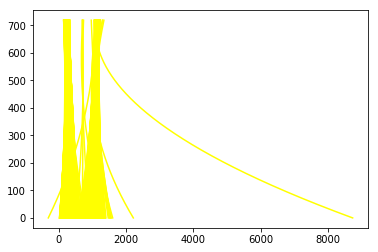

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(img):
    
    # 1. Undistortion
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    # 2. Combine Color and Gradient Threshold
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    s_channel = hls[:,:,2]
    s_thresh=(150, 255)
    sx_thresh=(20, 160)
    sy_thresh=(20, 160)
    
    # Sobel x
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= sx_thresh[0]) & (scaled_sobelx <= sx_thresh[1])] = 1
    
    
    # Sobel y
    sobely = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobely = np.absolute(sobely) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    # Threshold y gradient
    sybinary = np.zeros_like(scaled_sobely)
    sybinary[(scaled_sobely >= sy_thresh[0]) & (scaled_sobely <= sy_thresh[1])] = 1
    
    
    # Stack each channel
    color_binary = np.zeros_like(sxbinary)
    color_binary[(sxbinary == 1) & (sybinary == 1)] = 1
    
    # plt.imshow(color_binary,cmap='gray')
    # plt.show()

    # 3. Apply Perspective Transform
    img_raw = img.copy()
    img_raw = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
    bottomY = 720
    topY = 450

    left1_x, left1_y = (200, bottomY)
    left2_x, left2_y = (585, topY)
    right1_x, right1_y = (700, topY)
    right2_x, right2_y = (1100, bottomY)

    cv2.line(img_raw, (left1_x, left1_y), (left2_x, left2_y), [255, 0, 0], 2)
    cv2.line(img_raw, (left2_x, left2_y), (right1_x, right1_y), [255, 0, 0], 2)
    cv2.line(img_raw, (right1_x, right1_y), (right2_x, right2_y), [255, 0, 0], 2)
    cv2.line(img_raw, (right2_x, right2_y), (left1_x, left1_y), [255, 0, 0], 2)
    # fig, ax = plt.subplots(figsize=(40, 20))
    # axes[0].imshow(img_raw)
    gray = cv2.cvtColor(img_raw, cv2.COLOR_RGB2GRAY)
    src = np.float32([[left2_x, left2_y], [right1_x, right1_y], [right2_x, right2_y], [left1_x, left1_y]])
    nX = gray.shape[1]
    nY = gray.shape[0]
    img_size = (nX, nY)
    offset = 200
    dst = np.float32([[offset, 0], [img_size[0]-offset, 0], [img_size[0]-offset, img_size[1]], [offset, img_size[1]]])
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    print(M)
    MInverse = cv2.getPerspectiveTransform(dst, src)
    print(MInverse)
    
    img_size = (color_binary.shape[1], color_binary.shape[0])
    binary_warped = cv2.warpPerspective(color_binary, M, img_size)
    # plt.imshow(binary_warped)
    # plt.show()
    
    
    # 4. Fit lane lines to polynomial
    out_img, left_fit_cr, right_fit_cr, left_fit, right_fit = fit_polynomial(binary_warped)
    left_curverad, right_curverad = measure_curvature_real(left_fit_cr, right_fit_cr)
    print(left_curverad, 'm', right_curverad, 'm')
    print(left_curverad/1000, 'km', right_curverad/1000, 'km')
    # plt.imshow(out_img)
    # plt.show()
    
    # 5. Merge final lane lines to original image 
    color_warp = np.zeros_like(img).astype(np.uint8)
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, MInverse, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    
    cv2.putText(result, 'Left curvature: {:.0f} m'.format(left_curverad), (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)
    cv2.putText(result, 'Right curvature: {:.0f} m'.format(right_curverad), (50, 120), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)
    
    # Calculate vehicle center and deviation from center 
    # Calculate vehicle center
    xMax = img.shape[1]*xm_per_pix
    yMax = img.shape[0]*ym_per_pix
    vehicleCenter = xMax / 2
    leftLane = left_fit_cr[0]*yMax**2 + left_fit_cr[1]*yMax + left_fit_cr[2]
    rightLane = right_fit_cr[0]*yMax**2 + right_fit_cr[1]*yMax + right_fit_cr[2]
    middleLane = leftLane + (rightLane - leftLane)/2
    diffFromVehicle = middleLane - vehicleCenter
    if diffFromVehicle > 0:
        message = '{:.2f} m right'.format(diffFromVehicle)
    else:
        message = '{:.2f} m left'.format(-diffFromVehicle)
        
    cv2.putText(result, 'Vehicle is {} of center'.format(message), (50, 190), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)
    return result

test_video_output = '../project_video_output.mp4'
clip = VideoFileClip("../project_video.mp4")
result = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time result.write_videofile(test_video_output, audio=False)